# Подключаем нужные библиотеки

In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
import pandas as pd
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [2]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [3]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [4]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 233 ms, sys: 18.9 ms, total: 252 ms
Wall time: 248 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [5]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [6]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

CPU times: user 95.9 ms, sys: 25.8 ms, total: 122 ms
Wall time: 122 ms


Пример того, как выглядят тесты для полноградиентного случая

In [7]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 571 µs, sys: 0 ns, total: 571 µs
Wall time: 508 µs


In [8]:
num_of_tests = 600

In [9]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

CPU times: user 11.4 s, sys: 500 ms, total: 11.9 s
Wall time: 13.8 s


In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 35.1 s, sys: 7.36 s, total: 42.4 s
Wall time: 31 s


Пример тестов для случая стох. градиентов

In [11]:
batch_size = 1
num_of_tests = 10000

In [12]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 12.4 s, sys: 114 ms, total: 12.5 s
Wall time: 12.4 s


In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 659 ms, sys: 10 ms, total: 669 ms
Wall time: 664 ms


Зафиксируйте здесь результаты своих экспериментов:

In [14]:
def test_dataset(datasets, num_of_tests, batch_array=(1, 10, 100)):     
    
    res = {
        'Датасет': [],
        'Число функций в сумме': [],
        'Размерность задачи': [],
        'Константа гладкости всей функции': [],
        'Средняя константа гладкости': [],
        'Худшая константа гладкости': [],
        'Доля ненулевых элементов': [],
        'time A (full_batch)': [],
        'time denseA (full_batch)': []
    }

    for batch_size in batch_array:
        res[f'time A (batch={batch_size})'] = []
        res[f'time denseA (batch={batch_size})'] = []

    for dataset in datasets:
        res['Датасет'].append(dataset)
        
        A, y, m, n, sparsity_A = prepare_data(dataset)
        L, average_L, worst_L = compute_L(dataset, A)
        
        res['Число функций в сумме'].append(m)
        res['Размерность задачи'].append(n)
        res['Константа гладкости всей функции'].append(L)
        res['Средняя константа гладкости'].append(average_L)
        res['Худшая константа гладкости'].append(worst_L)
        res['Доля ненулевых элементов'].append(sparsity_A)

        denseA = A.toarray()
        batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

        start_time = time.time()
        for _ in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                logreg_grad(x, [A, y, 0, True])
        res['time A (full_batch)'].append(time.time() - start_time)
        
        start_time = time.time()    
        for _ in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                logreg_grad(x, [denseA, y, 0, False])
        res['time denseA (full_batch)'].append(time.time() - start_time)
        
        for batch_size in batch_array:
            start_time = time.time() 
            for _ in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                    logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
            res[f'time A (batch={batch_size})'].append(time.time() - start_time)
            
            start_time = time.time() 
            for _ in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                    logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
            res[f'time denseA (batch={batch_size})'].append(time.time() - start_time)
            
    return pd.DataFrame(res)

In [15]:
test_dataset(
    datasets=(
        'a5a',
        'a9a',
        'australian',
        'breast-cancer',
        'diabetes',
        'german_numer',
        'heart',
        'mushrooms'
    ),
    num_of_tests=100
)

Датасет  Число функций в сумме  Размерность задачи  \
0            a5a                   6414                 122   
1            a9a                  32561                 123   
2     australian                    690                  14   
3  breast-cancer                    683                  10   
4       diabetes                    768                   8   
5   german_numer                   1000                  24   
6          heart                    270                  13   
7      mushrooms                   8124                 112   

   Константа гладкости всей функции  Средняя константа гладкости  \
0                      1.574027e+00                 3.466597e+00   
1                      1.571920e+00                 3.467277e+00   
2                      7.036285e+06                 7.051932e+06   
3                      3.859904e+11                 3.859904e+11   
4                      8.606923e+03                 1.086225e+04   
5                      8.436612e+02                 9.798927e+02   
6                      2.671068e+04                 2.714773e+04   
7                      2.586214e+00                 5.250000e+00   

   Худшая константа гладкости  Доля ненулевых элементов  time A (full_batch)  \
0                3.500000e+00                  0.113659             0.385233   
1                3.500000e+00                  0.112757             1.361699   
2                2.500101e+09                  0.799586             0.083355   
3                4.525490e+13                  1.000000             0.084420   
4                1.899885e+05                  0.875814             0.078729   
5                9.305750e+03                  0.749542             0.115921   
6                9.036964e+04                  0.750997             0.068771   
7                5.250000e+00                  0.187500             0.548794   

   time denseA (full_batch)  time A (batch=1)  time denseA (batch=1)  \
0                  0.440156          0.160458               0.006316   
1                  2.806466          0.164498               0.006291   
2                  0.033173          0.162218               0.006657   
3                  0.016423          0.122281               0.006171   
4                  0.016360          0.147814               0.006305   
5                  0.035141          0.160844               0.006148   
6                  0.009013          0.170606               0.006537   
7                  0.452106          0.171337               0.006302   

   time A (batch=10)  time denseA (batch=10)  time A (batch=100)  \
0           0.128201                0.007682            0.122800   
1           0.122107                0.007616            0.131697   
2           0.122607                0.006891            0.120972   
3           0.115660                0.006792            0.132908   
4           0.122074                0.006554            0.121349   
5           0.112301                0.006737            0.121413   
6           0.166269                0.006850            0.124777   
7           0.118686                0.007647            0.132899   

   time denseA (batch=100)  
0                 0.023364  
1                 0.025597  
2                 0.009163  
3                 0.009141  
4                 0.008871  
5                 0.009013  
6                 0.009061  
7                 0.030952

Лучше использовать `denseA`, т.к. он практически во всех случаях (за исключением полного батча на датасетах а5а и а9а) показывает себя лучше

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [16]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.maximum(np.abs(x) - lamb, 0) * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [17]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [18]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 244 ms, sys: 40.2 ms, total: 284 ms
Wall time: 247 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [19]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 16 ms, sys: 990 µs, total: 17 ms
Wall time: 14.1 ms


array([ 3577,  7922, 26571, ..., 28710, 28991, 15634])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [20]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 1min 12s, sys: 2.89 s, total: 1min 15s
Wall time: 1min 10s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [21]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [22]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
           sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
           l1=l1, S=S, M=M, max_t=np.inf,
           batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
           x_star=x_star, f_star=f_star)

CPU times: user 1.55 s, sys: 301 ms, total: 1.85 s
Wall time: 1.52 s


Запустите функцию, тестирующую корректность работы

In [23]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [24]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [25]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [26]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [27]:
# ваш код здесь
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [28]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
           sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
           l1=l1, S=S, M=M, max_t=np.inf,
           batch_size=batch_size, indices=None, save_info_period=save_info_period, 
           x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
CPU times: user 4min 11s, sys: 53.2 s, total: 5min 4s
Wall time: 4min 3s


In [29]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [30]:
%%time
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 253
         Gradient evaluations: 247
0.3579855634166646
CPU times: user 2.11 s, sys: 1.48 s, total: 3.59 s
Wall time: 1.95 s


Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [31]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [32]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
           sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
           l1=l1, S=S, M=M, max_t=np.inf,
           batch_size=batch_size, save_info_period=save_info_period, 
           x_star=x_star, f_star=f_star)

CPU times: user 1.51 s, sys: 341 ms, total: 1.85 s
Wall time: 1.49 s


Следующая функция позволяет строить графики

In [33]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [34]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

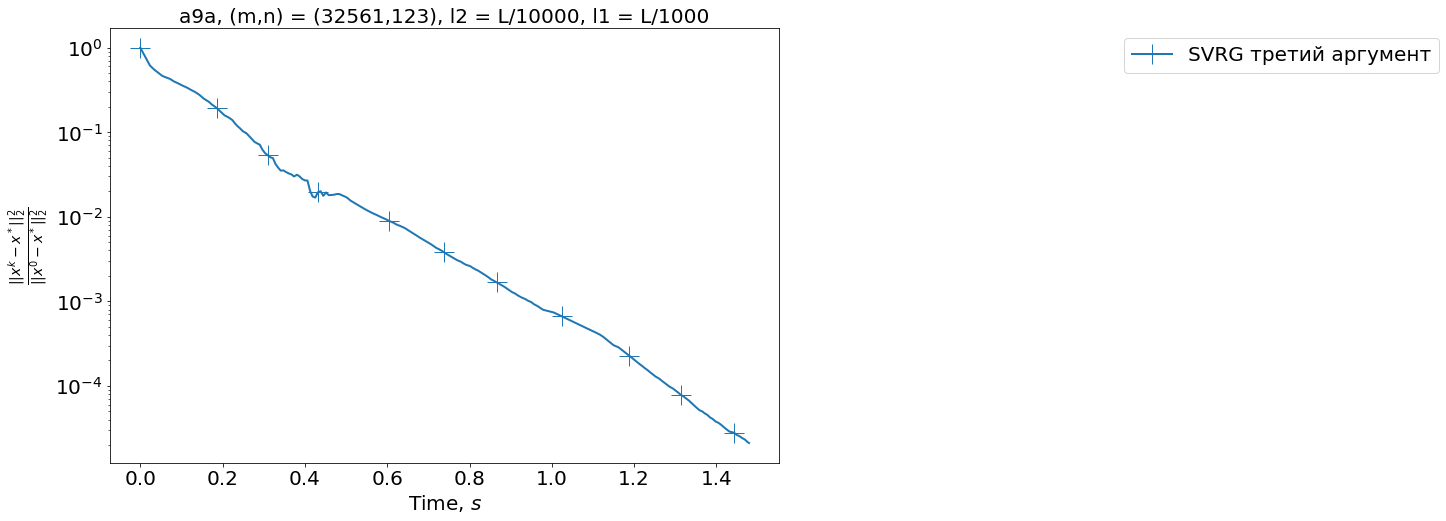

In [35]:
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [36]:
%%time
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
test_indices = None
x_init = np.ones(n)
l2 = L / 10000
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 1000
batch_size = 10
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
l1_array = (L / 10000, L / 1000, L / 100)

for l1_ in l1_array:
    M = int(2*m/batch_size)
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
               sparse_full=sparse_full, sparse_stoch=sparse_stoch,
               l1=l1_, S=S, M=M, max_t=np.inf,
               batch_size=batch_size, indices=None, save_info_period=save_info_period, 
               x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1_, res['last_iter'], res['func_vals'][-1])

CPU times: user 25min 38s, sys: 5min 20s, total: 30min 59s
Wall time: 24min 51s


In [37]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
test_indices = None
x_init = np.ones(n)
l2 = L / 10000
gamma = 1.0/(6*(L+l2))
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False

batch_array = (1, 10, 100)

for l1_ in l1_array:
    x_star = read_solution(dataset, l2, l1_)[0]
    f_star = read_solution(dataset, l2, l1_)[1]

    for batch_size in batch_array:
        M = int(2*m/batch_size)
        res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
                   sparse_full=sparse_full, sparse_stoch=sparse_stoch,
                   l1=l1_, S=S, M=M, max_t=np.inf,
                   batch_size=batch_size, indices=None, save_info_period=save_info_period, 
                   x_star=x_star, f_star=f_star)

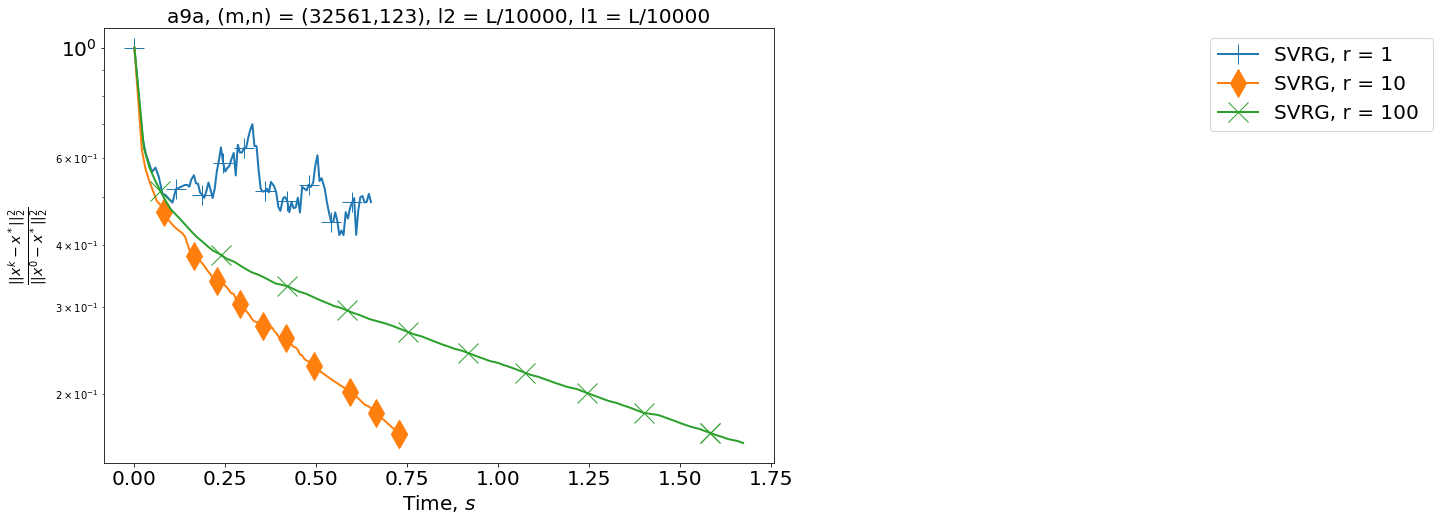

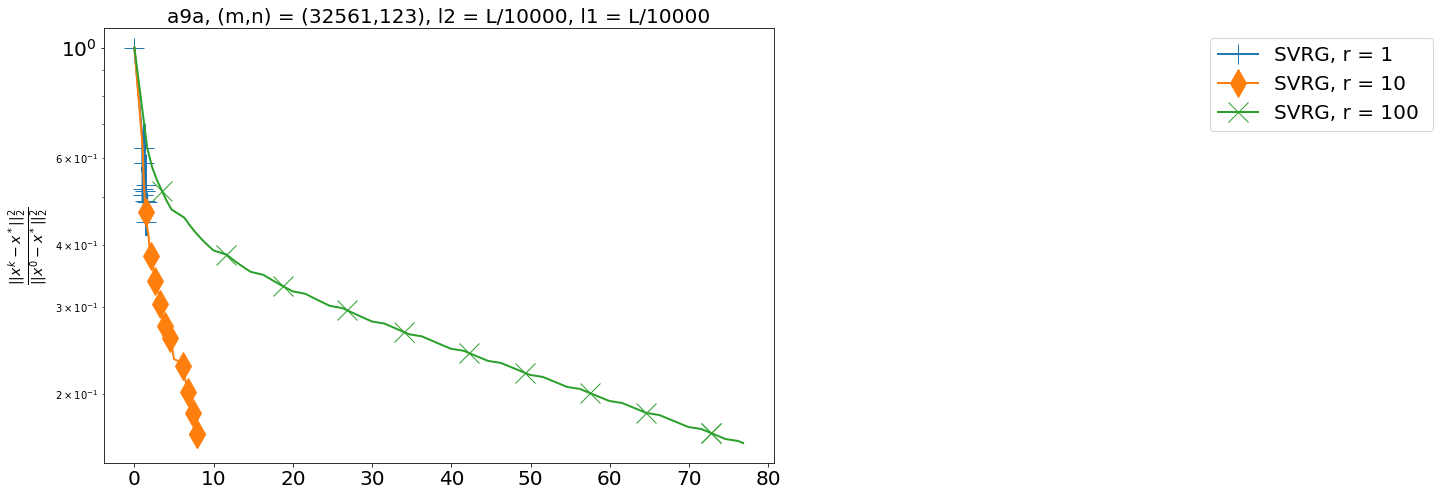

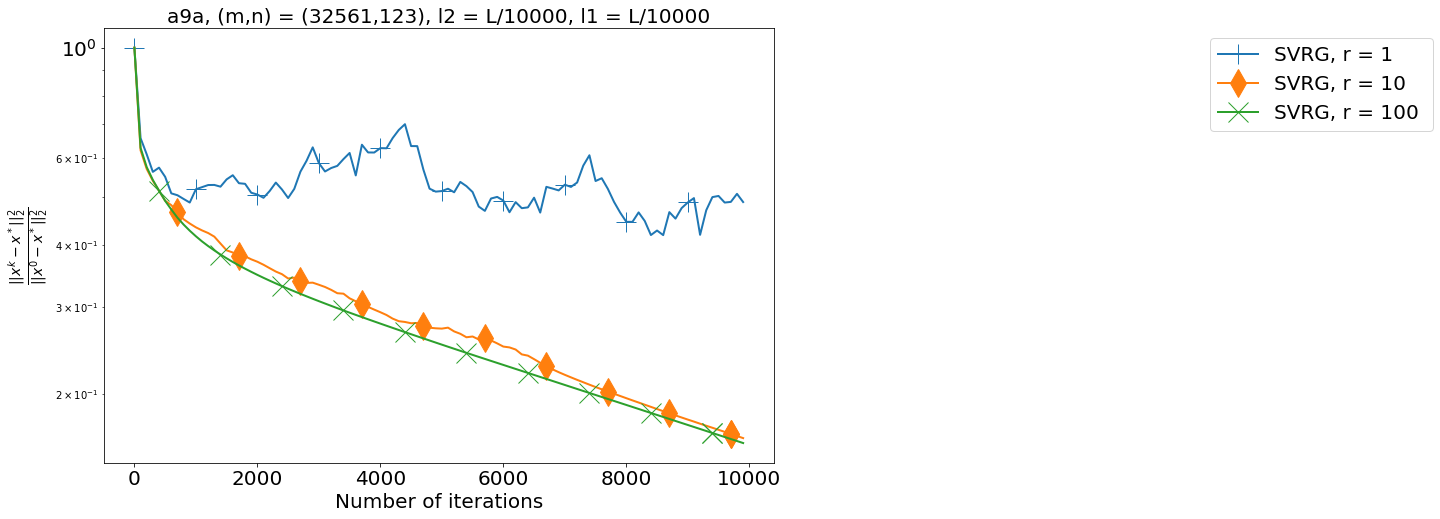

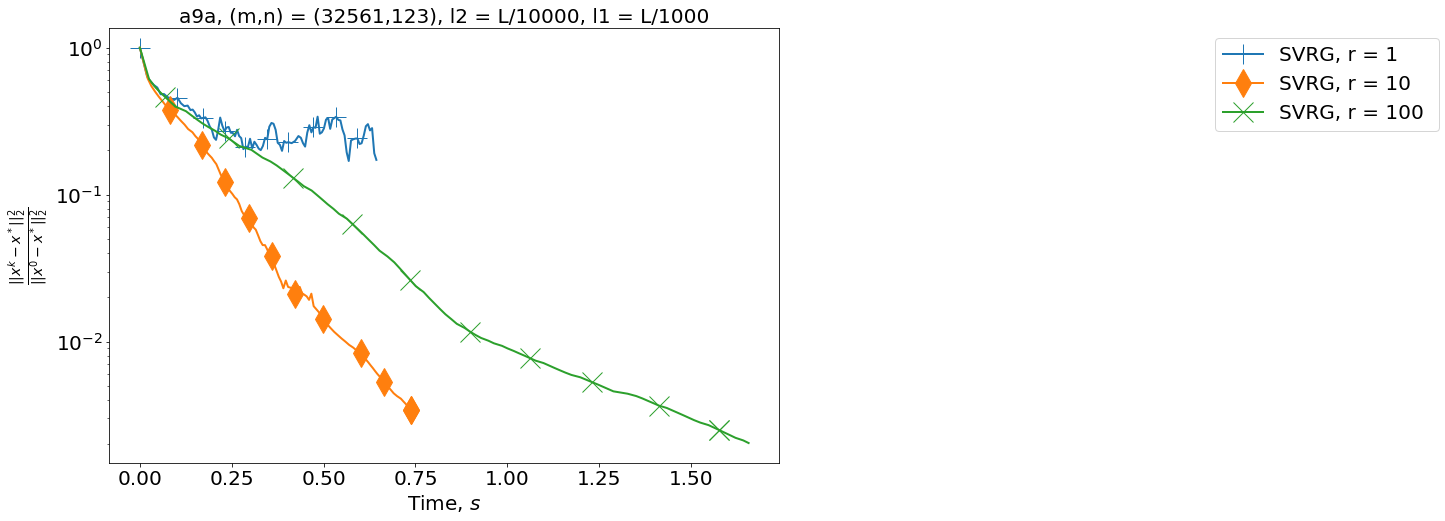

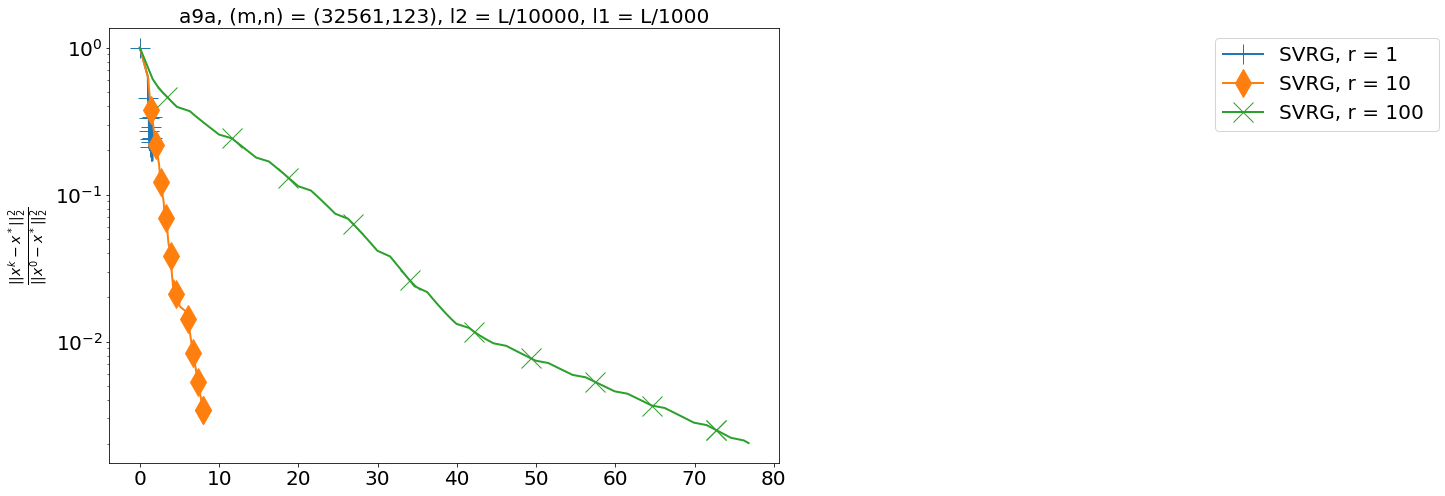

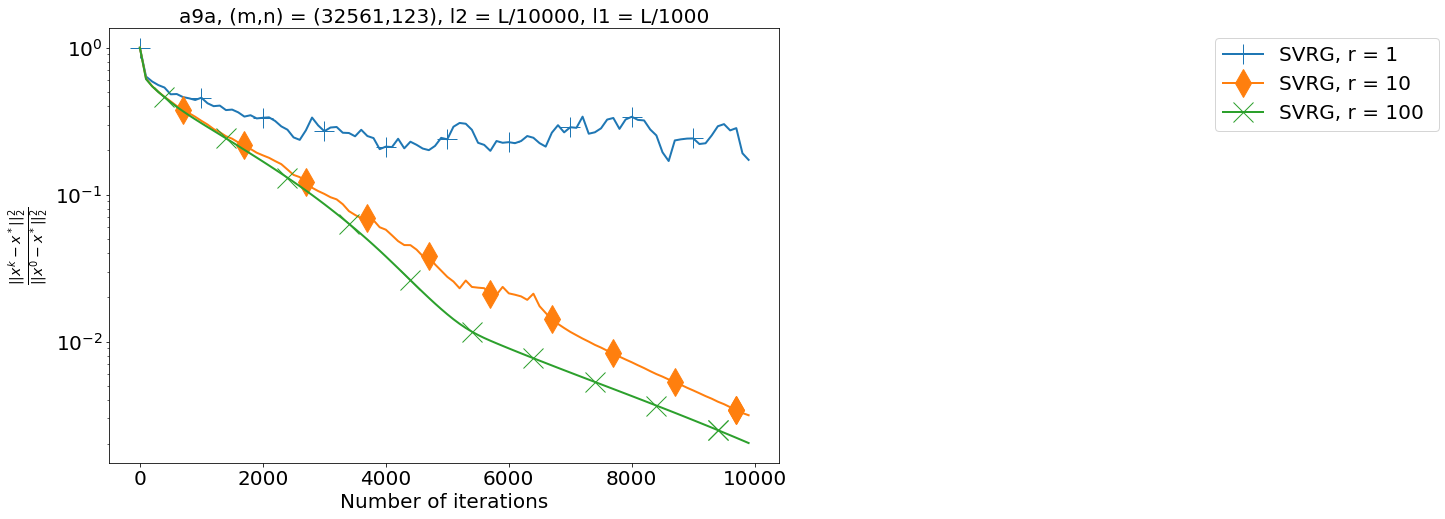

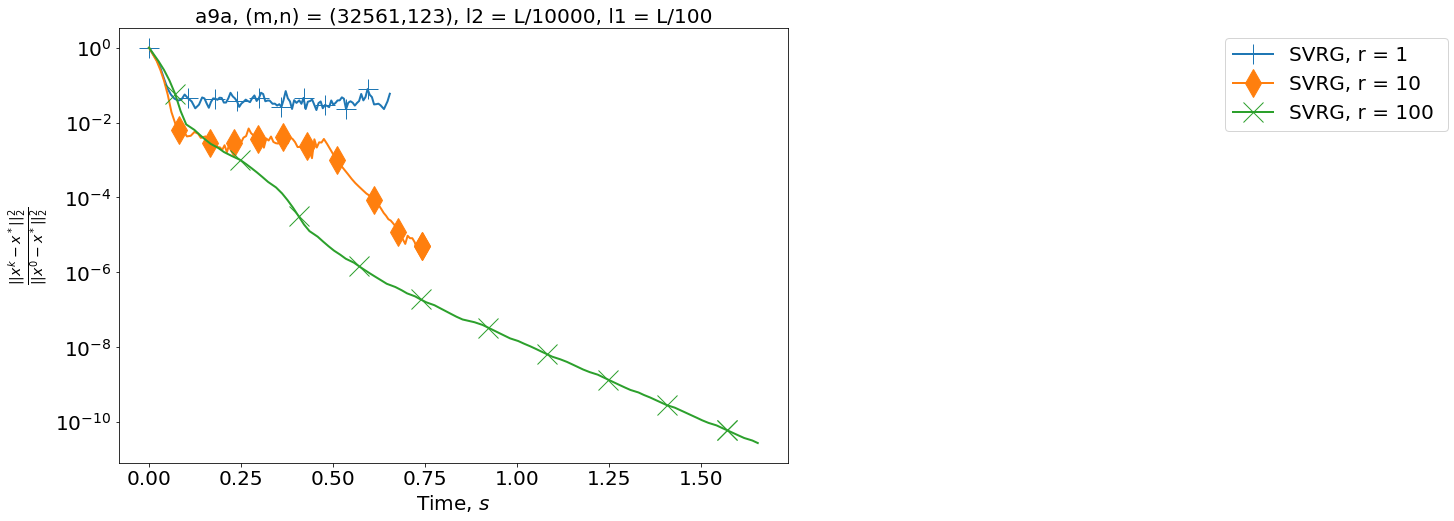

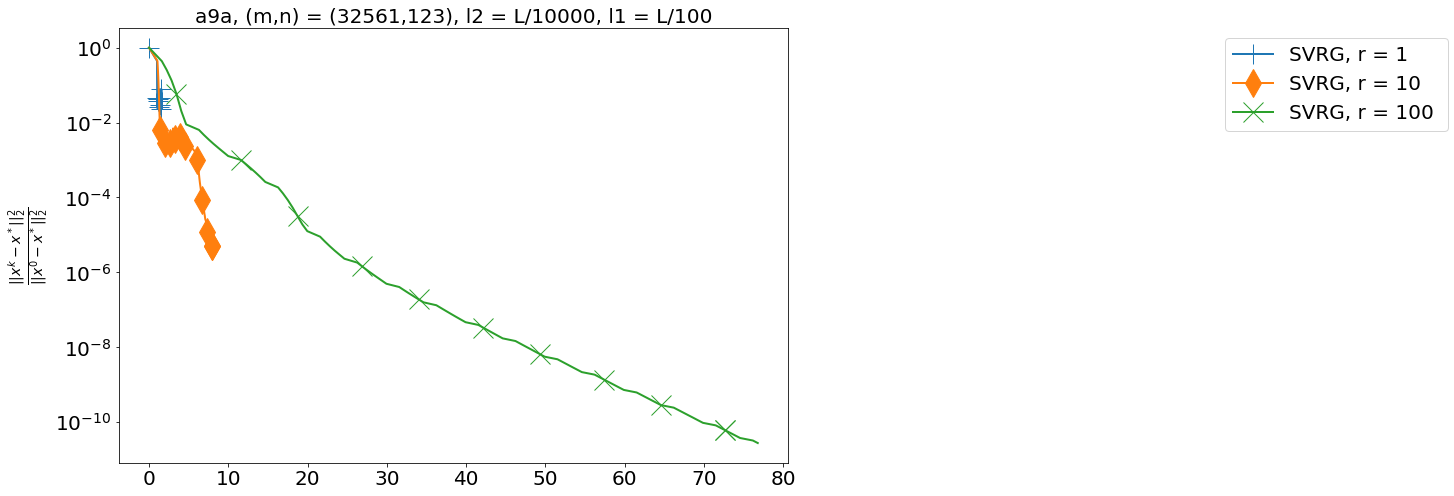

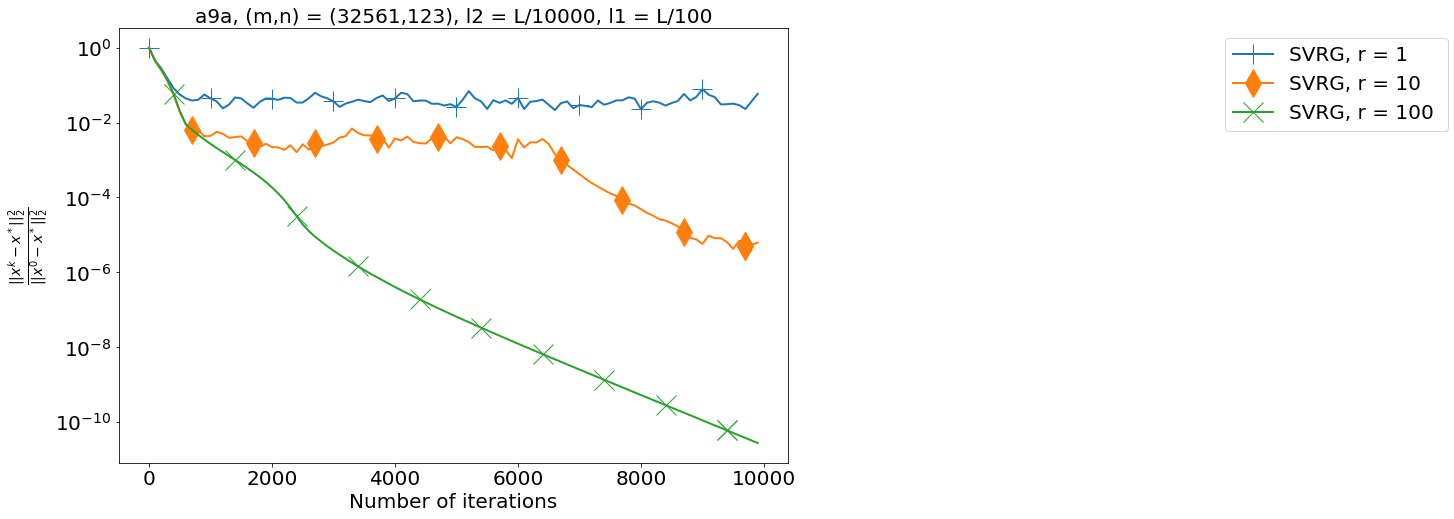

In [38]:
for l1_ in l1_array:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    gamma = 1.0/(6*(L+l2))
    methods = []
    for batch_size in batch_array:
        methods.append(['SVRG', [gamma, l2, l1_, S, int(2*m/batch_size), batch_size], f', r = {batch_size} ', 100])
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    l1_string = "0" if l1_ == 0 else "L/"+str(int(L/l1_))
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = "+l1_string

    for mode_x in ('time', 'data_passes', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

При большем размере батча (100) метод по числу итераций сходится быстрее.
По затраченному времени в первых двух случаях сходимость быстрее при размере батча равном 10, в последнем случае при равном 100.
По числу эпох сходимость во всех случаях быстрее при размере батча равном 10

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [39]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [40]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
                         sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                         l1=l1, S=S, max_t=np.inf,
                         batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                         x_star=x_star, f_star=f_star)

CPU times: user 494 ms, sys: 3.01 ms, total: 497 ms
Wall time: 496 ms


Запустите функцию, тестирующую корректность работы

In [41]:
sgd_const_test(res)

Тесты пройдены!


0

In [42]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [43]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                        sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                        l1=l1, S=S, max_t=np.inf,
                        batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                        x_star=x_star, f_star=f_star)

CPU times: user 1.63 s, sys: 7.69 ms, total: 1.64 s
Wall time: 1.65 s


Запустите функцию, тестирующую корректность работы

In [44]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [45]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
alpha_array = (1, 0.1, 0.01)
batch_array = (1, 10, 100)

for alpha in alpha_array:
    for batch_size in batch_array:
        M = int(2*m/batch_size)
        gamma = alpha/(L+l2)
        res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
                                 sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                 l1=l1, S=S, max_t=np.inf,
                                 batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                 x_star=x_star, f_star=f_star)

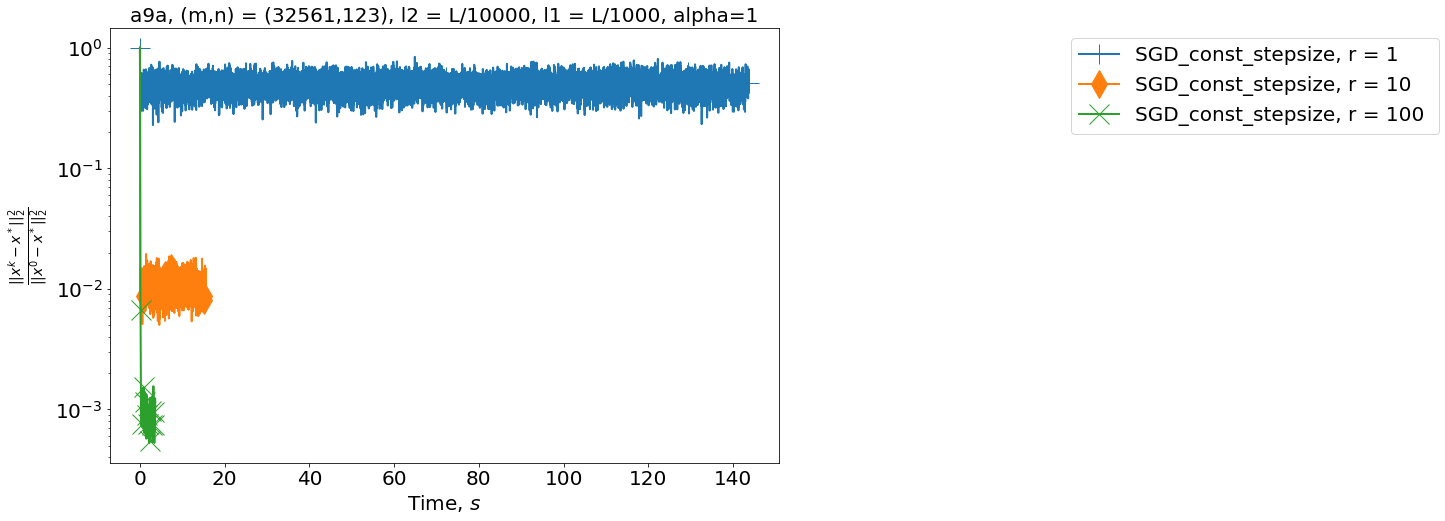

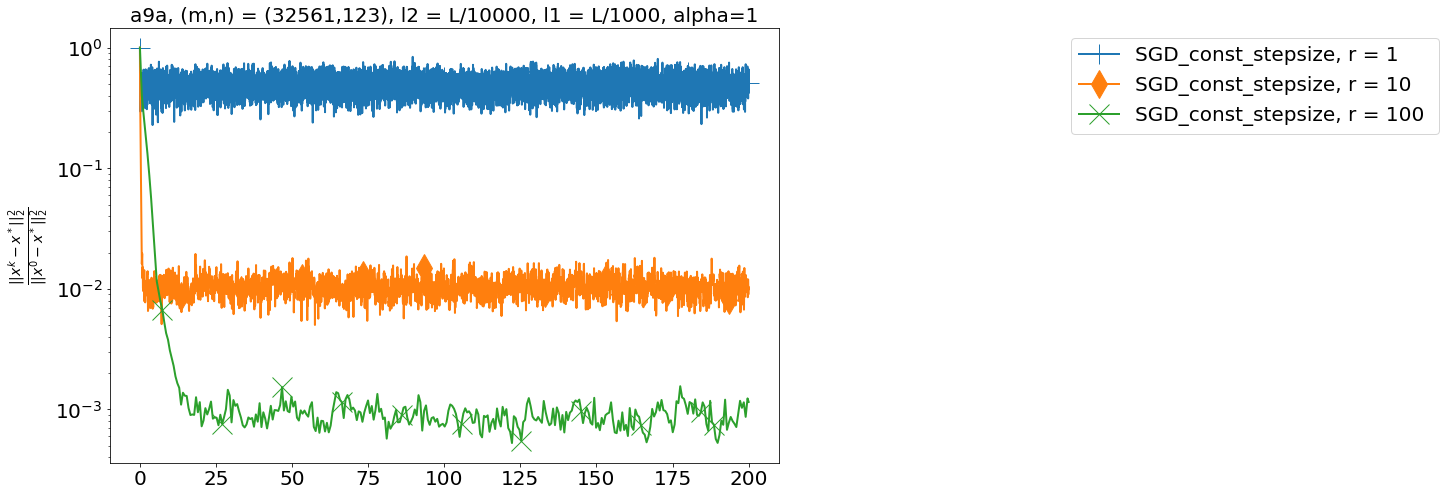

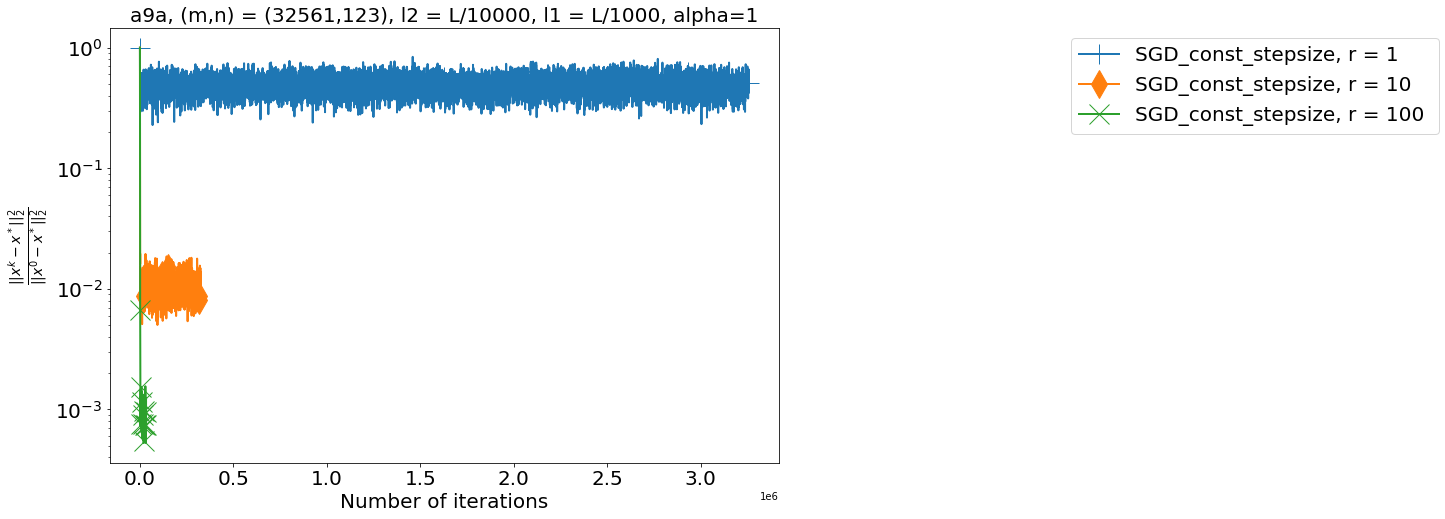

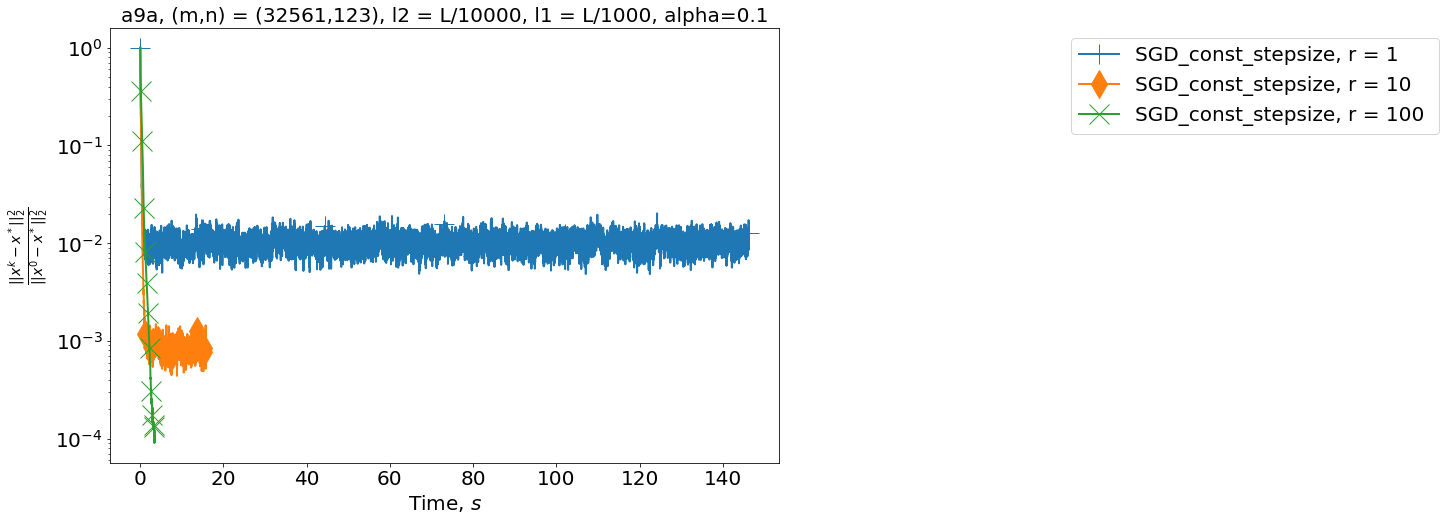

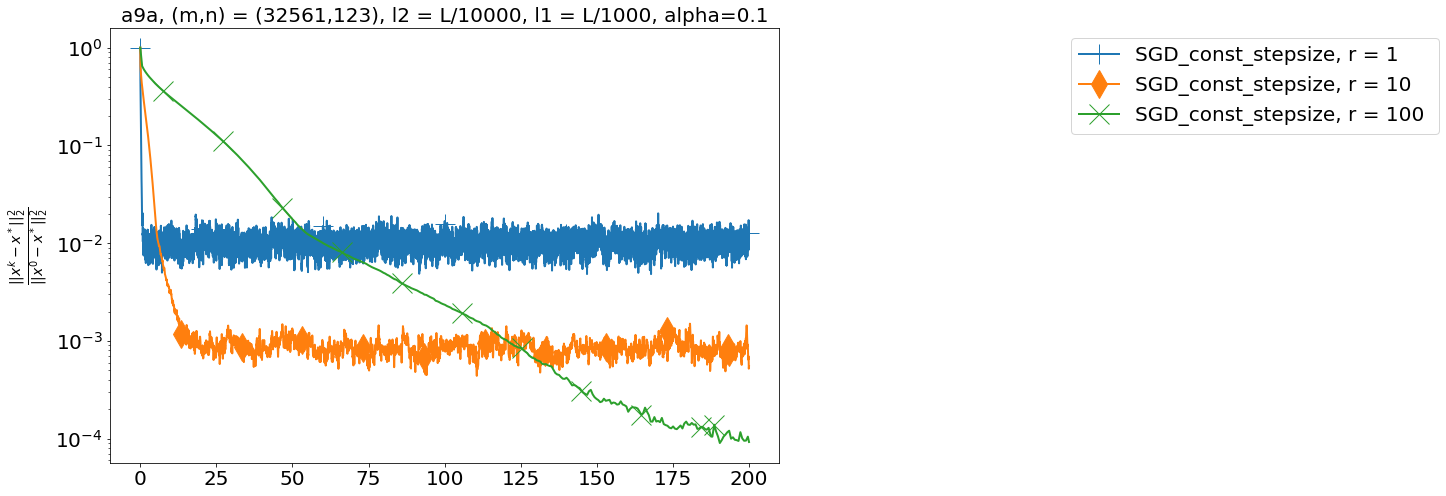

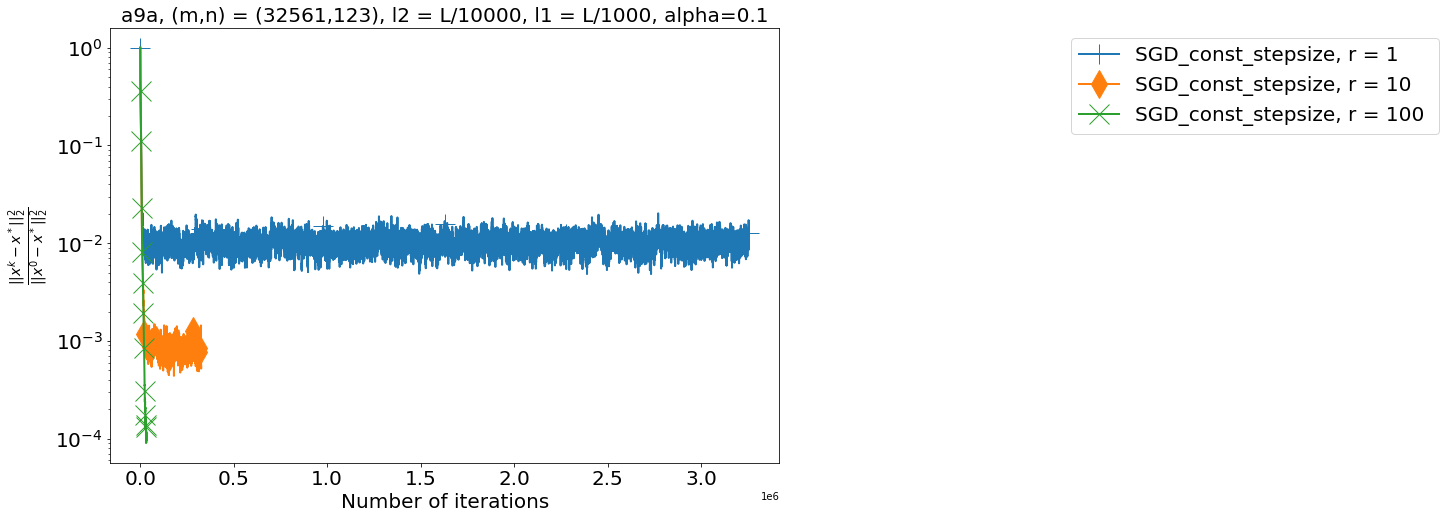

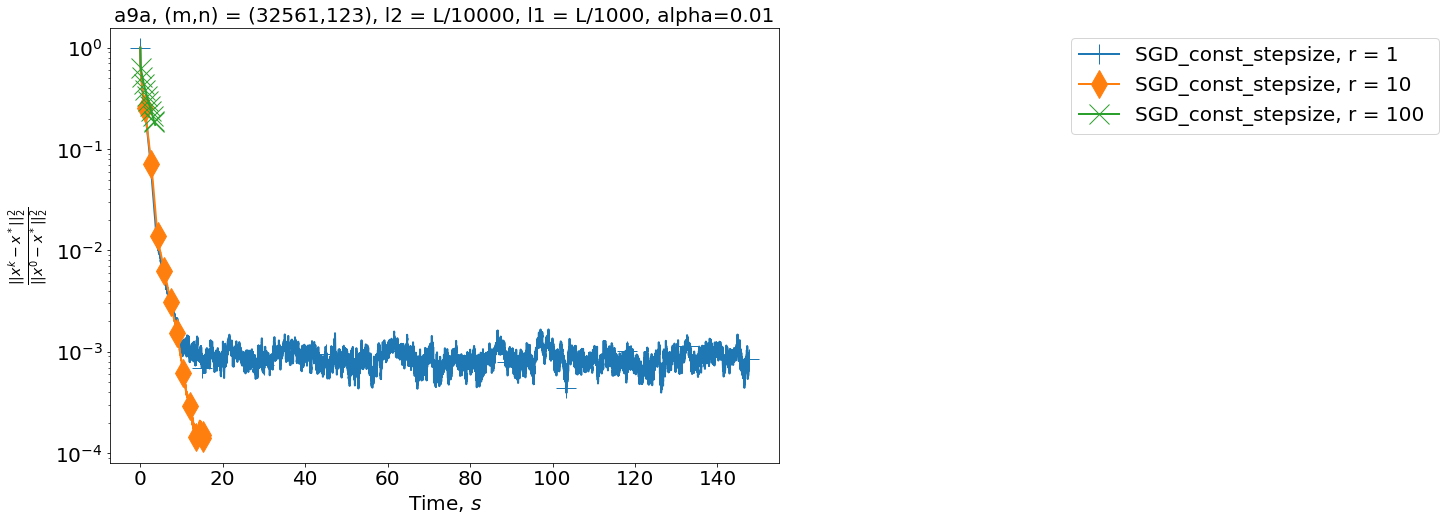

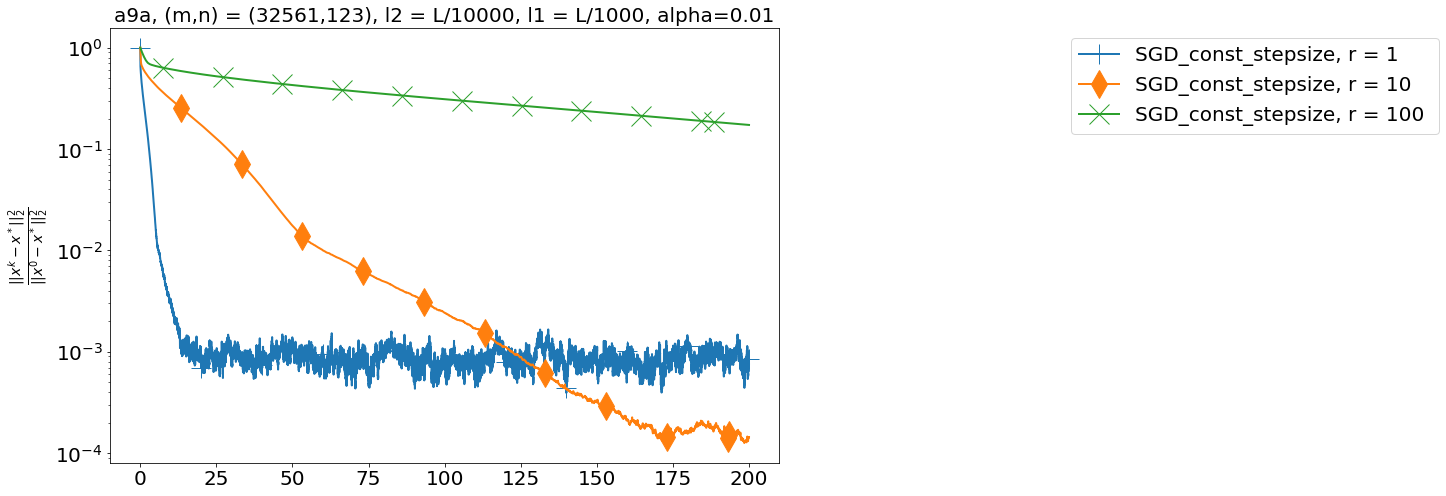

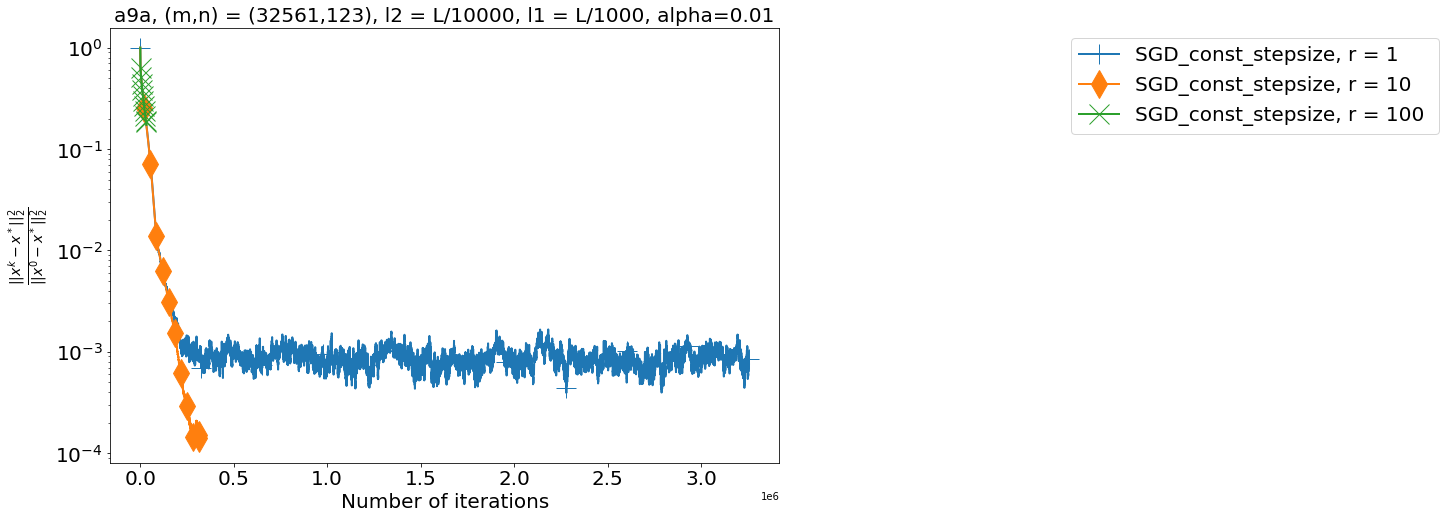

In [46]:
for alpha in alpha_array:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    l1 = L / 1000
    methods = []
    for batch_size in batch_array:
        methods.append(['SGD_const_stepsize', [alpha/(L+l2), l2, l1, S, batch_size], f', r = {batch_size} ', None])
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", alpha="+str(alpha)
    
    for mode_x in ('time', 'data_passes', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

Чем меньше $\alpha$, тем больше точность решения.
Также чем больше размер батча, тем больше точность решения. Это согласуется с теоретическими результатами (для SGD радиус окресности сходимости равен $\sqrt{\frac{\gamma \sigma^2}{\mu r}}$ )

In [47]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1/(L+l2)
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
batch_array = (1, 10, 100)
T_array = (1, 2)
beta_array = (0.5, 0.9)

for T in T_array:
    for beta in beta_array:
        for batch_size in batch_array:
            M = int(2*m/batch_size)
            gamma_schedule = [gamma, T, beta]
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                                    sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                    l1=l1, S=S, max_t=np.inf,
                                    batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                    x_star=x_star, f_star=f_star)

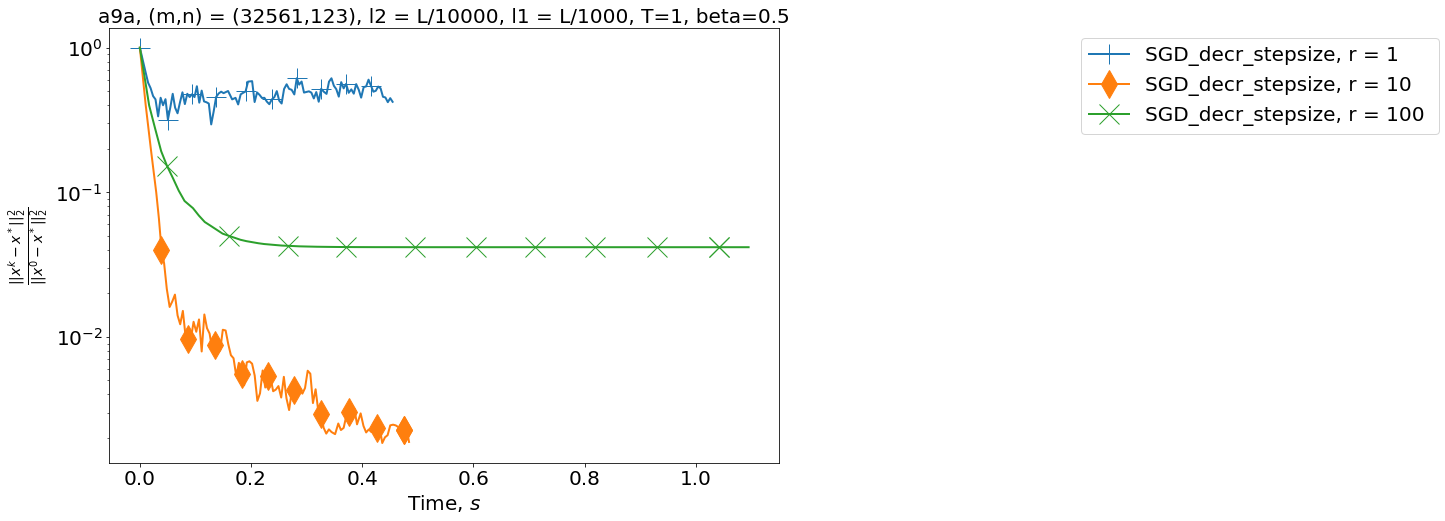

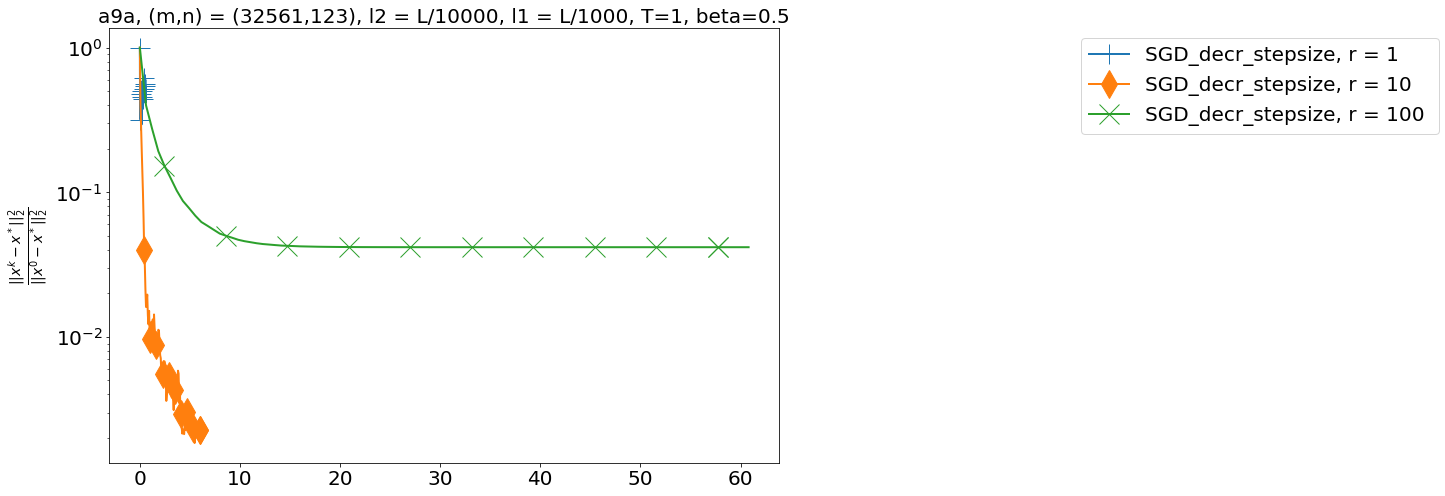

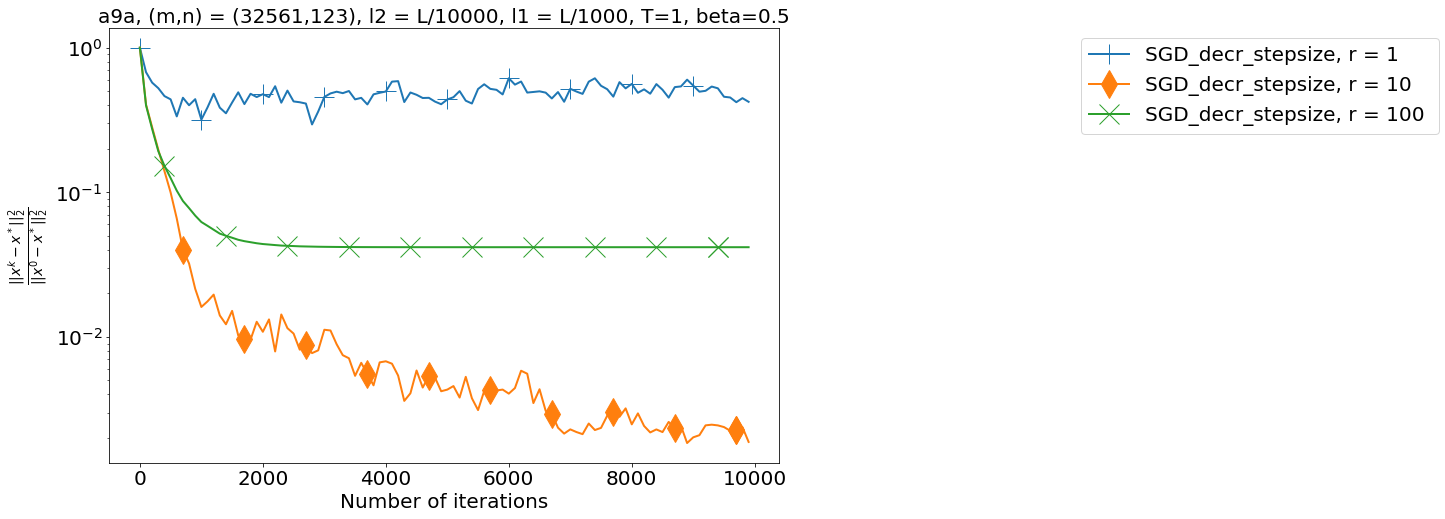

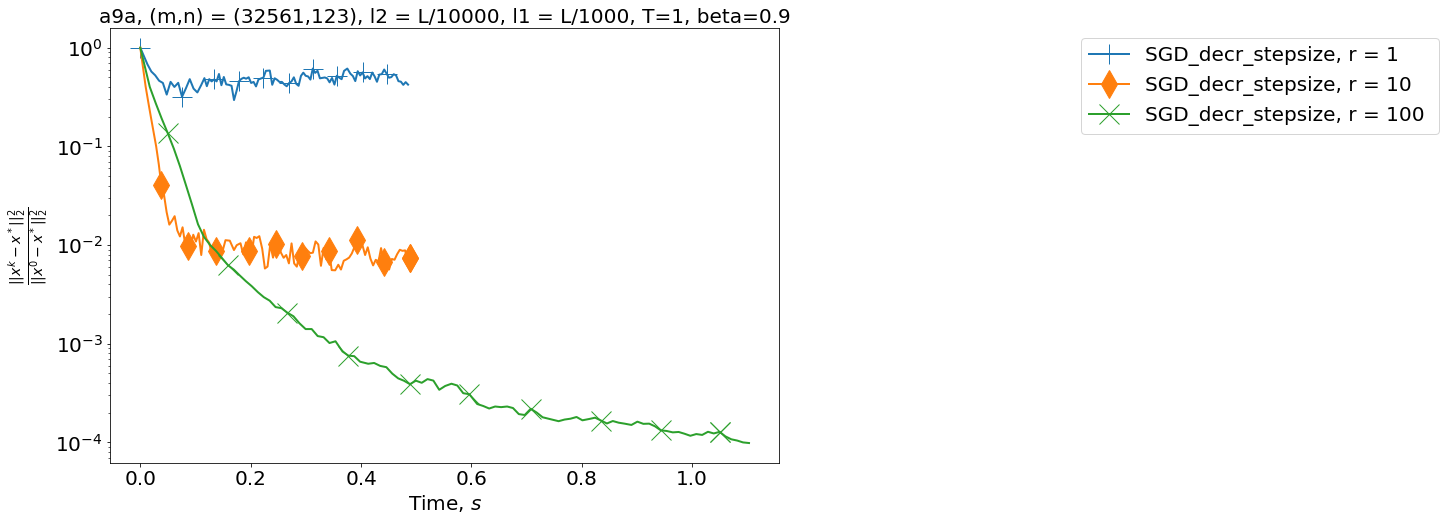

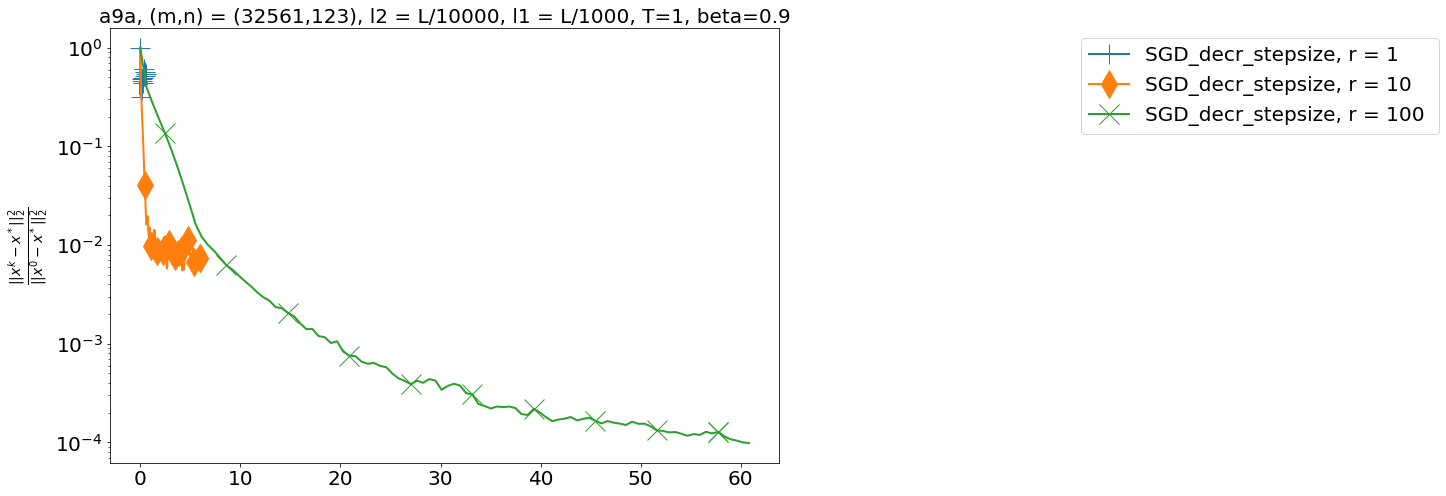

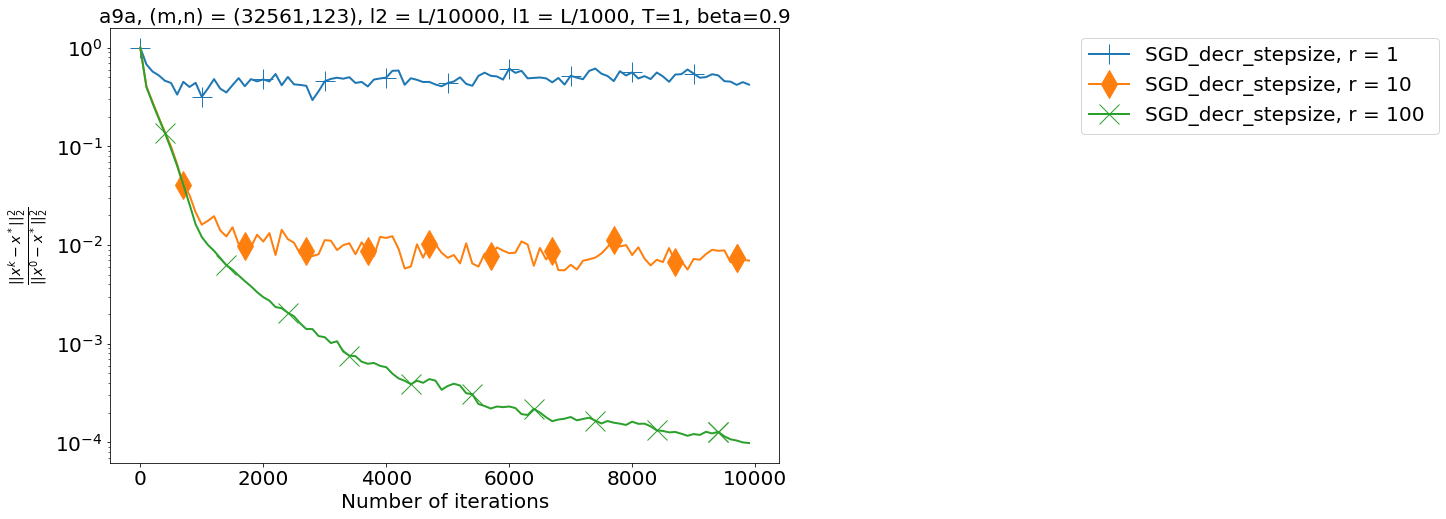

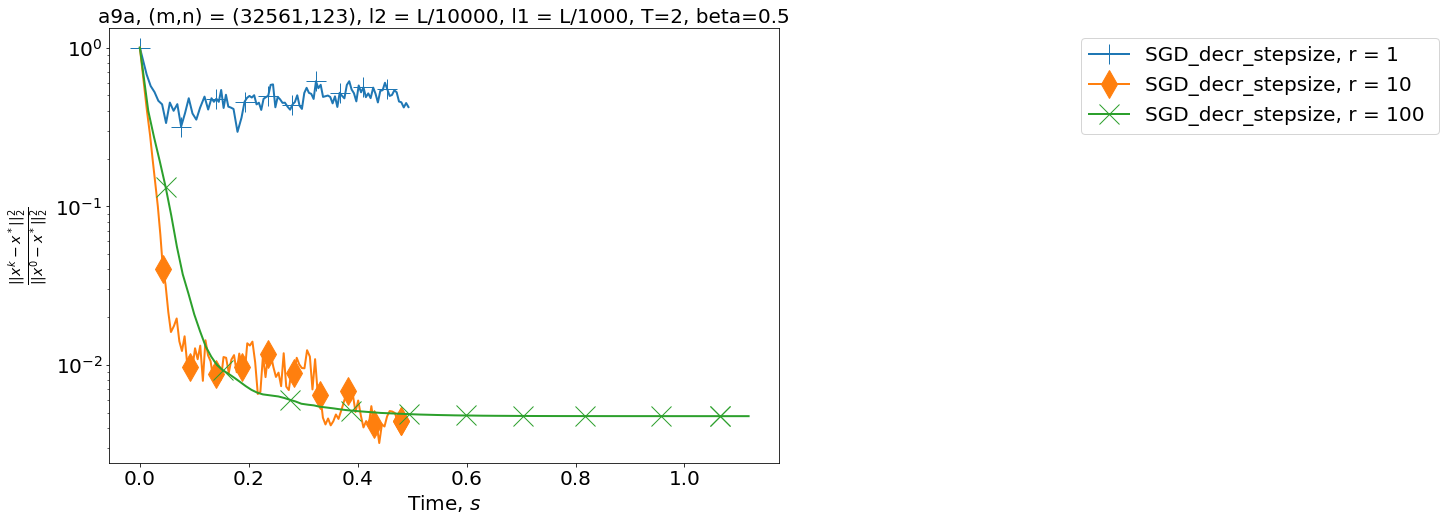

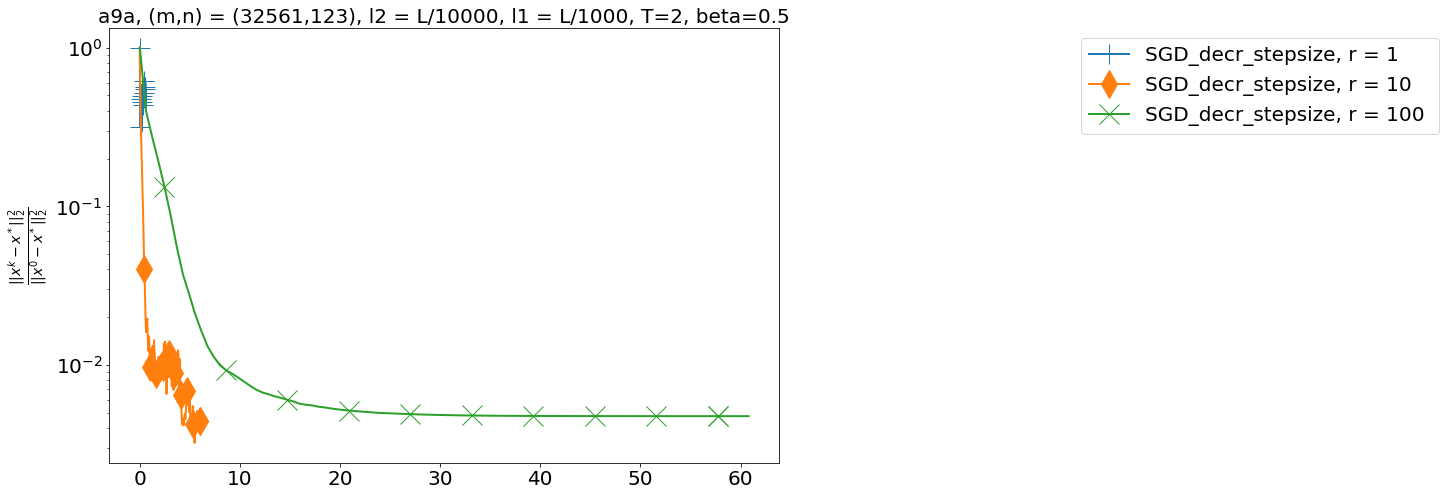

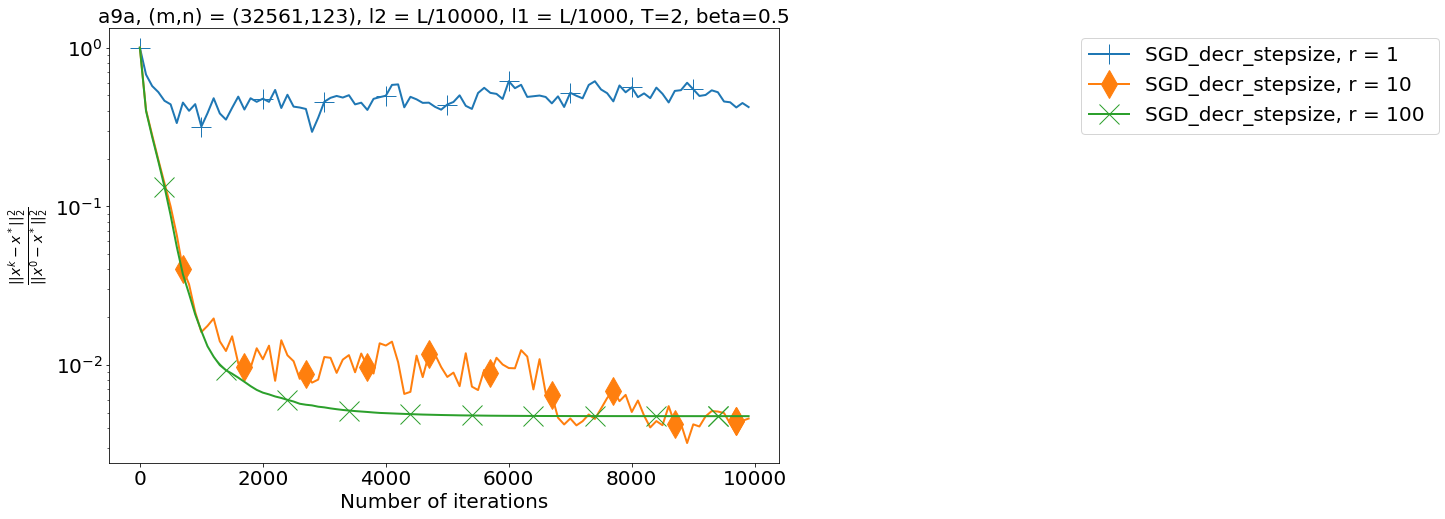

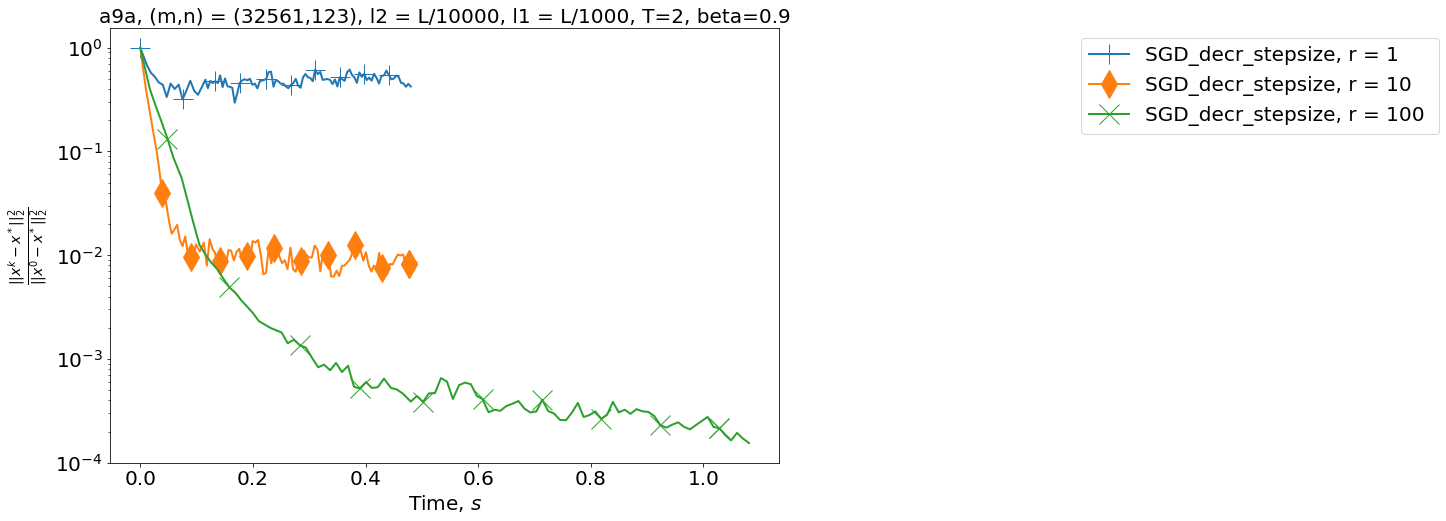

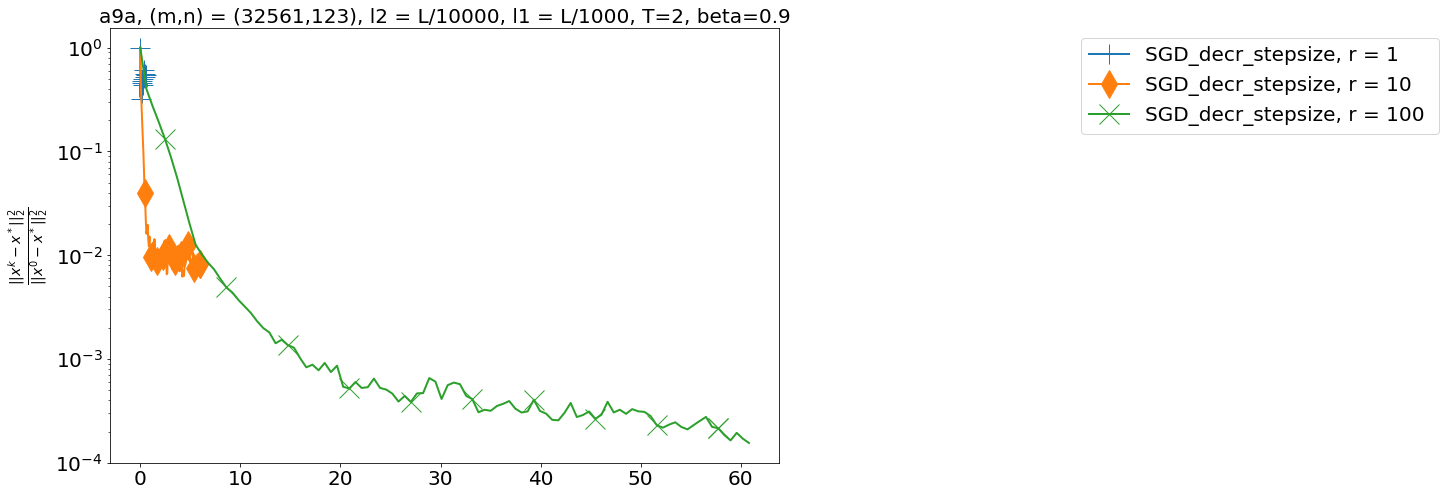

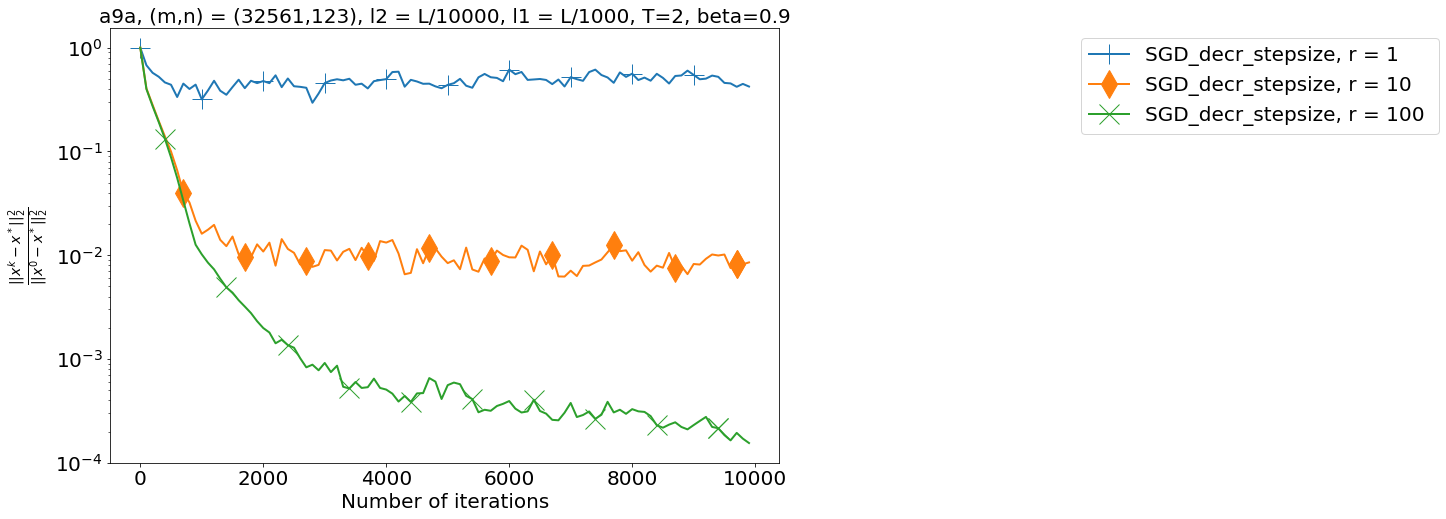

In [48]:
for T in T_array:
    for beta in beta_array:
        dataset = "a9a"
        filename=dataset+"_x_init_all_ones"
        l2 = L / 10000
        l1 = L / 1000
        gamma = 1/(L+l2)
        methods = []
        for batch_size in batch_array:
            methods.append(['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, batch_size], f', r = {batch_size} ', 100])
        mode_y = 'squared_distances'
        figsize = (12, 8)
        fontsize = 20
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", T="+str(T)+", beta="+str(beta)

        for mode_x in ('time', 'data_passes', 'iters'):
            args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
            make_plots(args=args_for_plots)
            plt.show()

Максимальная точность достигается при $(r, \beta, t) = (100, 0.9, 2)$ и $(r, \beta, t) = (100, 0.9, 1)$

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [49]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [50]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
              sparse=sparse, l1=l1, S=S, max_t=np.inf,
              save_info_period=save_info_period, 
              x_star=x_star, f_star=f_star)

CPU times: user 3.01 s, sys: 54 ms, total: 3.07 s
Wall time: 3.05 s


Запустите функцию, тестирующую корректность работы

In [51]:
prox_gd_test(res)

Тесты пройдены!


0

In [52]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этот параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [53]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
            sparse=sparse, l1=l1, S=S, max_t=np.inf,
            save_info_period=save_info_period, 
            x_star=x_star, f_star=f_star)

CPU times: user 3.05 s, sys: 43.6 ms, total: 3.09 s
Wall time: 3.08 s


Запустите функцию, тестирующую корректность работы

In [54]:
fista_test(res)

Тесты пройдены!


0

In [55]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [56]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

CPU times: user 3.01 s, sys: 39.9 ms, total: 3.05 s
Wall time: 3.04 s


Запустите функцию, тестирующую корректность работы

In [57]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [58]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
gamma = 1 / L
eps = 1e-8
S = int(np.sqrt(L / l2) * np.log((res['func_vals'][0] - f_star + l2 * res['squared_distances'][0]) / eps))
save_info_period = 10
sparse = True
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
              sparse=sparse, l1=l1, S=S, max_t=np.inf,
              save_info_period=save_info_period, 
              x_star=x_star, f_star=f_star)

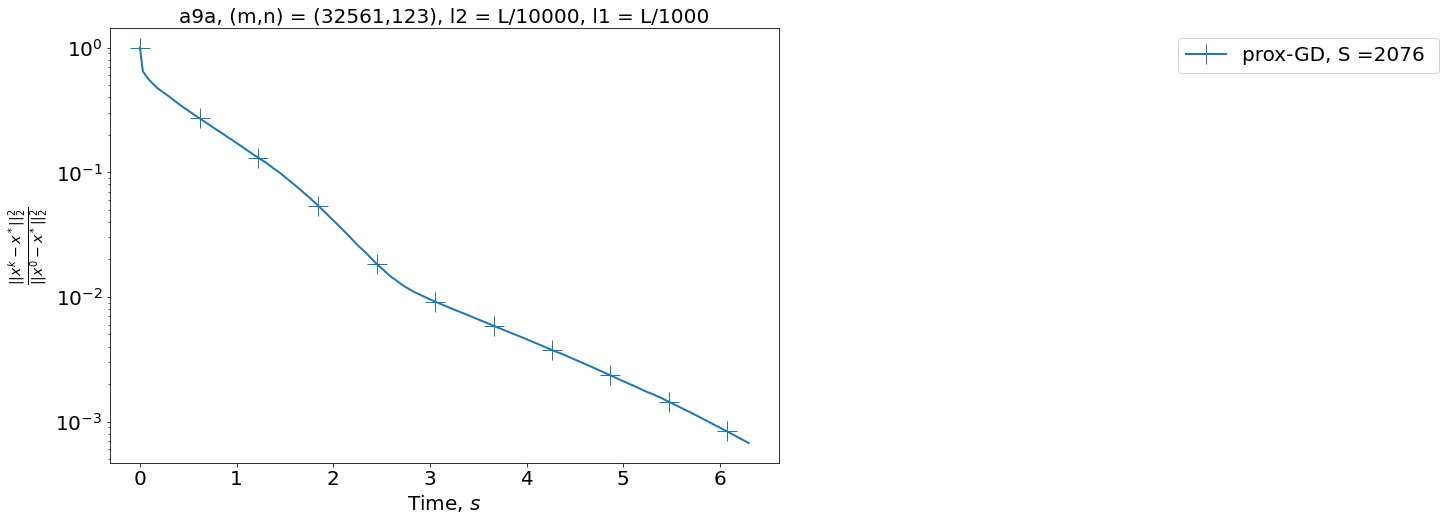

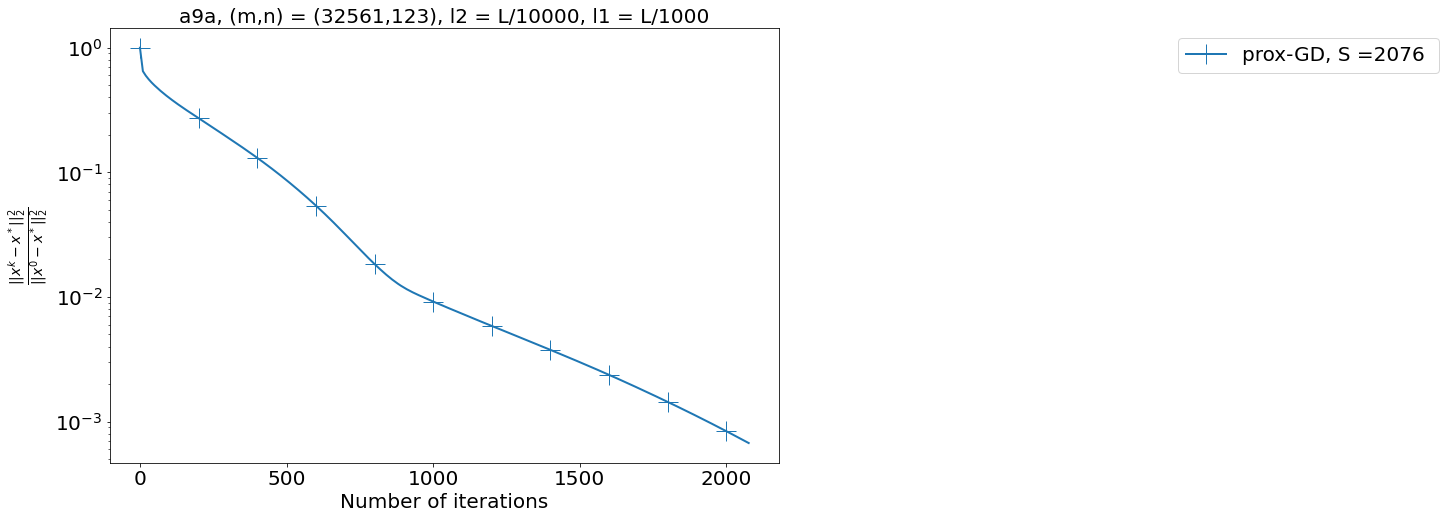

In [59]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [['prox-GD', [gamma, l2, l1, S], f', S ={S} ', None]]
mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in ('time', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

UPD: для нестохастических методов график по числу эпох не имеет смысла

In [60]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
eps = 1e-8
S = int(np.sqrt(L / l2) * np.log((res['func_vals'][0] - f_star + l2 * res['squared_distances'][0]) / eps))
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
            sparse=sparse, l1=l1, S=S, max_t=np.inf,
            save_info_period=save_info_period, 
            x_star=x_star, f_star=f_star)

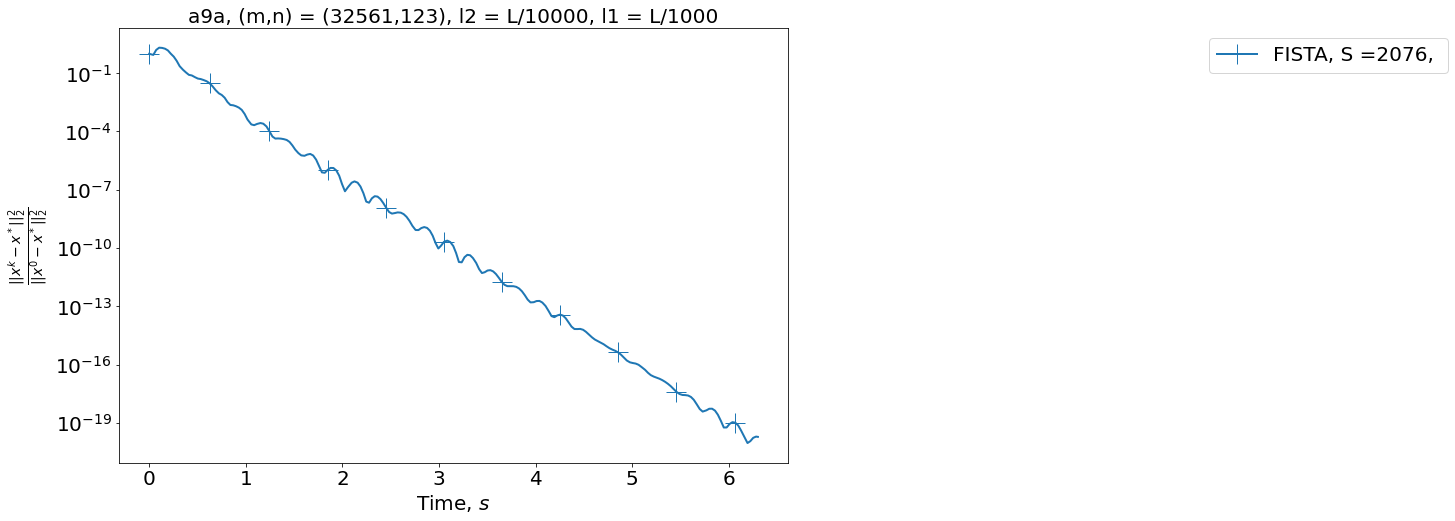

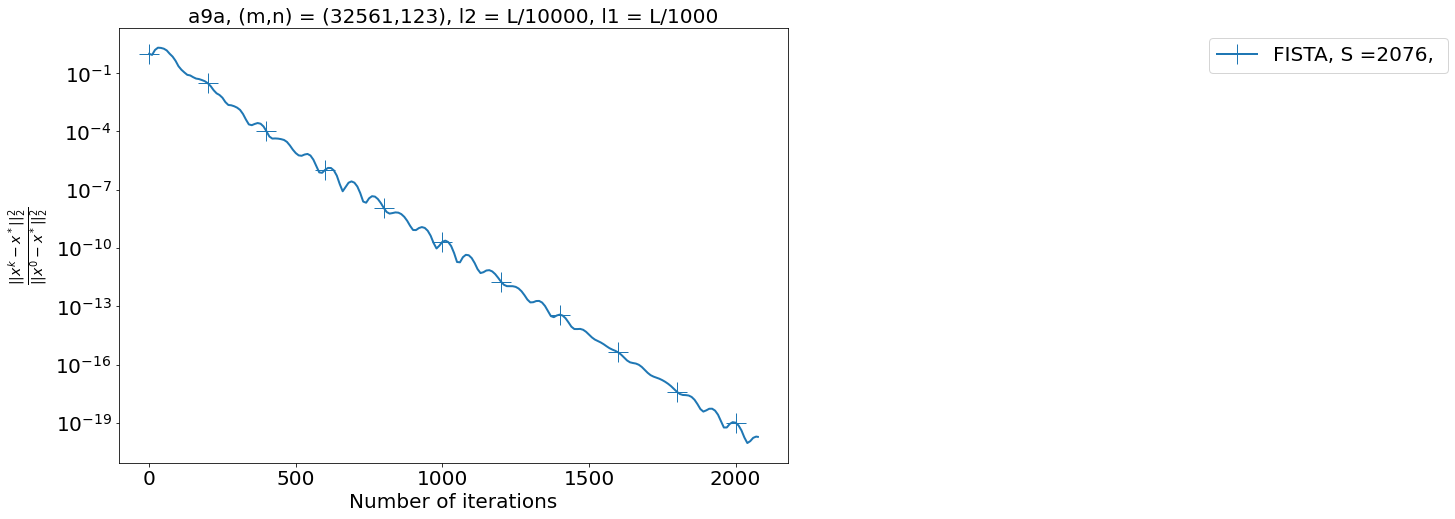

In [61]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [['FISTA', [l2, l1, S], f', S ={S}, ', None]]
mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in ('time', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

FISTA сходится намного быстрее чем prox-GD

In [62]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 20000
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
alpha_array = (1, 0.1, 0.01)

for alpha in alpha_array:
    gamma = alpha/(L+l2)
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse=sparse, l1=l1, S=S, max_t=np.inf,
             save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)

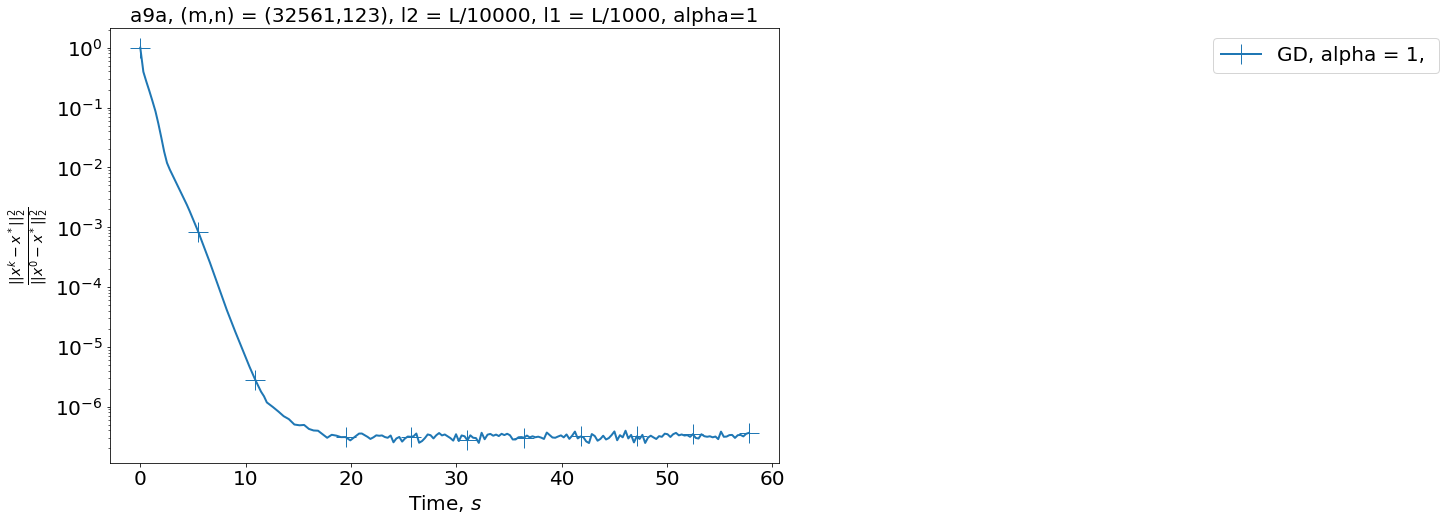

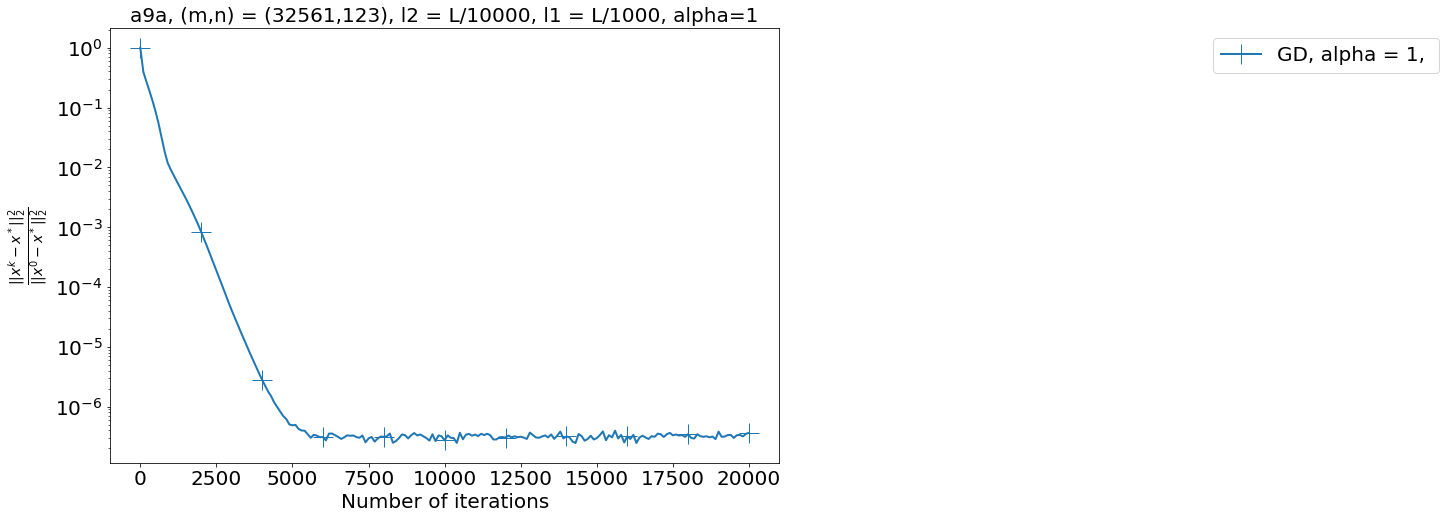

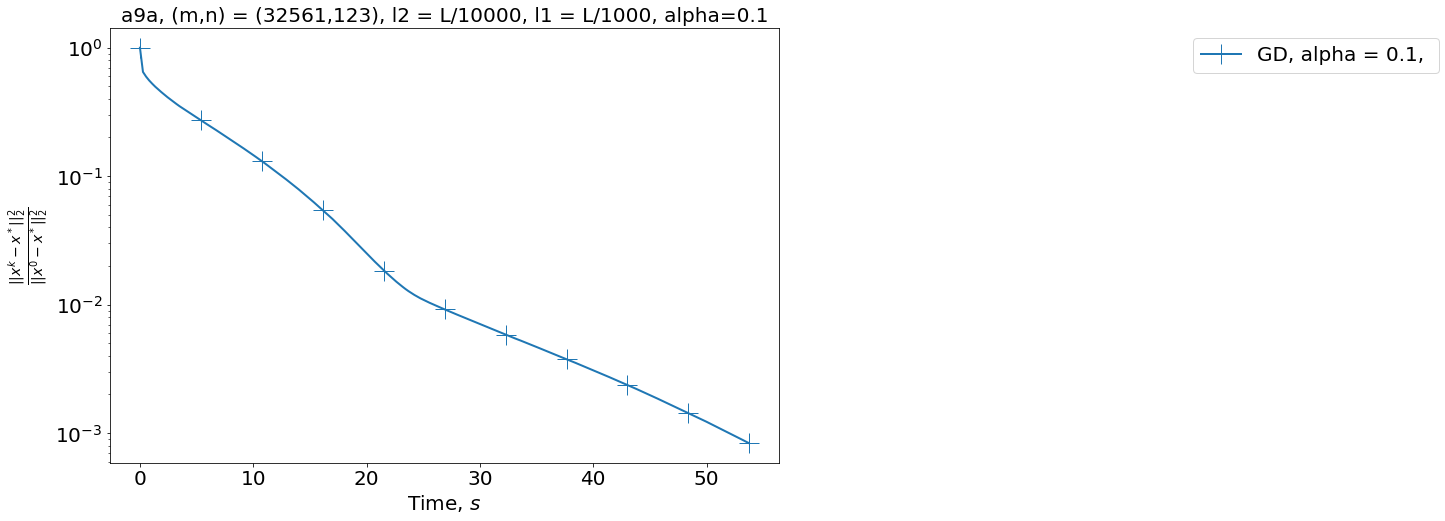

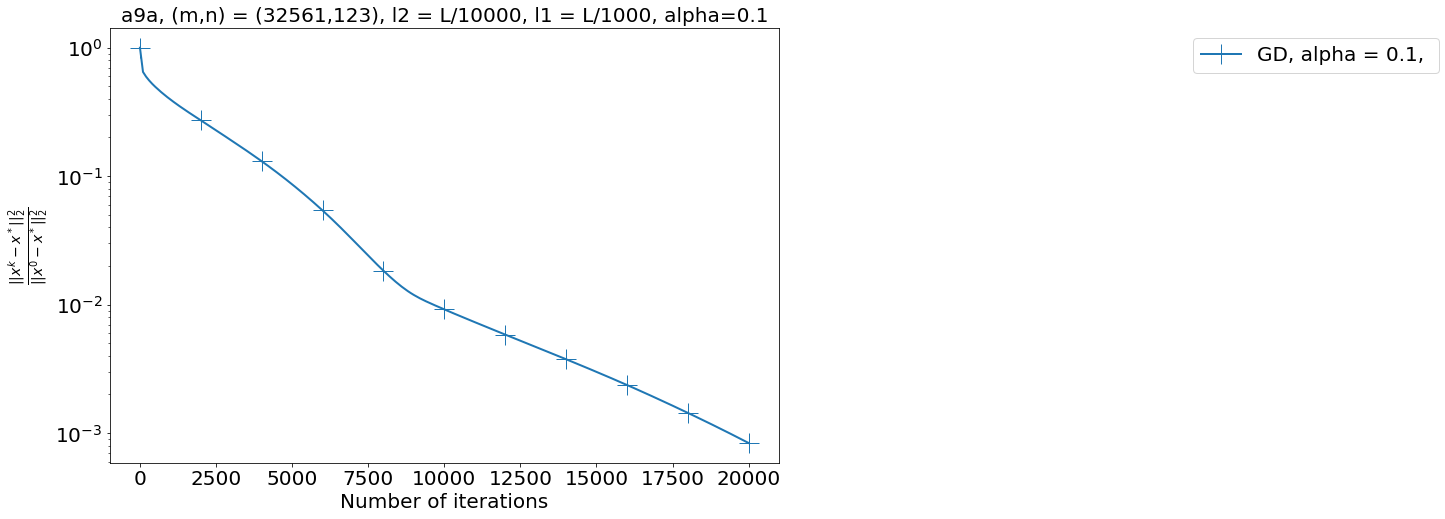

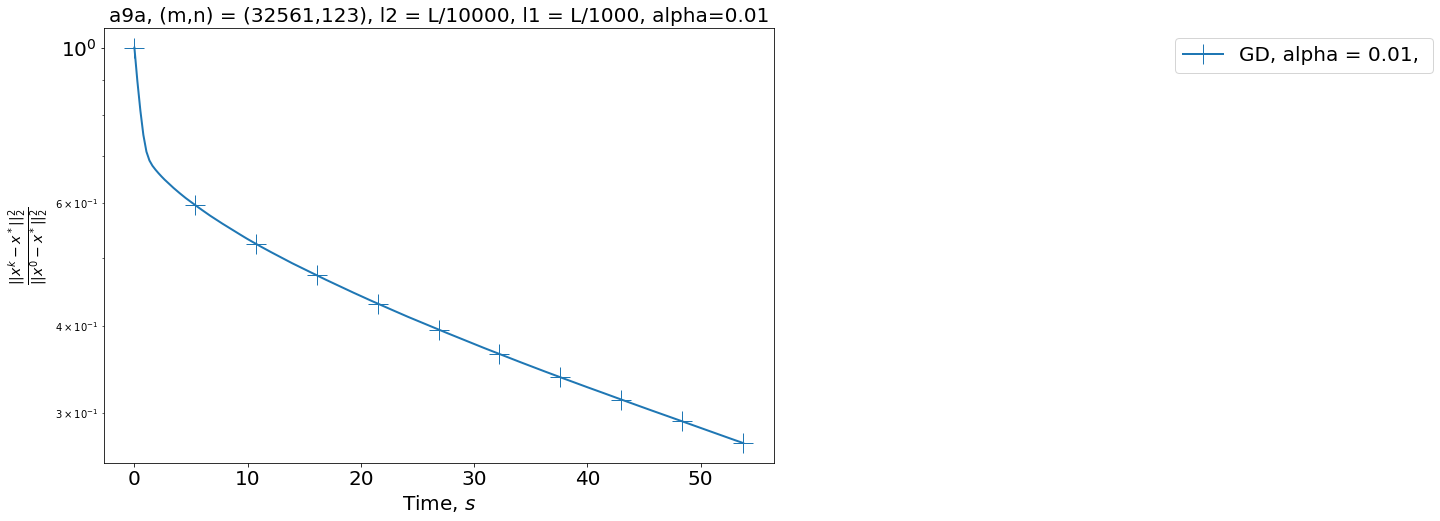

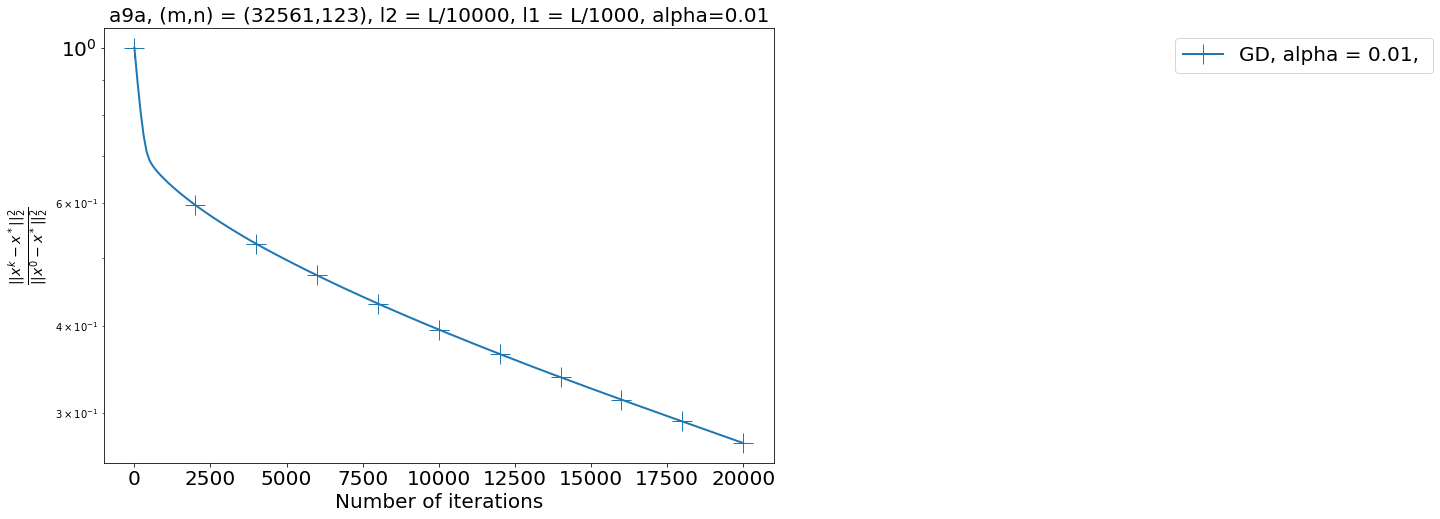

In [63]:
for alpha in alpha_array:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    l2 = L / 10000
    l1 = L / 1000
    methods = [['GD', [alpha/(L+l2), l2, l1, S], f', alpha = {alpha}, ', None]]
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", alpha="+str(alpha)
    
    for mode_x in ('time', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

Чем больше $\alpha$, тем больше точность решения (при равном числе итераций)

## Задание 6. Сравнение методов

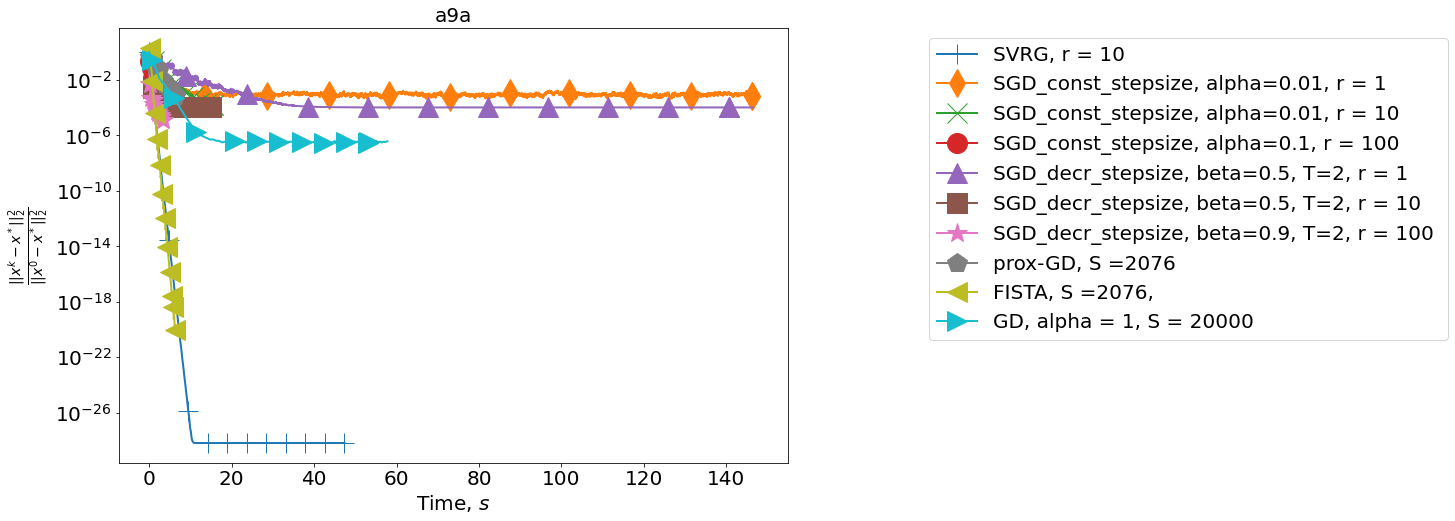

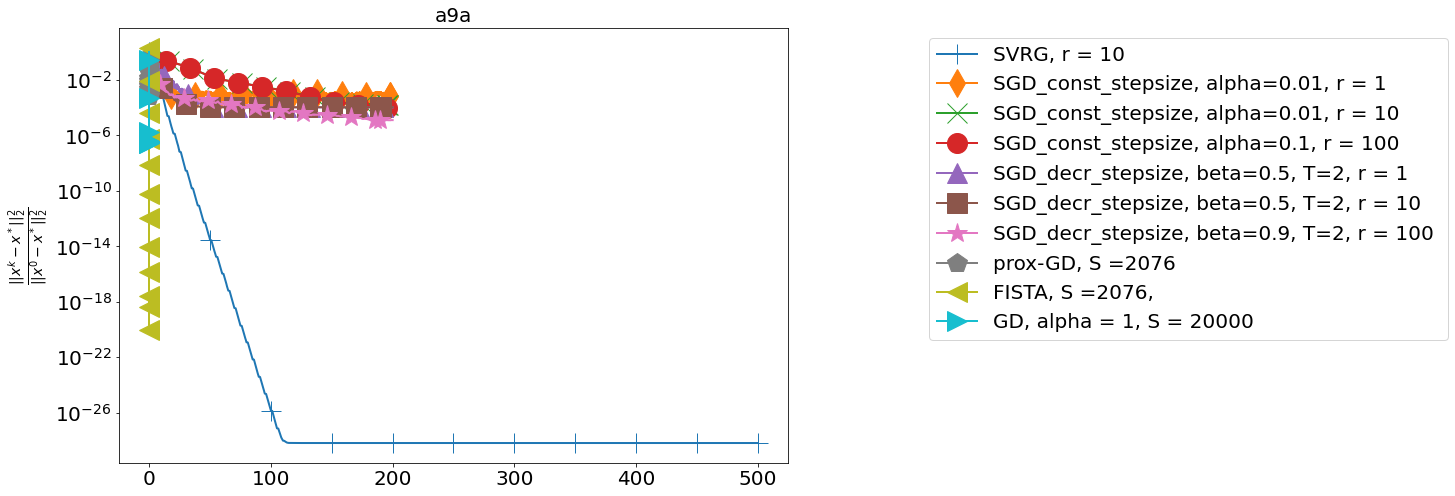

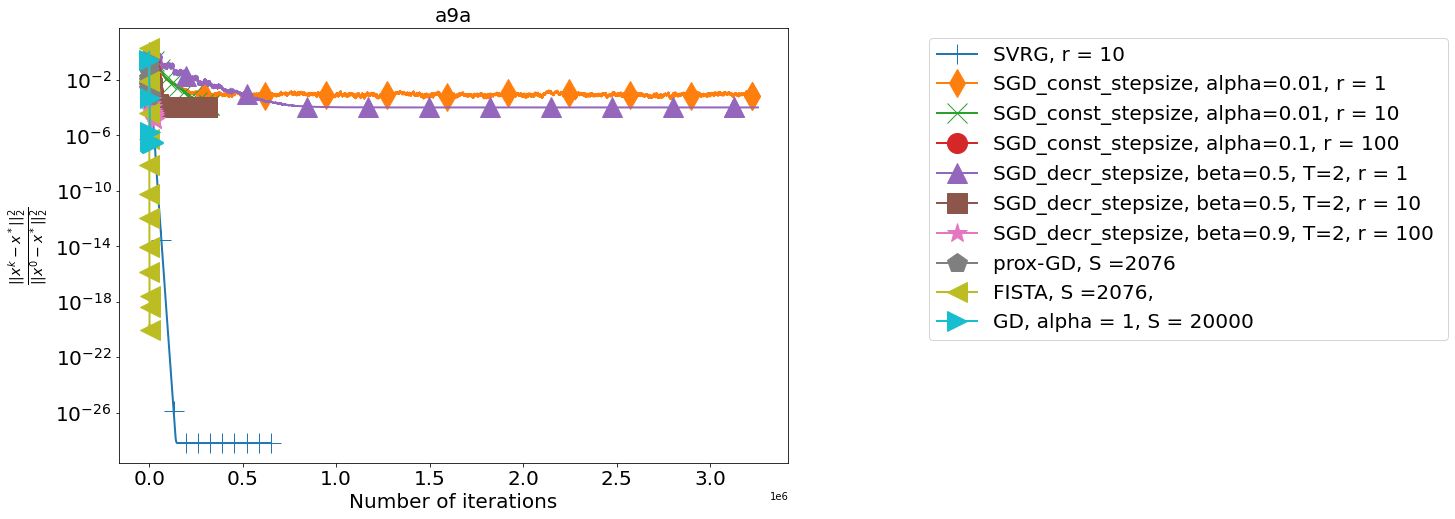

In [64]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [gamma, l2, l1, 100, int(2*m/10), 10], f', r = {10} ', None],
    ['SGD_const_stepsize', [0.01/(L+l2), l2, l1, 100, 1], f', alpha=0.01, r = {1} ', None],
    ['SGD_const_stepsize', [0.01/(L+l2), l2, l1, 100, 10], f', alpha=0.01, r = {10} ', None],
    ['SGD_const_stepsize', [0.1/(L+l2), l2, l1, 100, 100], f', alpha=0.1, r = {100} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 2, 0.5], l2, l1, 100, 1], f', beta=0.5, T=2, r = {1} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 2, 0.5], l2, l1, 100, 10], f', beta=0.5, T=2, r = {10} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 2, 0.9], l2, l1, 100, 100], f', beta=0.9, T=2, r = {100} ', None],
    ['prox-GD', [1/L, l2, l1, 2076], f', S ={2076} ', None],
    ['FISTA', [l2, l1, 2076], f', S ={2076}, ', None],
    ['GD', [1/(L+l2), l2, l1, 20000], f', alpha = {1}, S = 20000 ', None]
]
mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset

for mode_x in ('time', 'data_passes', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

На данной задаче лучшую точность решения имеет SVRG, затем FISTA и GD

## Задание 7. Эксперименты с другим датасетом

In [65]:
dataset = "a5a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A)
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  6414 , размерность задачи:  122
Константа гладкости всей функции:  1.5740271677041664
Средняя константа гладкости     :  3.466596507639382
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11365890188982093


In [66]:
filename=dataset+"_x_init_all_ones"

l2 = L / 10000
l1 = L / 1000

test_indices = None
l1_array = (L / 100000, L / 10000, L / 1000)
batch_array = (1, 10, 100)
alpha_array = (1, 0.1, 0.01)
T_array = (1, 2)
beta_array = (0.5, 0.9)

In [67]:
x_init = np.ones(n)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 1000
batch_size = 10
save_info_period = 100
sparse_full = False
sparse_stoch = False

for l1_ in l1_array:
    M = int(2*m/batch_size)
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
               sparse_full=sparse_full, sparse_stoch=sparse_stoch,
               l1=l1_, S=S, M=M, max_t=np.inf,
               batch_size=batch_size, indices=None, save_info_period=save_info_period, 
               x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1_, res['last_iter'], res['func_vals'][-1])

In [68]:
x_init = np.ones(n)
gamma = 1.0/(6*(L+l2))
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False

for l1_ in l1_array:
    x_star = read_solution(dataset, l2, l1_)[0]
    f_star = read_solution(dataset, l2, l1_)[1]

    for batch_size in batch_array:
        M = int(2*m/batch_size)
        res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
                   sparse_full=sparse_full, sparse_stoch=sparse_stoch,
                   l1=l1_, S=S, M=M, max_t=np.inf,
                   batch_size=batch_size, indices=None, save_info_period=save_info_period, 
                   x_star=x_star, f_star=f_star)

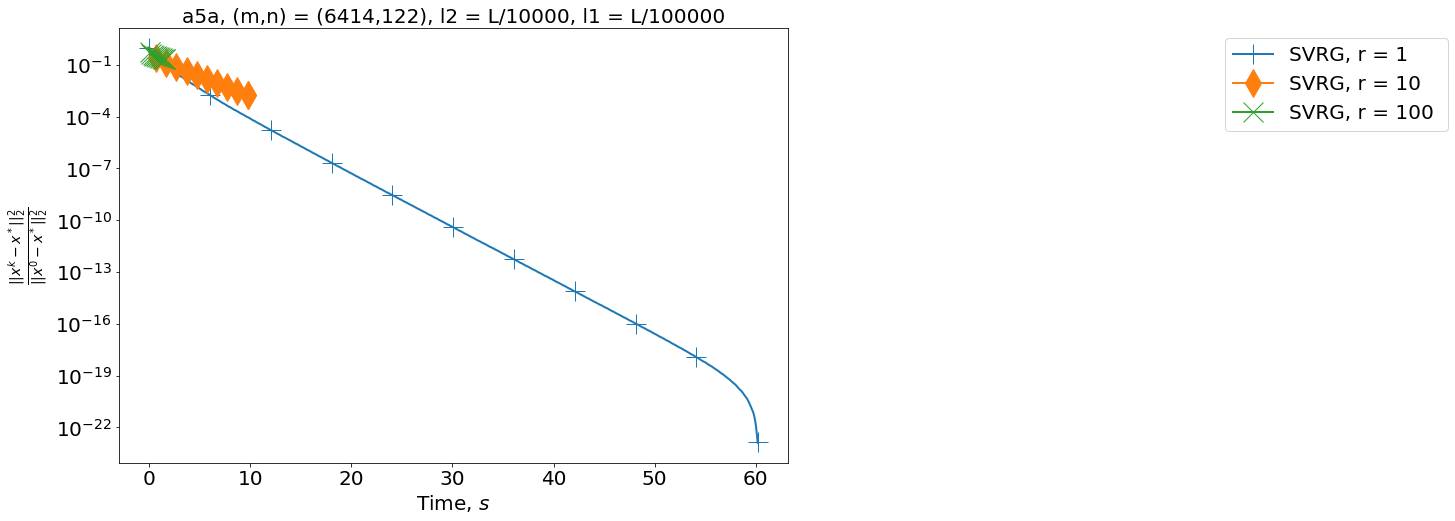

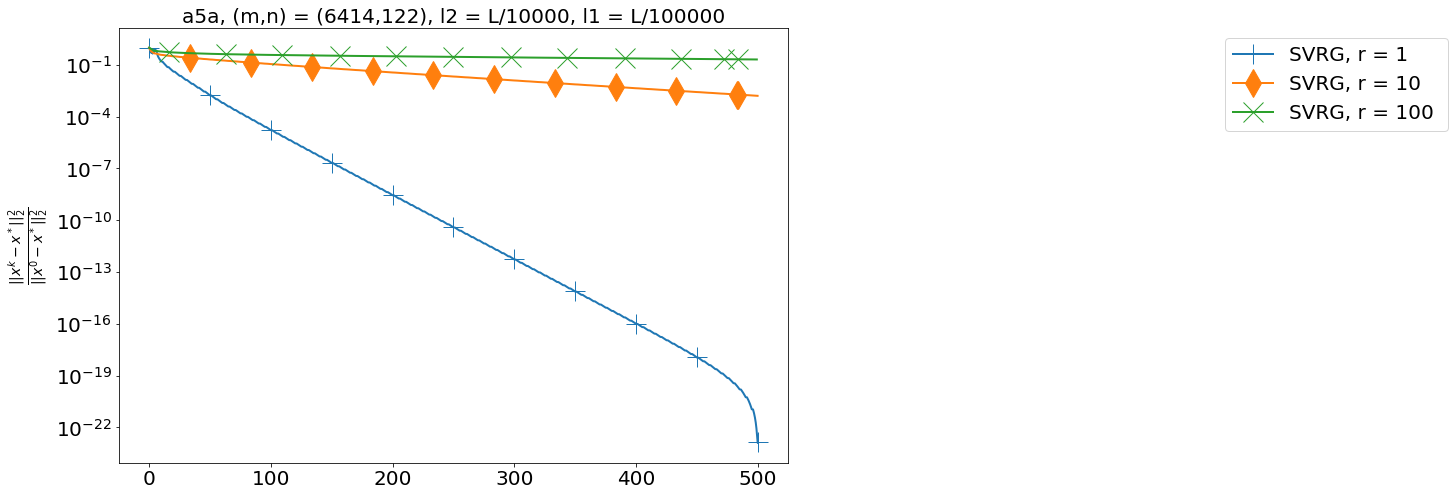

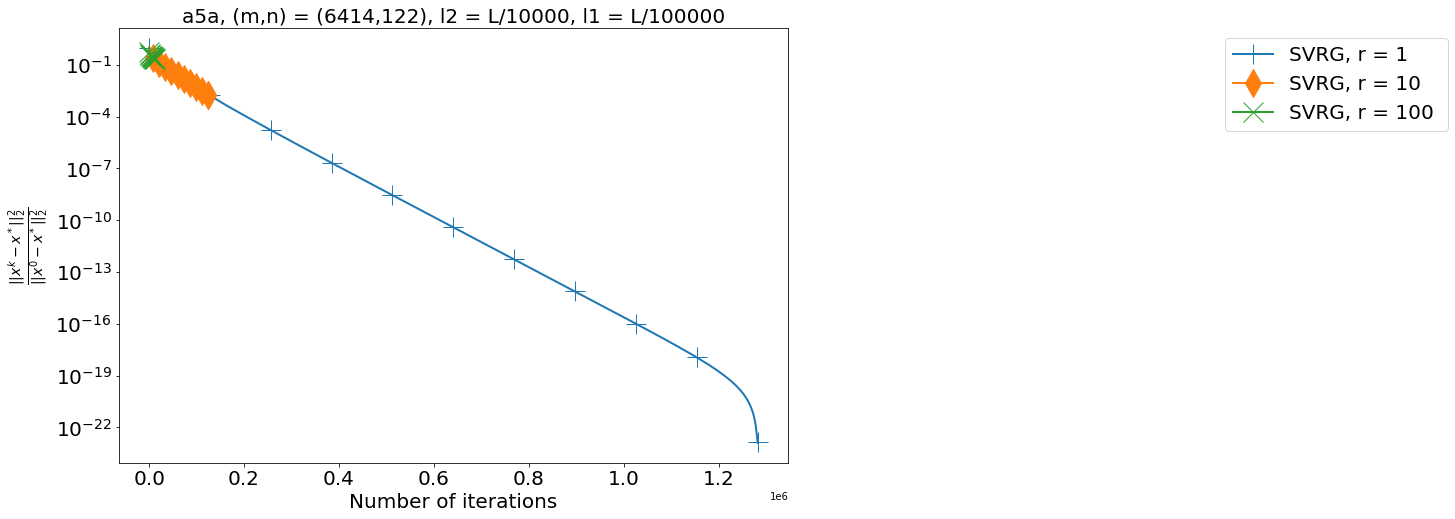

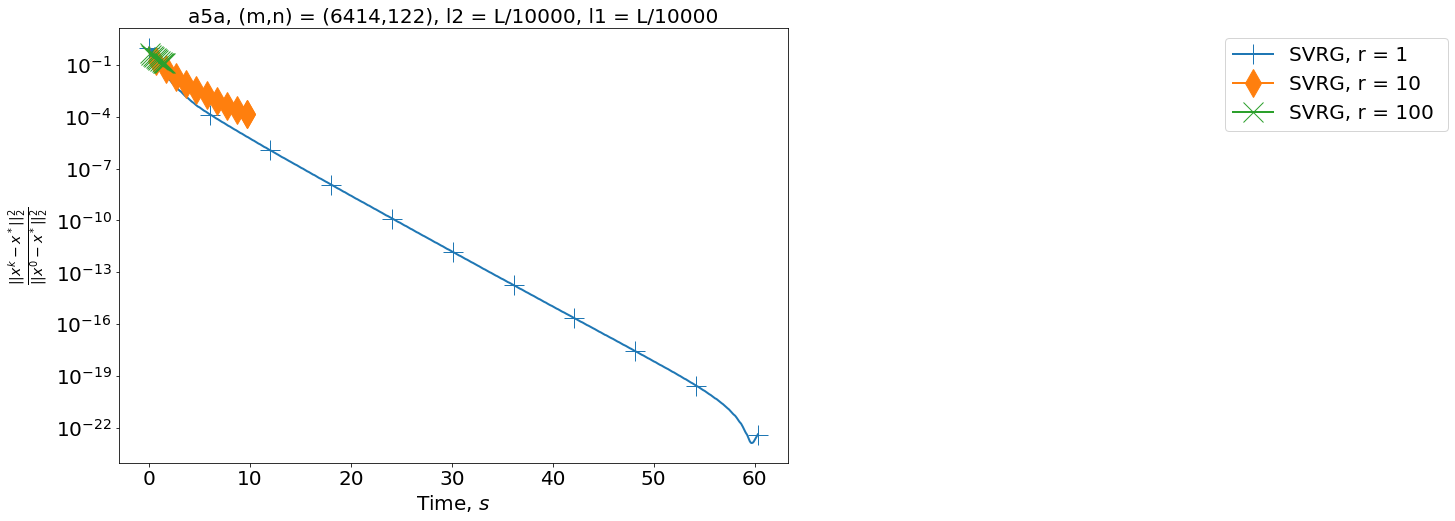

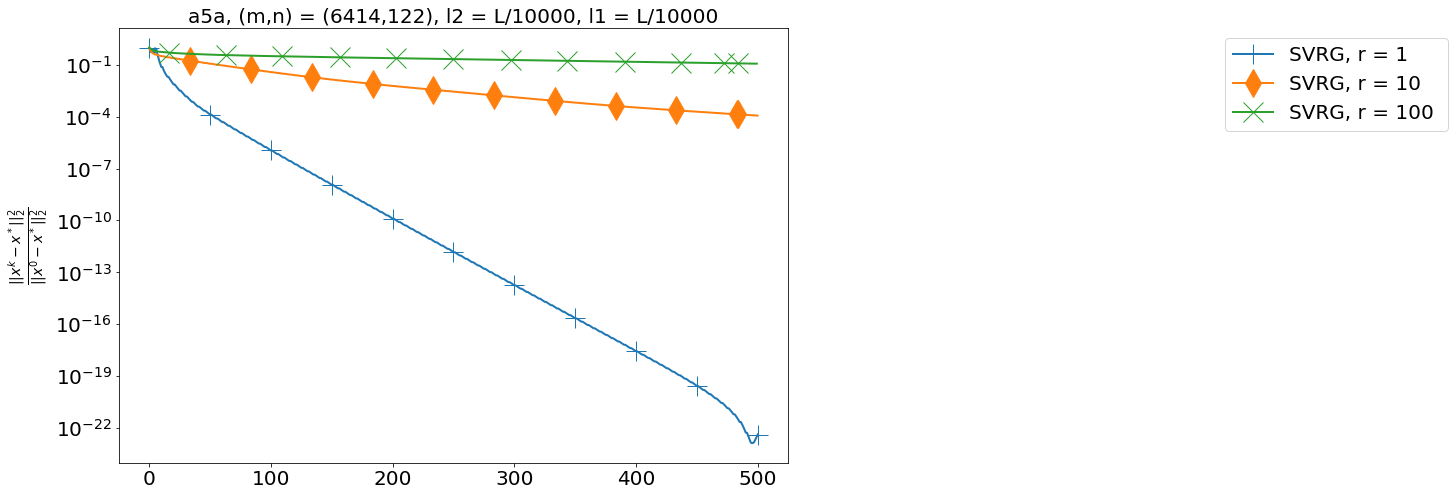

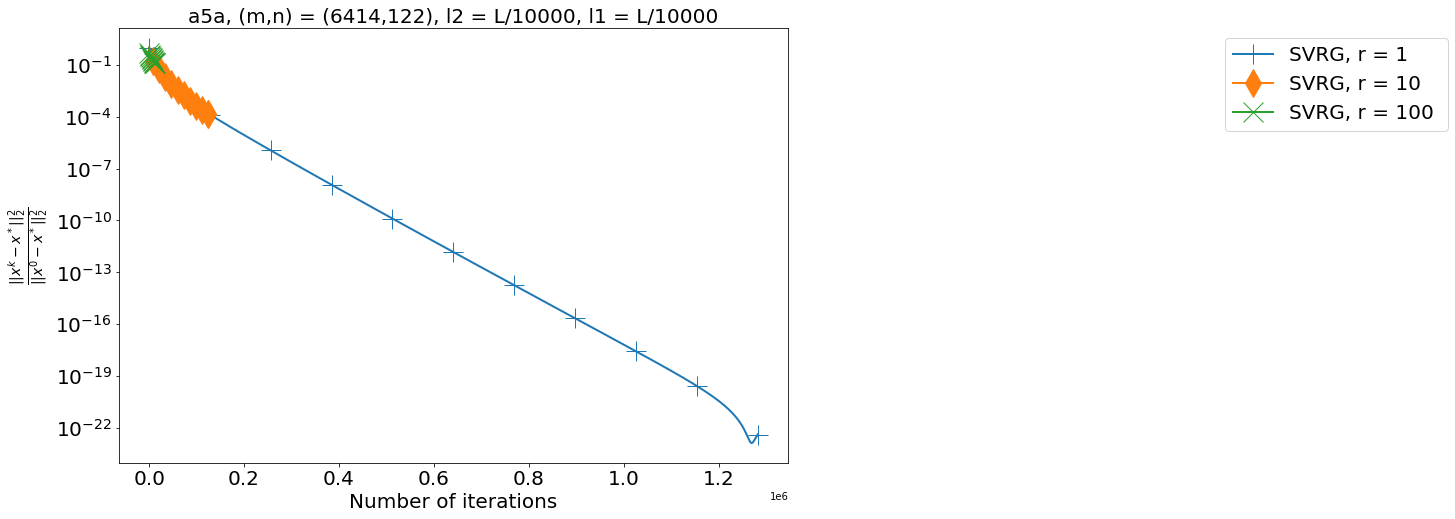

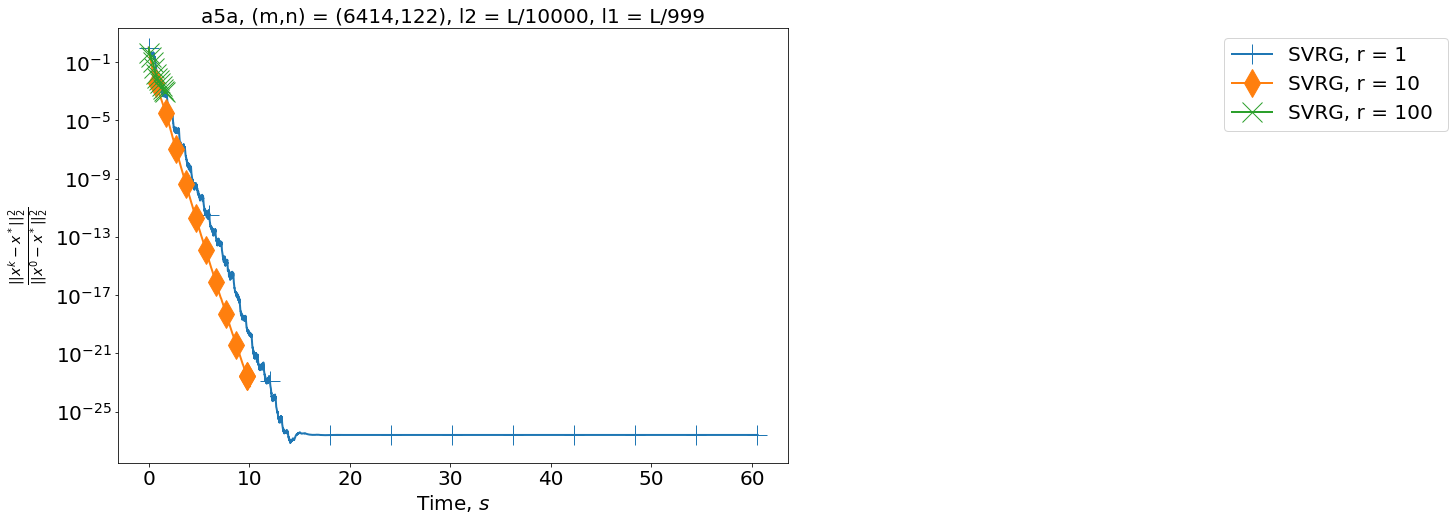

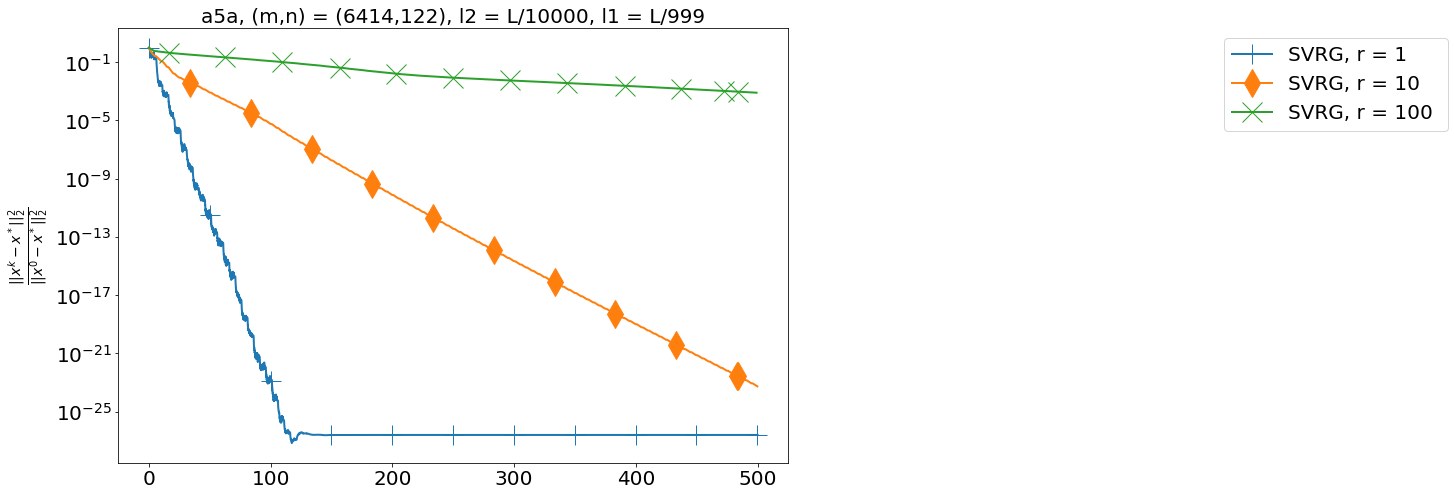

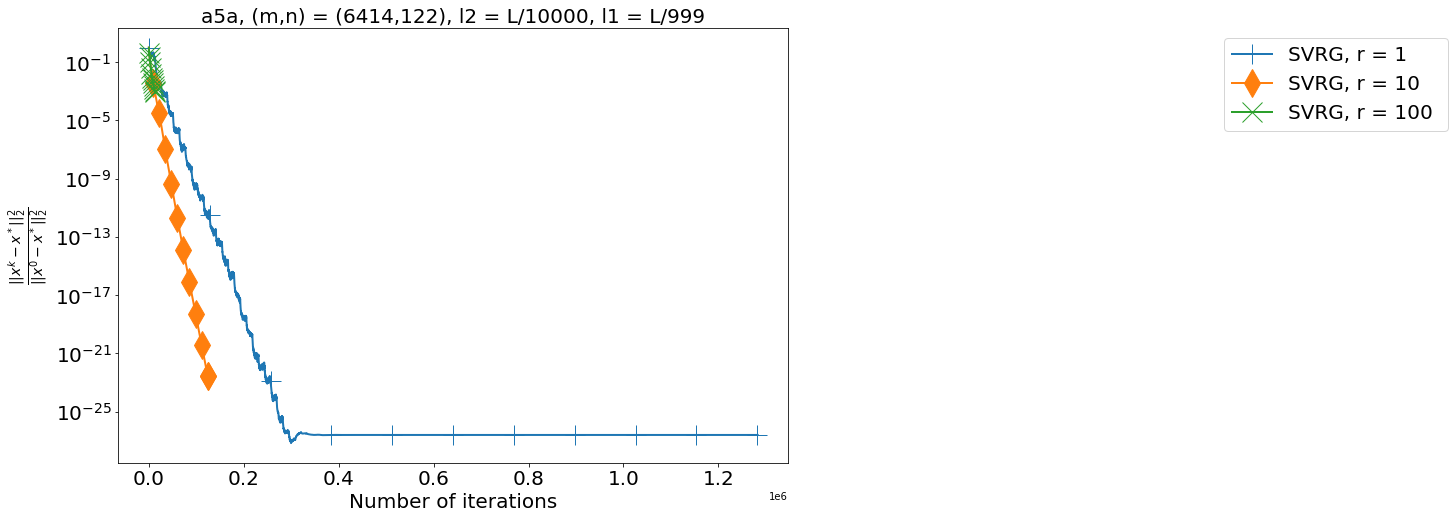

In [69]:
for l1_ in l1_array:
    gamma = 1.0/(6*(L+l2))
    methods = []
    for batch_size in batch_array:
        methods.append(['SVRG', [gamma, l2, l1_, S, int(2*m/batch_size), batch_size], f', r = {batch_size} ', None])
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    l1_string = "0" if l1_ == 0 else "L/"+str(int(L/l1_))
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = "+l1_string

    for mode_x in ('time', 'data_passes', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

In [70]:
x_init = np.ones(n)
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
for alpha in alpha_array:
    for batch_size in batch_array:
        M = int(2*m/batch_size)
        gamma = alpha/(L+l2)
        res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
                                 sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                 l1=l1, S=S, max_t=np.inf,
                                 batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                 x_star=x_star, f_star=f_star)

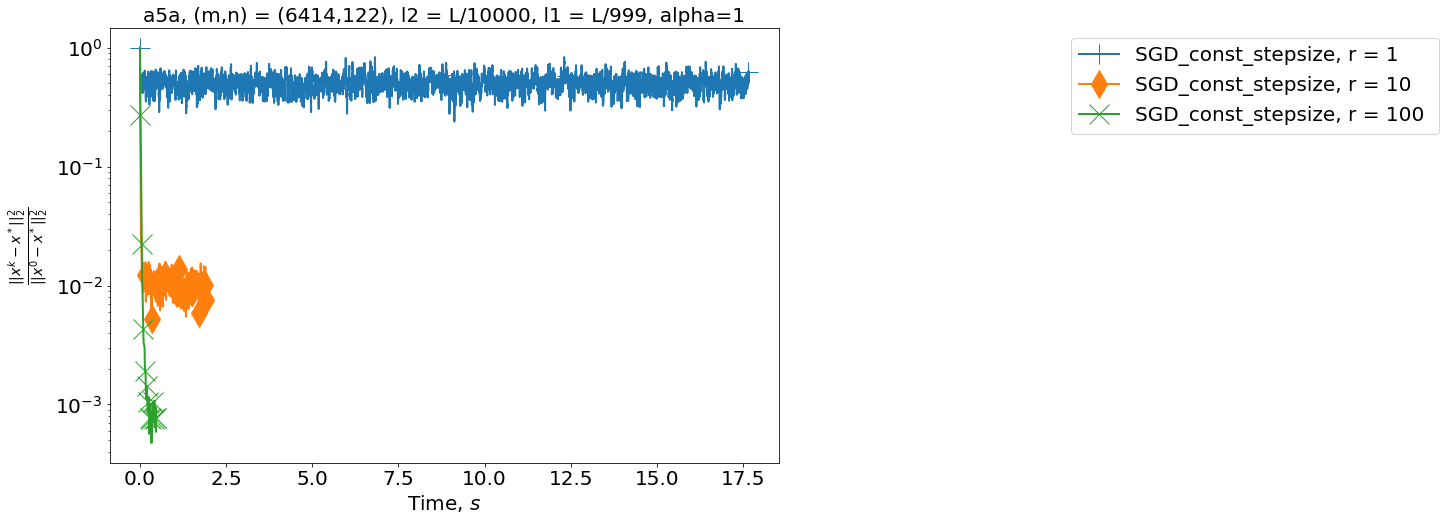

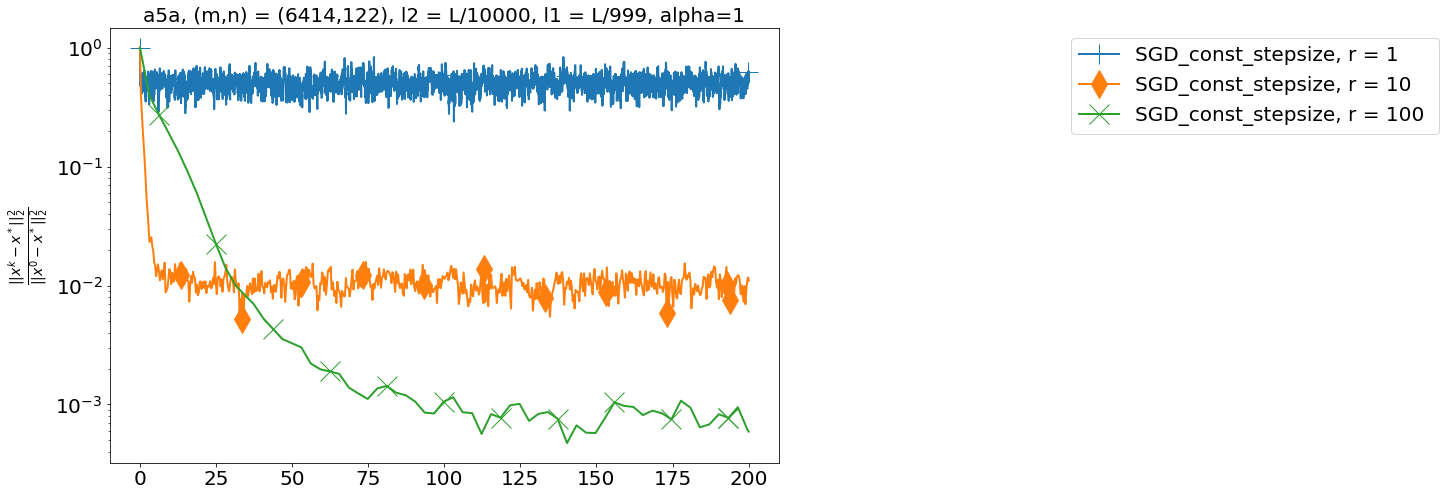

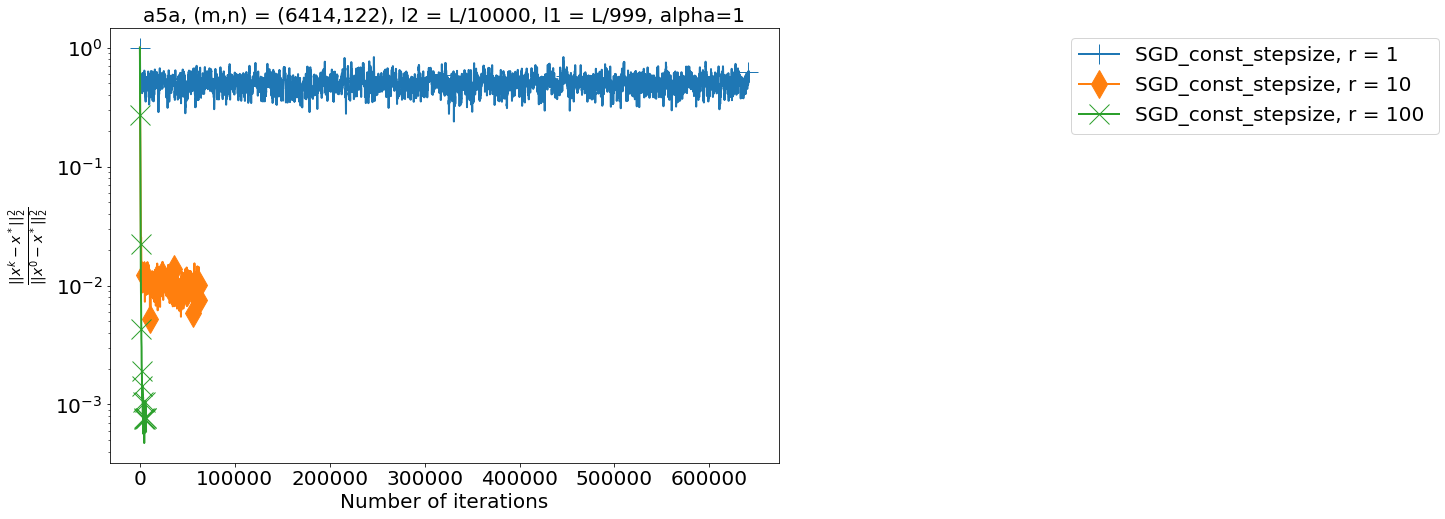

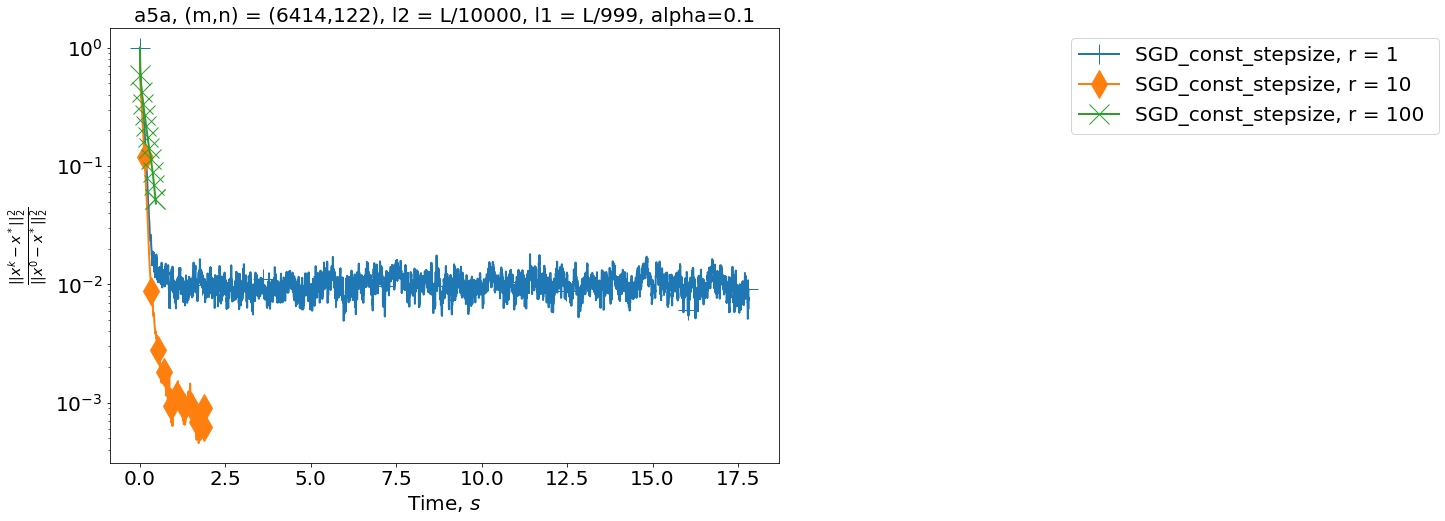

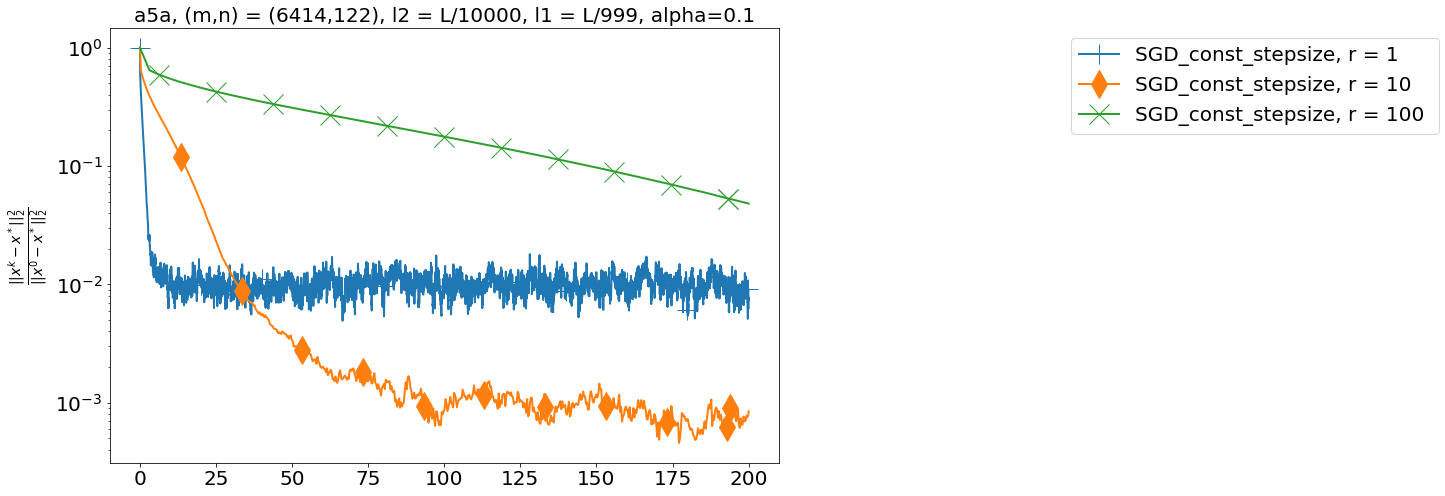

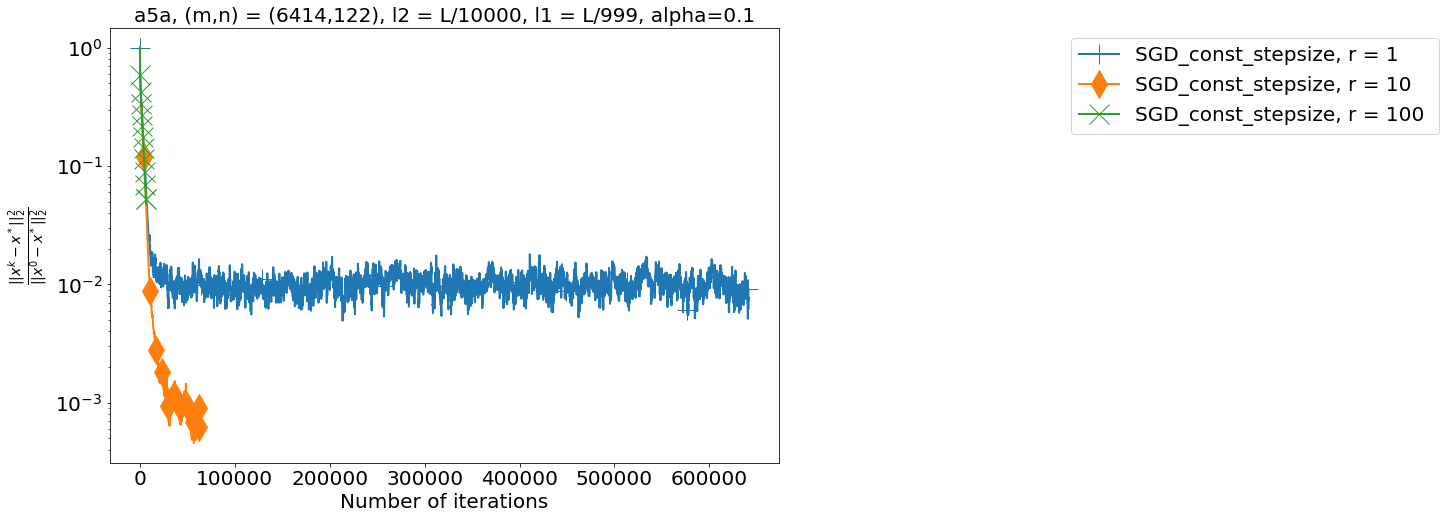

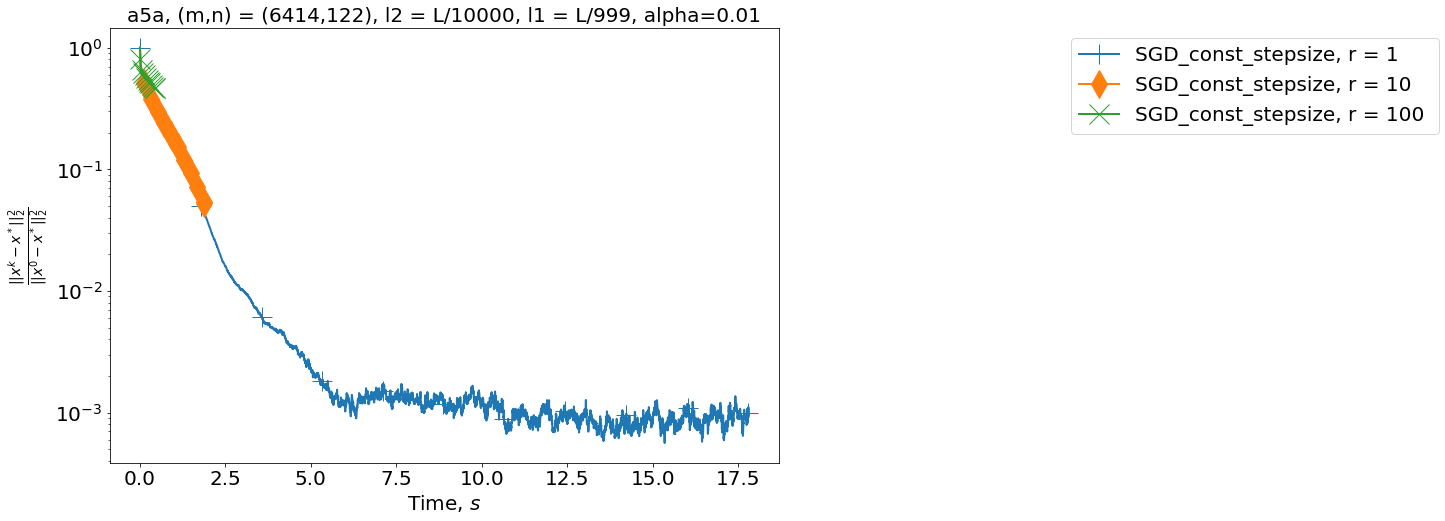

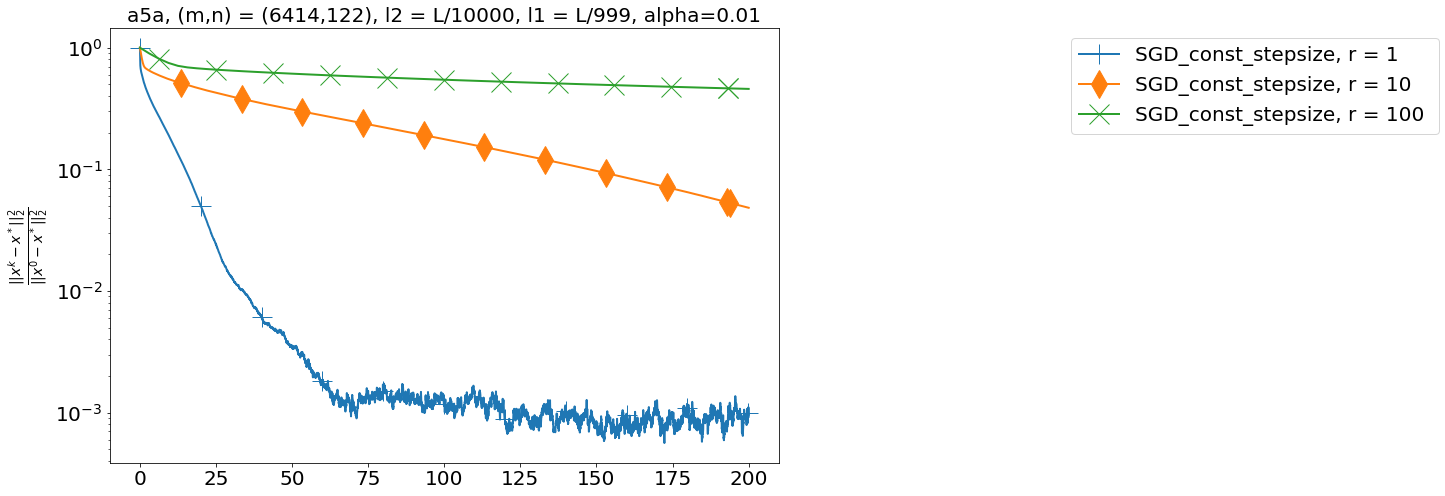

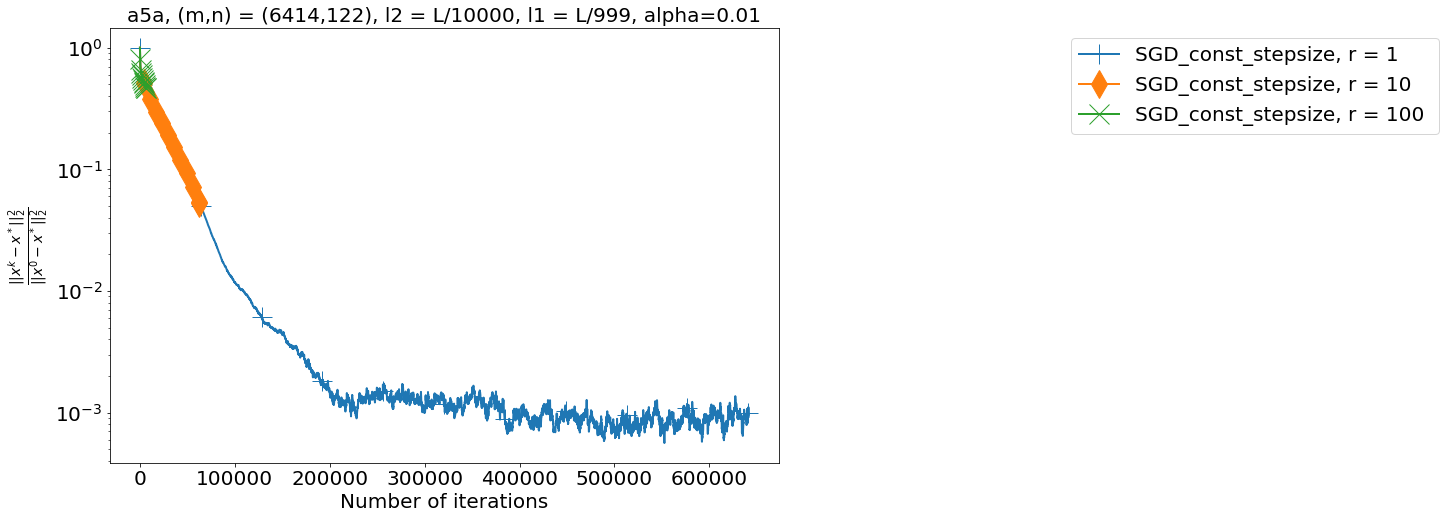

In [71]:
for alpha in alpha_array:
    methods = []
    for batch_size in batch_array:
        methods.append(['SGD_const_stepsize', [alpha/(L+l2), l2, l1, S, batch_size], f', r = {batch_size} ', None])
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", alpha="+str(alpha)
    
    for mode_x in ('time', 'data_passes', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

In [72]:
x_init = np.ones(n)
gamma = 1/(L+l2)
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 100
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
for T in T_array:
    for beta in beta_array:
        for batch_size in batch_array:
            M = int(2*m/batch_size)
            gamma_schedule = [gamma, T, beta]
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                                    sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                    l1=l1, S=S, max_t=np.inf,
                                    batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                    x_star=x_star, f_star=f_star)

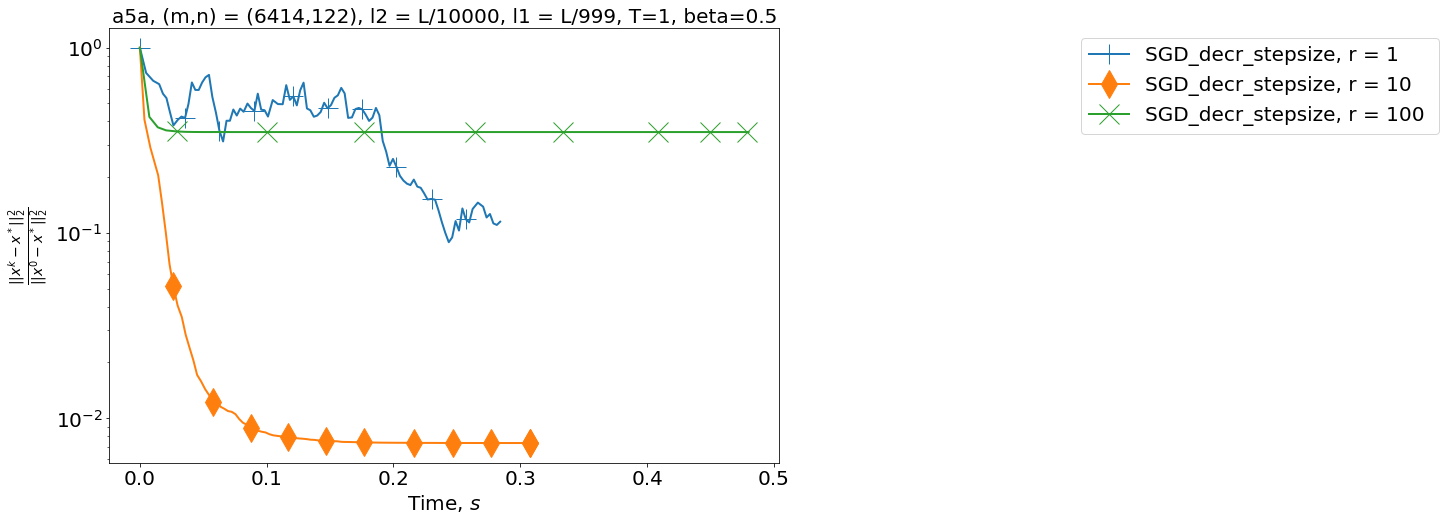

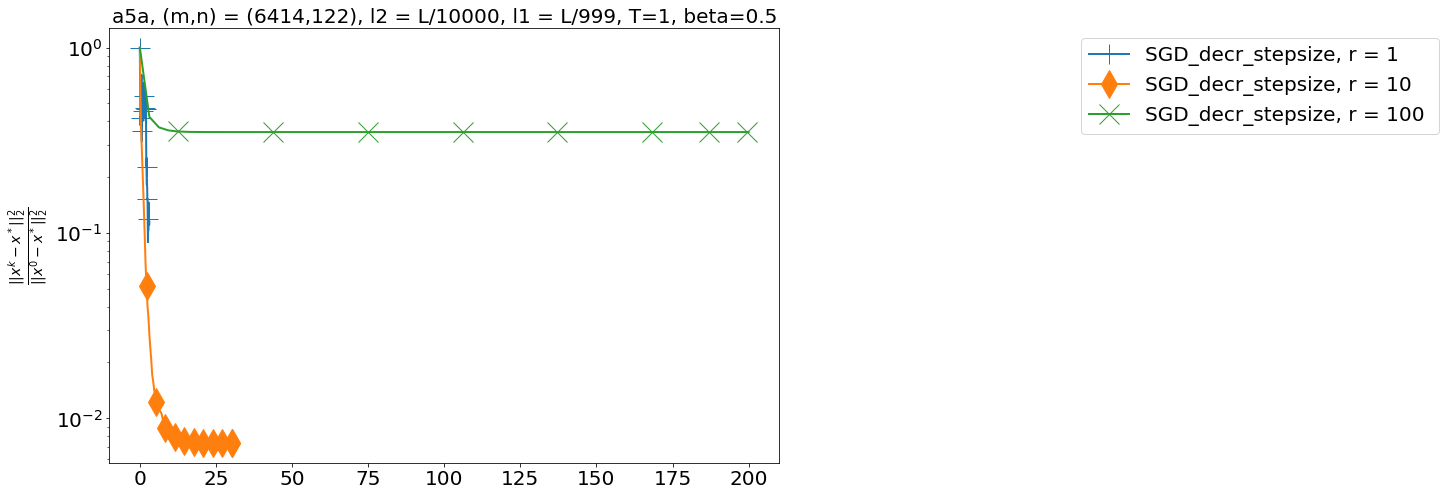

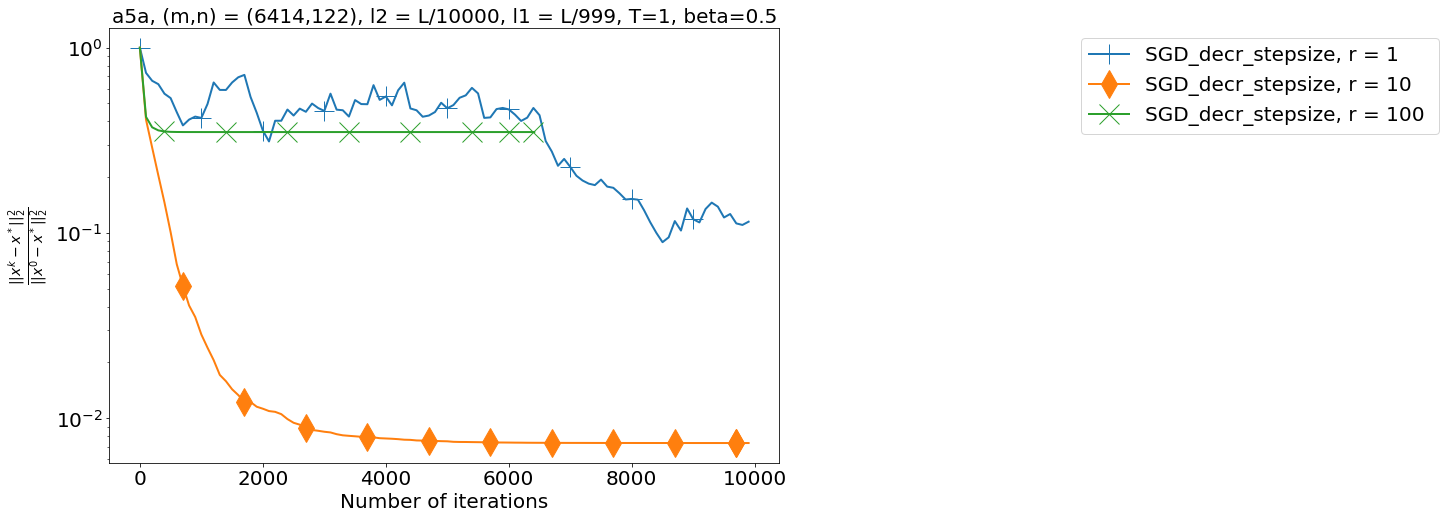

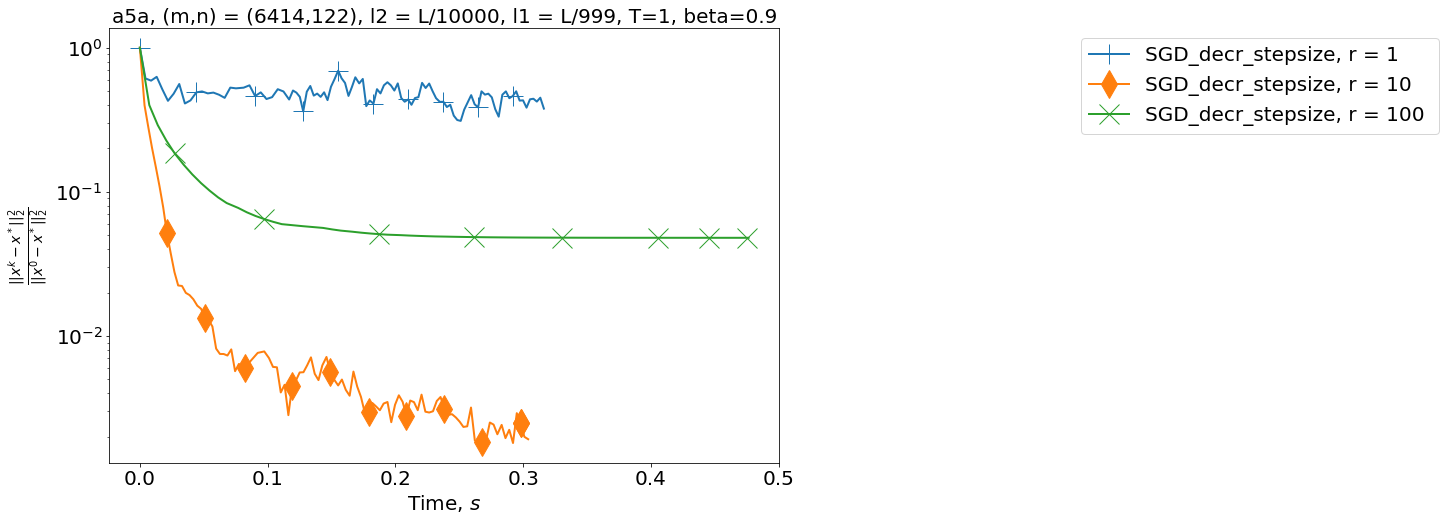

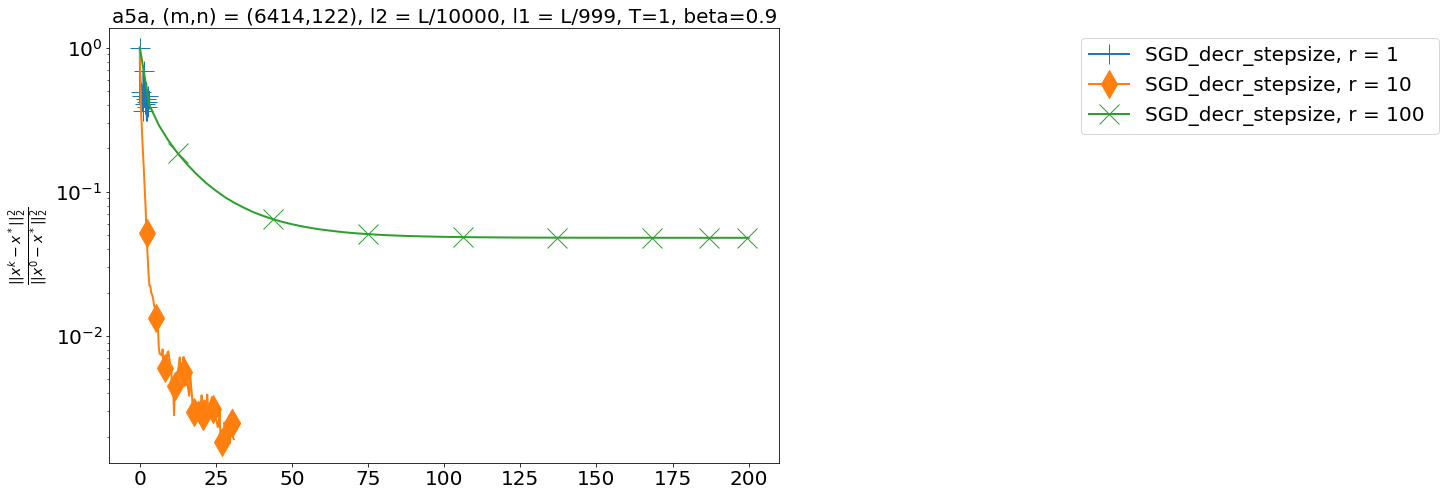

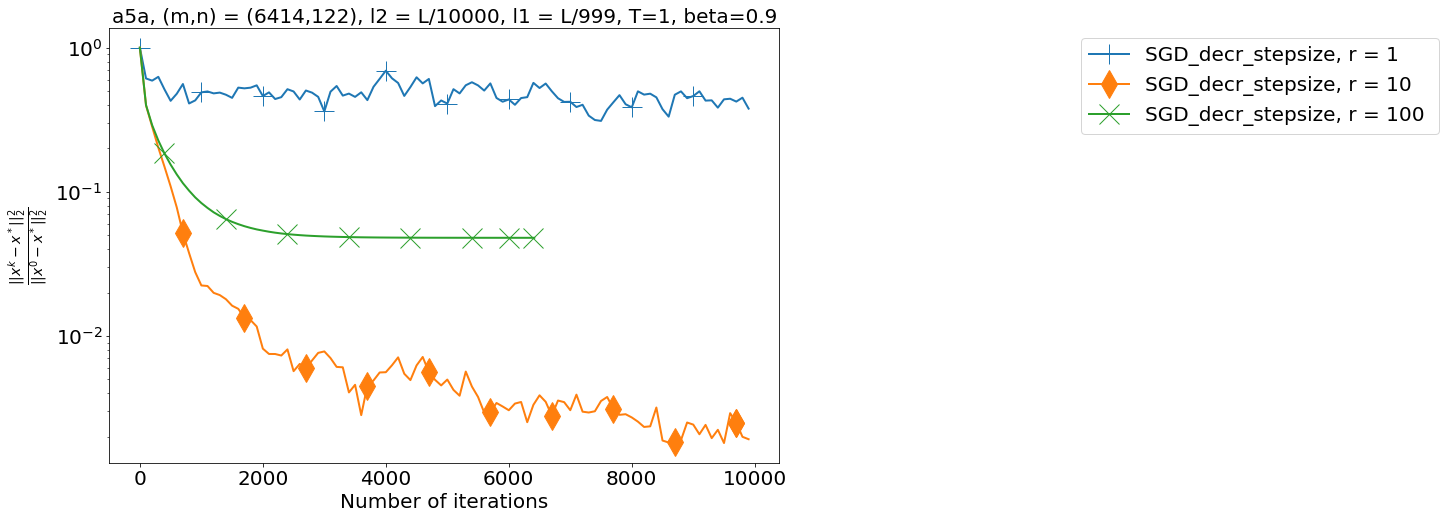

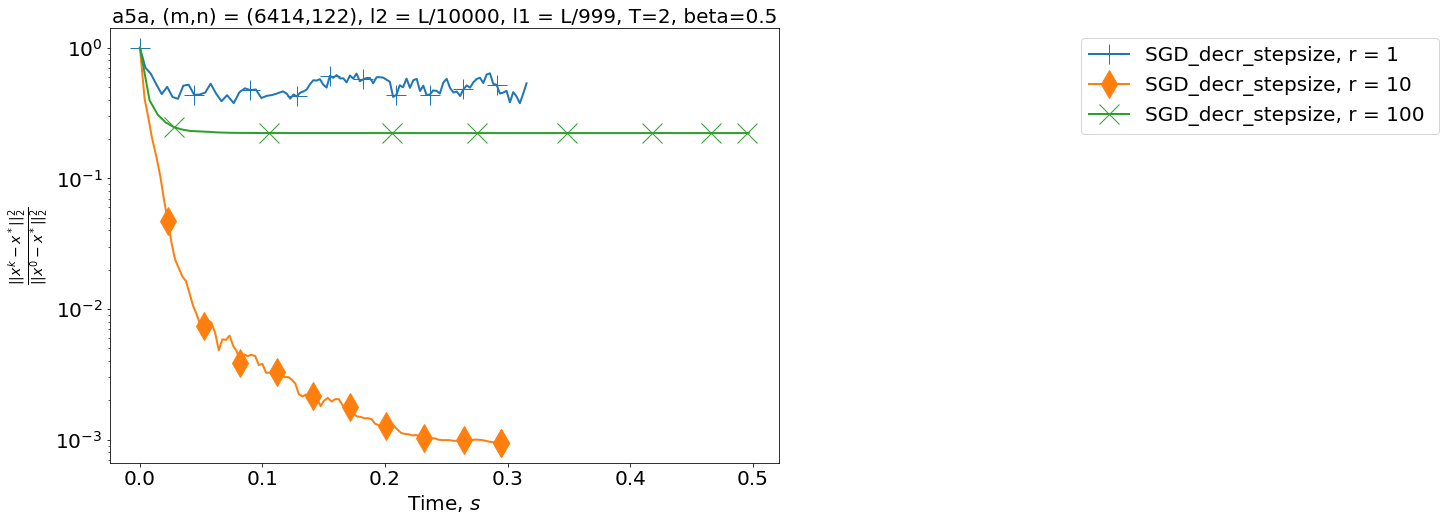

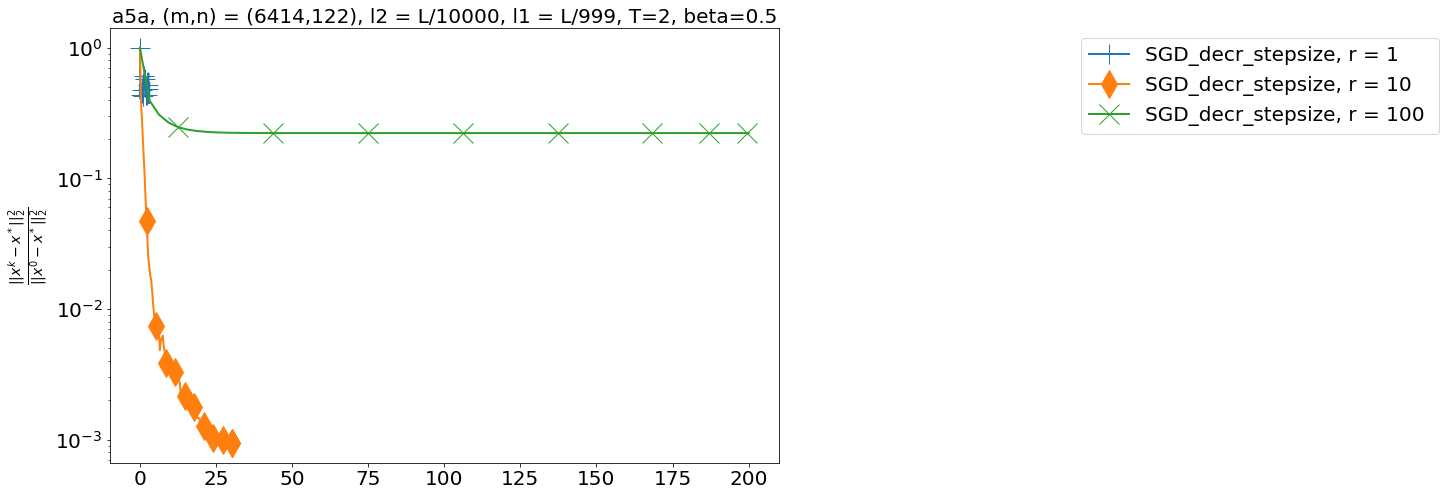

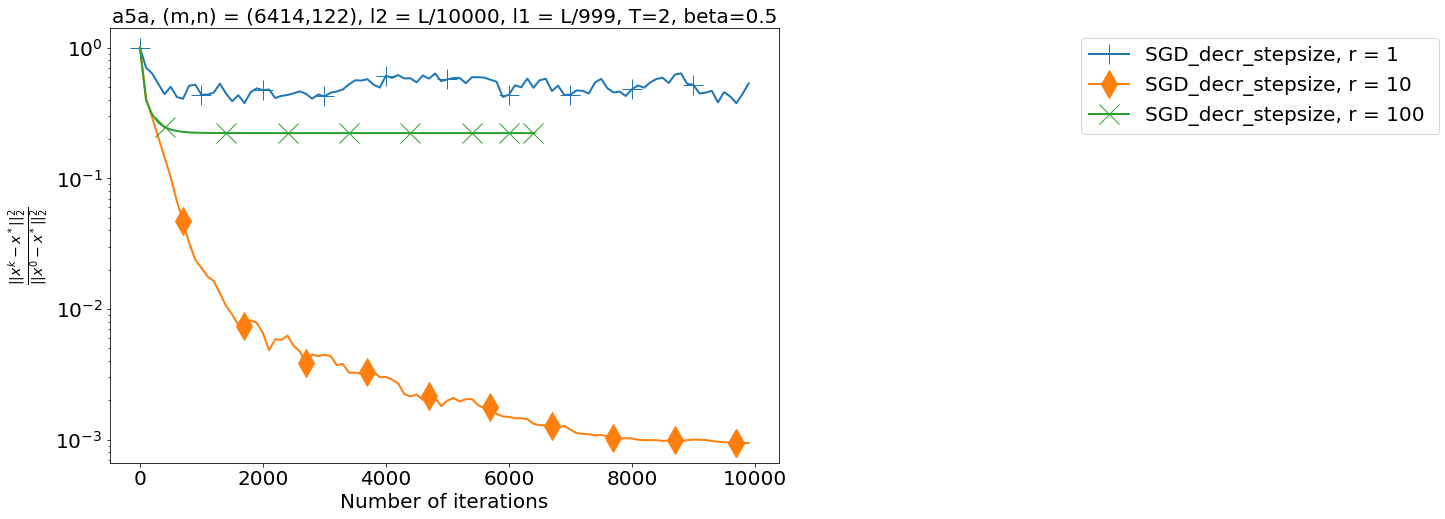

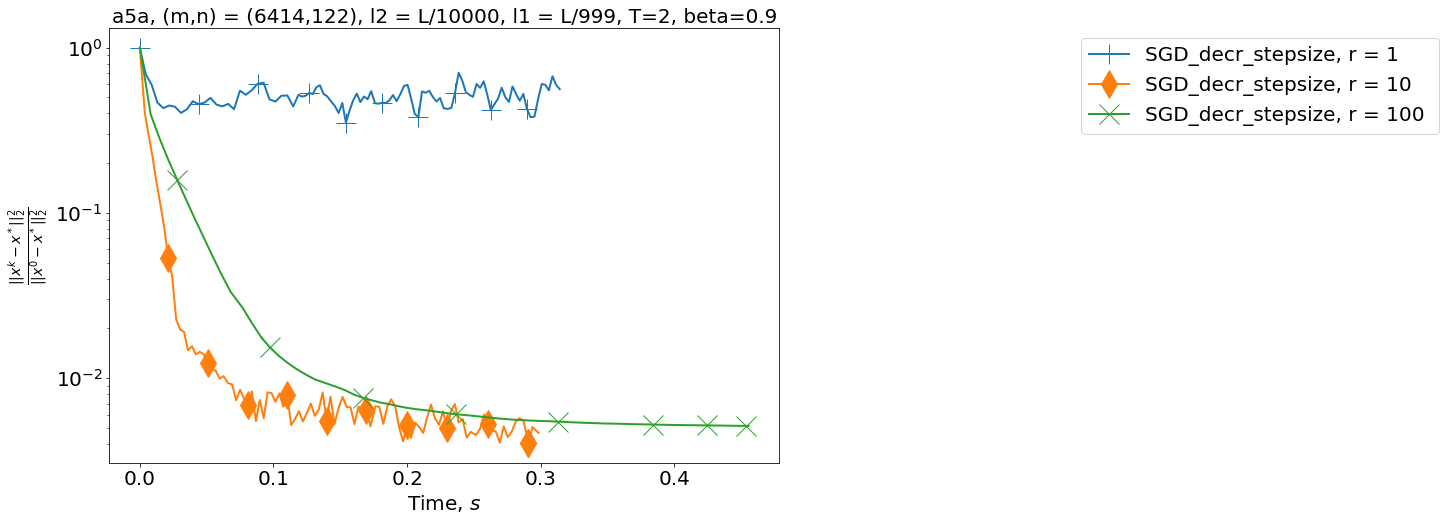

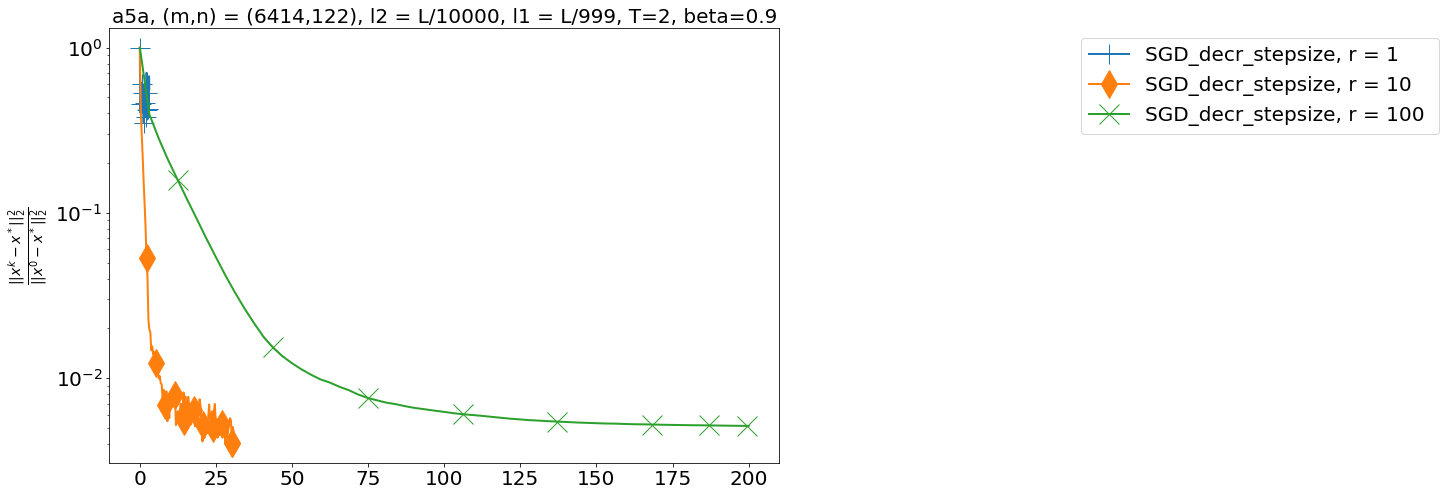

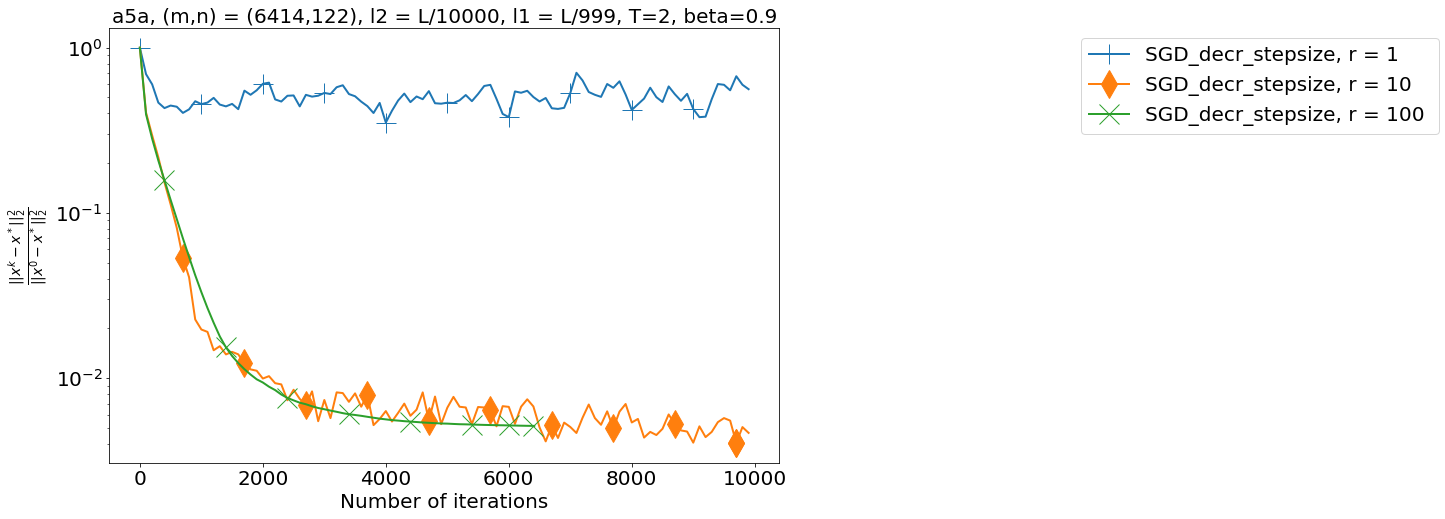

In [73]:
for T in T_array:
    for beta in beta_array:
        gamma = 1/(L+l2)
        methods = []
        for batch_size in batch_array:
            methods.append(['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, batch_size], f', r = {batch_size} ', 100])
        mode_y = 'squared_distances'
        figsize = (12, 8)
        fontsize = 20
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", T="+str(T)+", beta="+str(beta)

        for mode_x in ('time', 'data_passes', 'iters'):
            args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
            make_plots(args=args_for_plots)
            plt.show()

In [74]:
x_init = np.ones(n)
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
gamma = 1 / L
eps = 1e-8
S = int(np.sqrt(L / l2) * np.log((res['func_vals'][0] - f_star + l2 * res['squared_distances'][0]) / eps))
save_info_period = 10
sparse = True
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
              sparse=sparse, l1=l1, S=S, max_t=np.inf,
              save_info_period=save_info_period, 
              x_star=x_star, f_star=f_star)

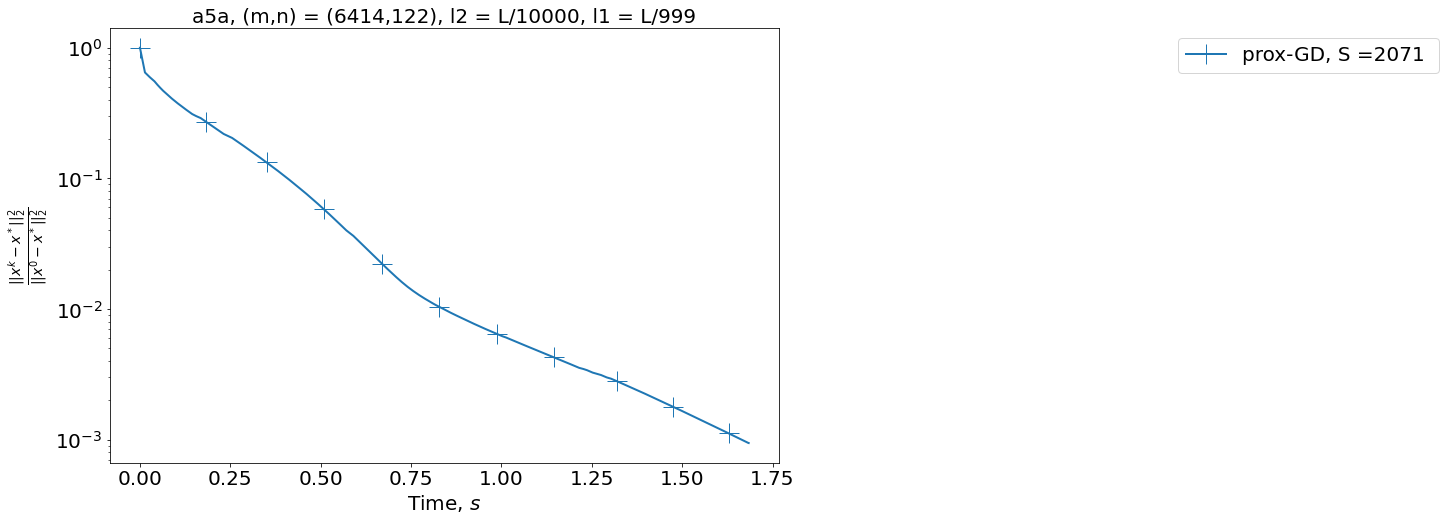

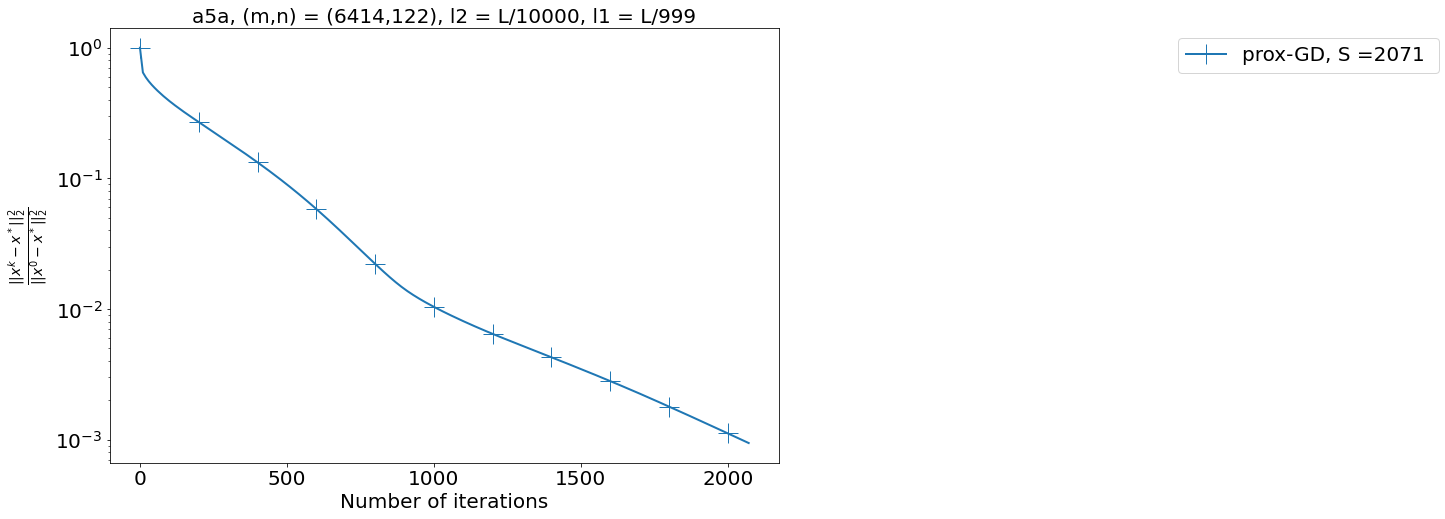

In [75]:
methods = [['prox-GD', [gamma, l2, l1, S], f', S ={S} ', None]]
mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in ('time', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

In [76]:
x_init = np.ones(n)
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
eps = 1e-8
S = int(np.sqrt(L / l2) * np.log((res['func_vals'][0] - f_star + l2 * res['squared_distances'][0]) / eps))
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
            sparse=sparse, l1=l1, S=S, max_t=np.inf,
            save_info_period=save_info_period, 
            x_star=x_star, f_star=f_star)

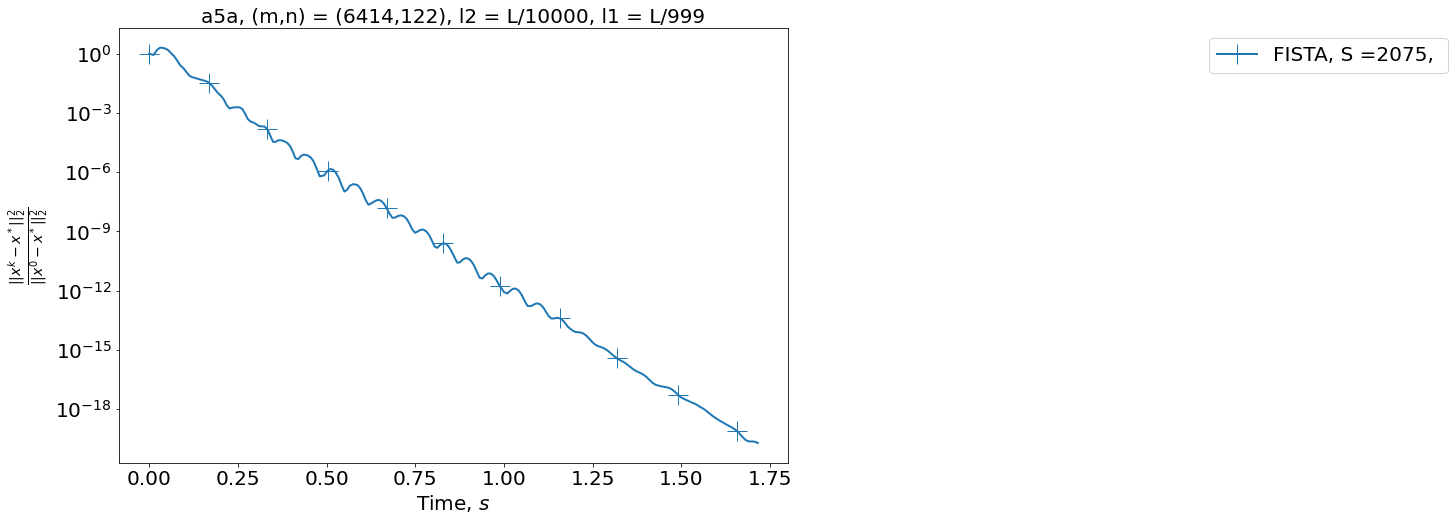

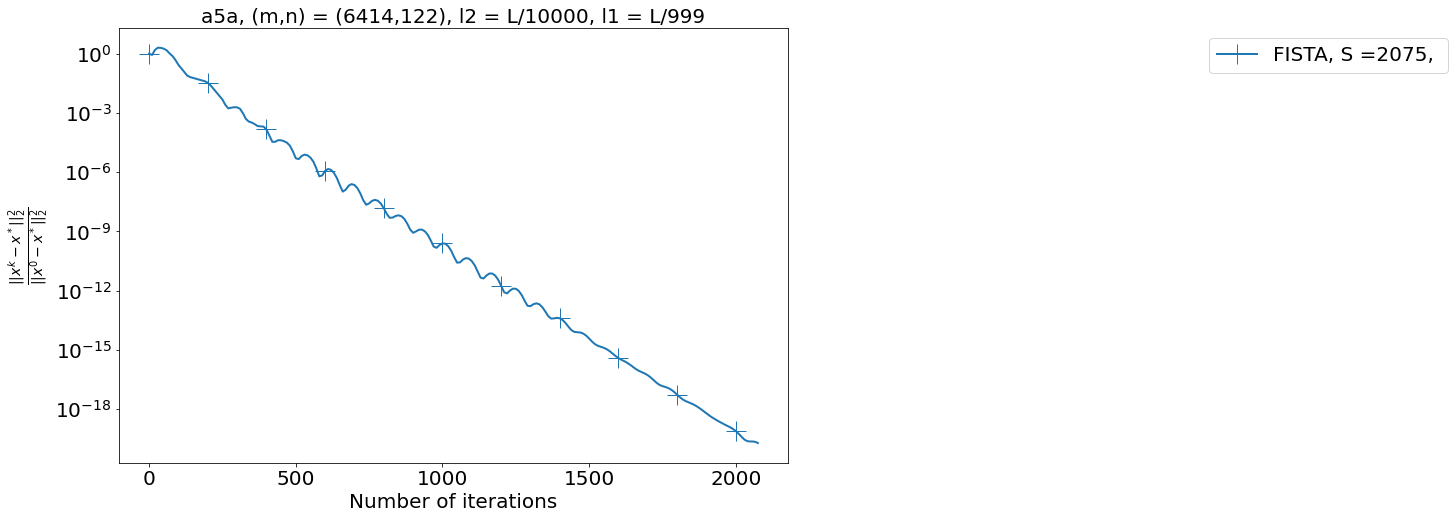

In [77]:
methods = [['FISTA', [l2, l1, S], f', S ={S}, ', None]]
mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in ('time', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

In [78]:
x_init = np.ones(n)
x_star = read_solution(dataset, l2,l1)[0]
f_star = read_solution(dataset, l2,l1)[1]
S = 20000
save_info_period = 100
sparse_full = False
sparse_stoch = False
    
for alpha in alpha_array:
    gamma = alpha/(L+l2)
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse=sparse, l1=l1, S=S, max_t=np.inf,
             save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)

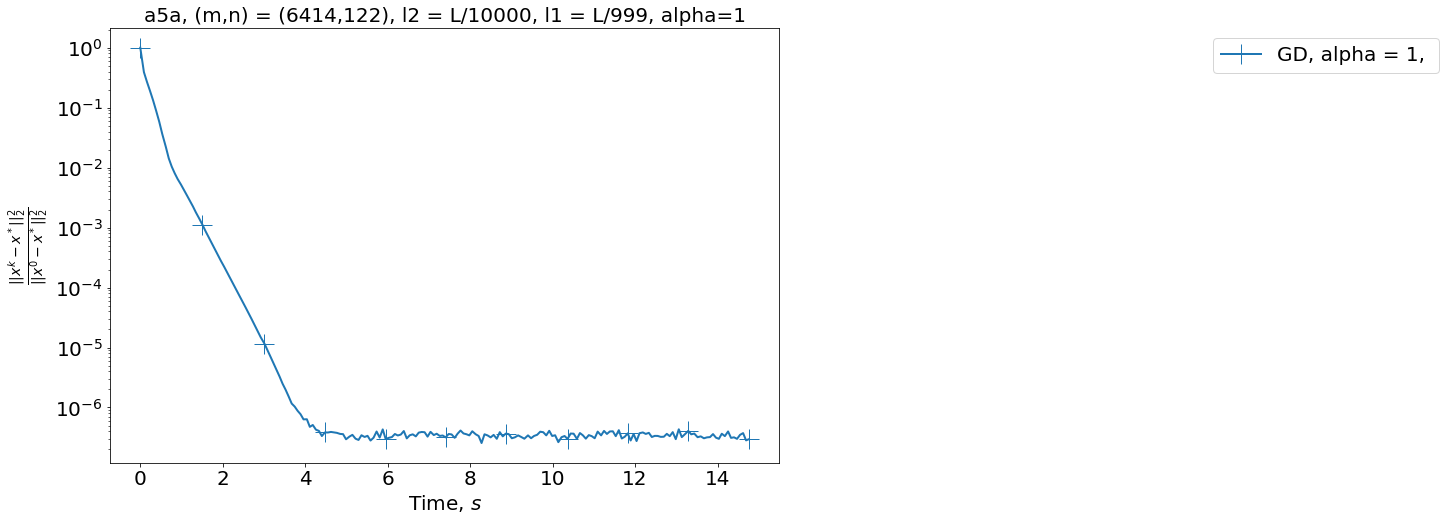

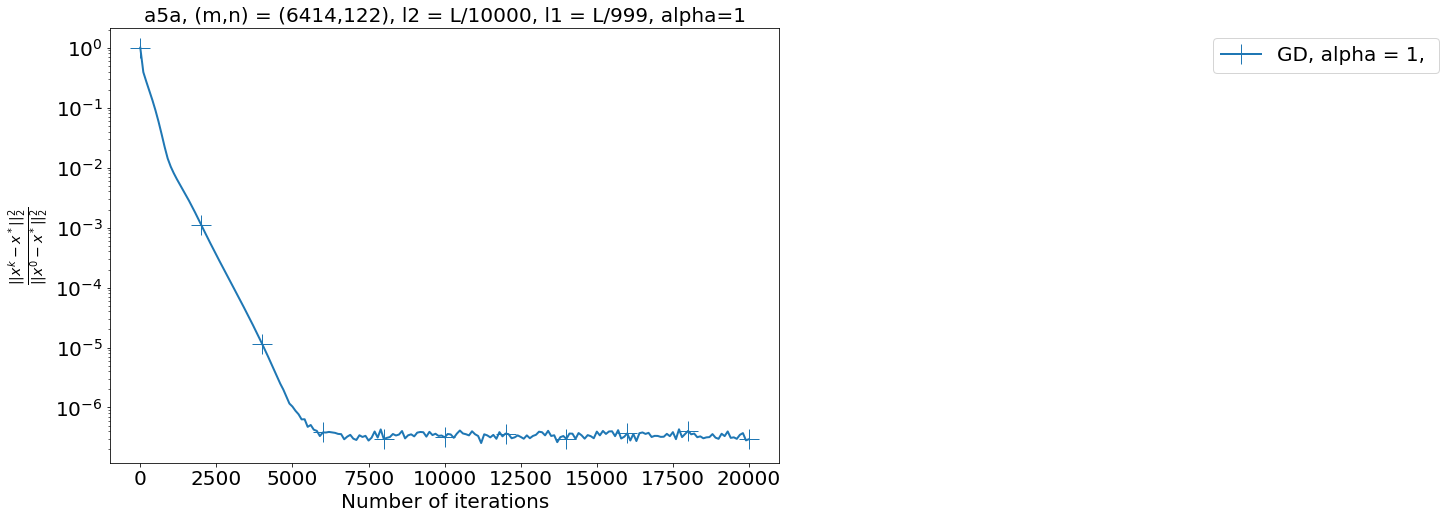

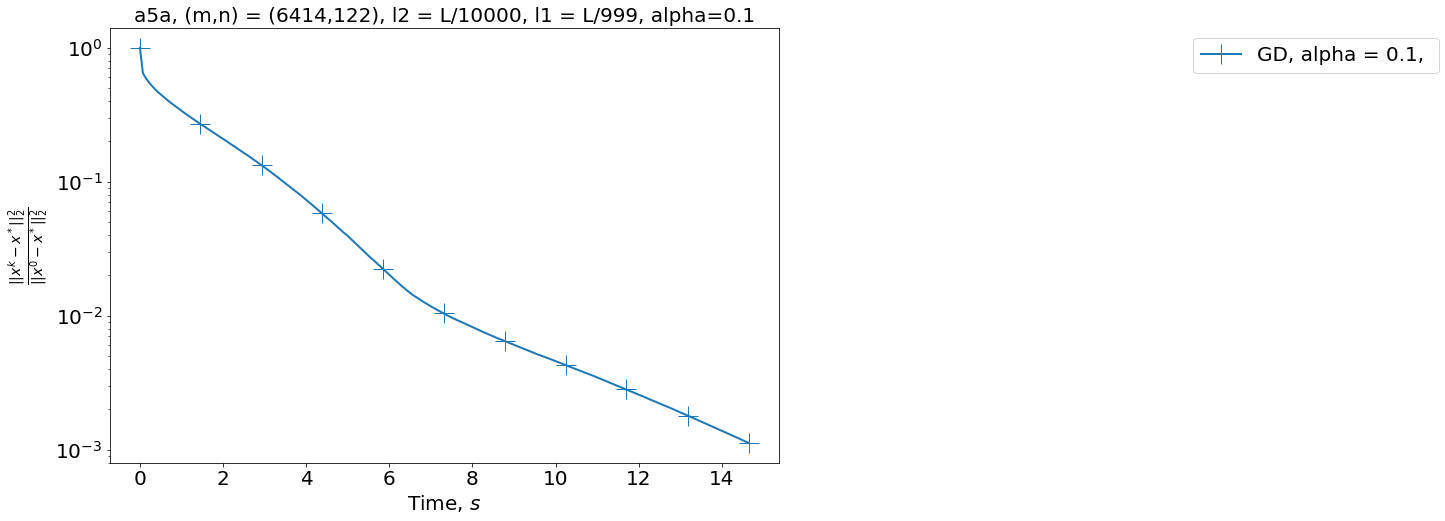

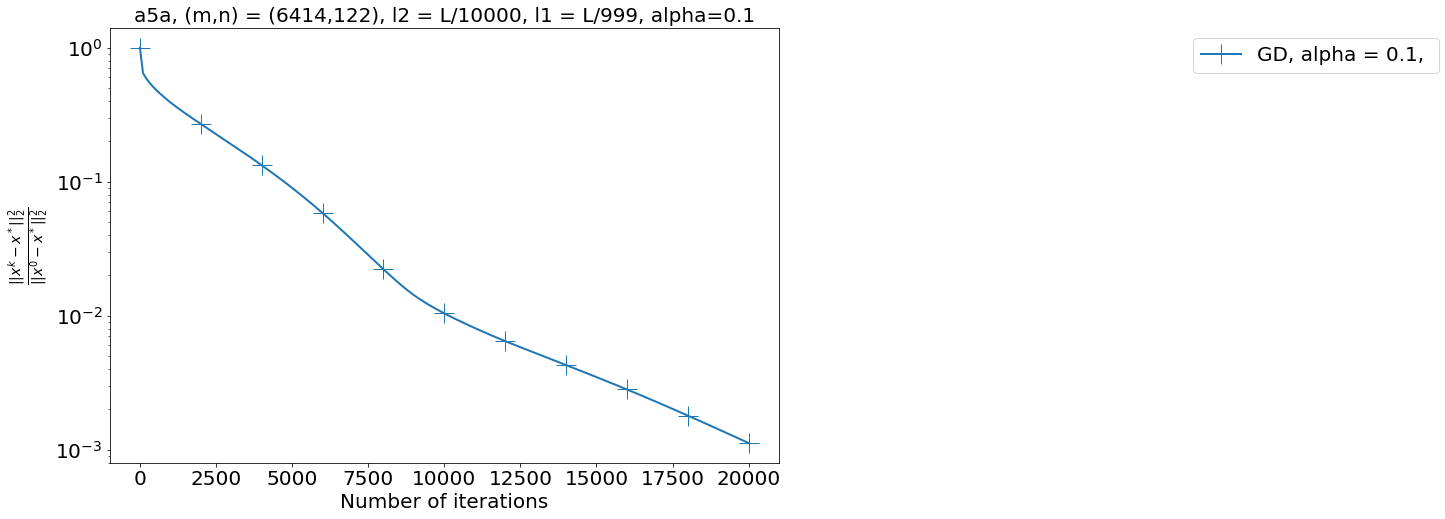

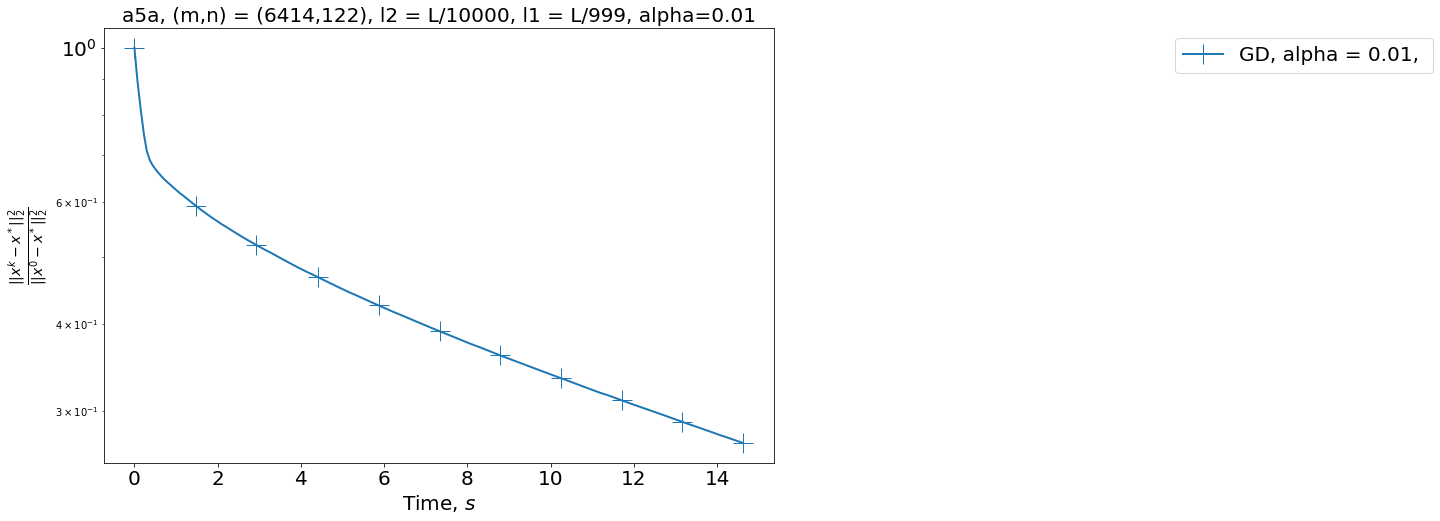

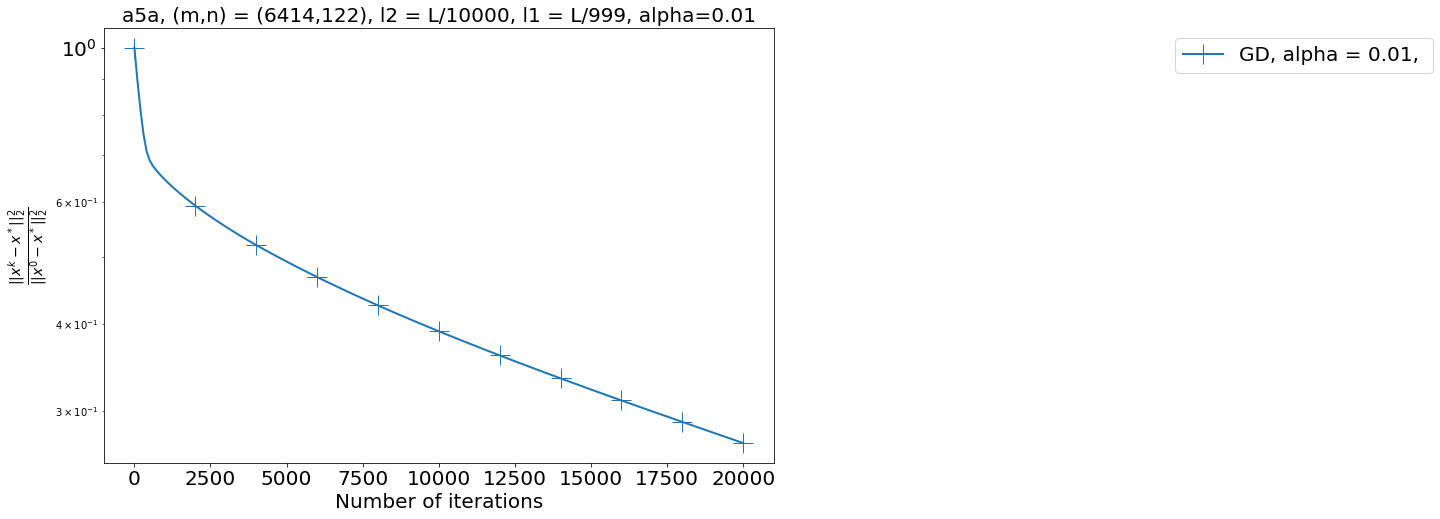

In [79]:
for alpha in alpha_array:
    methods = [['GD', [alpha/(L+l2), l2, l1, S], f', alpha = {alpha}, ', None]]
    mode_y = 'squared_distances'
    figsize = (12, 8)
    fontsize = 20
    title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+", alpha="+str(alpha)
    
    for mode_x in ('time', 'iters'):
        args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

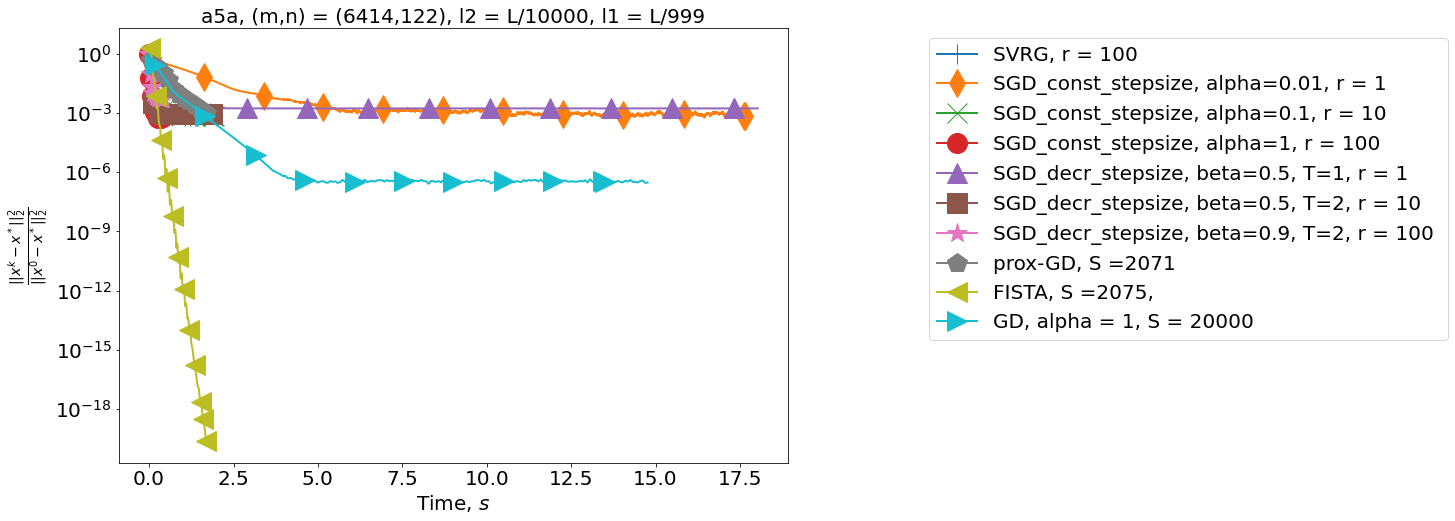

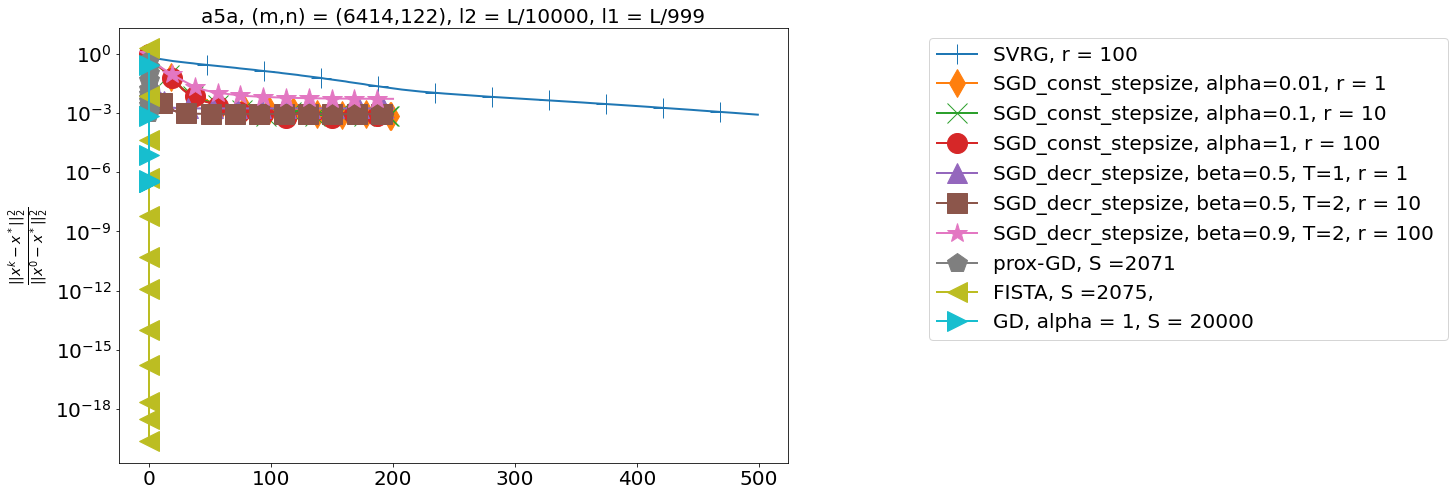

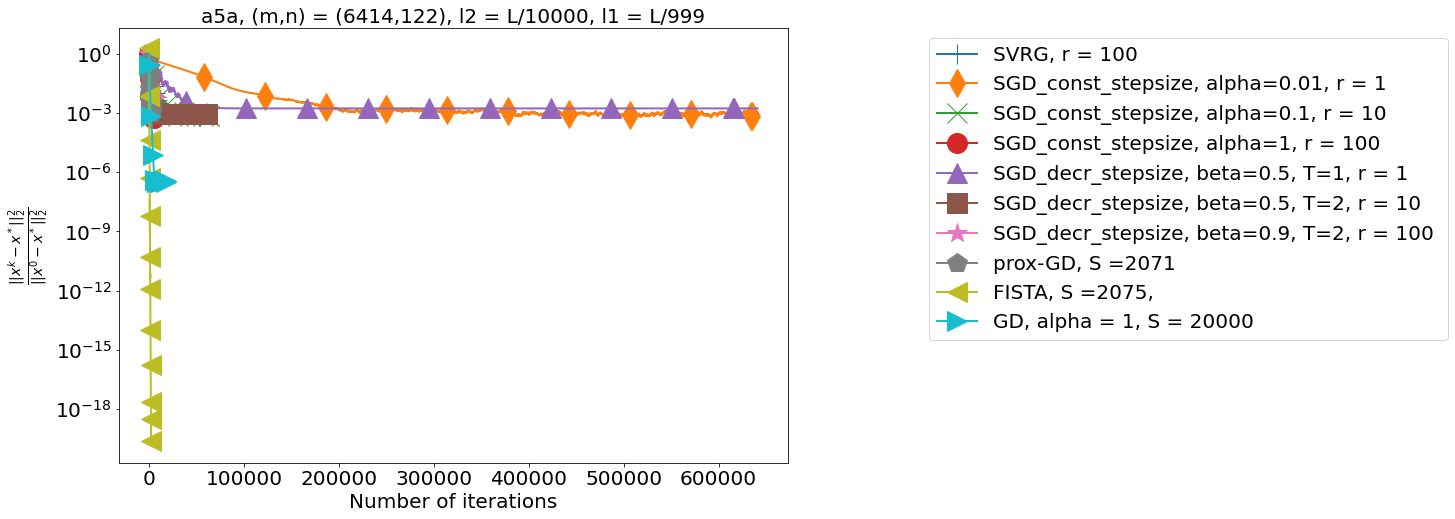

In [80]:
methods = [
    ['SVRG', [1.0/(6*(L+l2)), l2, l1, 100, int(2*m/100), 100], f', r = {100} ', None],
    ['SGD_const_stepsize', [0.01/(L+l2), l2, l1, 100, 1], f', alpha=0.01, r = {1} ', None],
    ['SGD_const_stepsize', [0.1/(L+l2), l2, l1, 100, 10], f', alpha=0.1, r = {10} ', None],
    ['SGD_const_stepsize', [1/(L+l2), l2, l1, 100, 100], f', alpha=1, r = {100} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 1, 0.5], l2, l1, 100, 1], f', beta=0.5, T=1, r = {1} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 2, 0.5], l2, l1, 100, 10], f', beta=0.5, T=2, r = {10} ', None],
    ['SGD_decr_stepsize', [[1/(L+l2), 2, 0.9], l2, l1, 100, 100], f', beta=0.9, T=2, r = {100} ', None],
    ['prox-GD', [1/L, l2, l1, 2071], f', S ={2071} ', None],
    ['FISTA', [l2, l1, 2075], f', S ={2075}, ', None],
    ['GD', [1/(L+l2), l2, l1, 20000], f', alpha = {1}, S = 20000 ', None]
]

mode_y = 'squared_distances'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

for mode_x in ('time', 'data_passes', 'iters'):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots)
    plt.show()

Для данной задачи лучше оказались FISTA и GD